## **This notebook aims to combine multiple assets databases**

In [1]:
import pandas as pd
import numpy as np
import os
import time
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
project_dir = "/home/jupyter-tfg2425paula/prediction_project_v3"
os.chdir(project_dir)

clean_data_dir = os.path.join(project_dir, "00_data/clean")
horizontal_data_dir = os.path.join(project_dir, "00_data/horizontal_structure")
results_dir = os.path.join(project_dir, "02_results")
plots_dir = os.path.join(project_dir, "03_plots")
pca_data_dir = os.path.join(project_dir, "00_data/pca")

### **GRU Model**

In [3]:
class GRU3DClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
        super(GRU3DClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :]) 
        # return self.sigmoid(out)
        return out

### **LSTM Model**

In [4]:
class StockPriceLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.0):
        super(StockPriceLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, 
                            batch_first=True, dropout=dropout)
    
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        batch_size = x.size(0)  # Get the batch size dynamically

        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)  # (num_layers, batch_size, hidden_dim)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)  # (num_layers, batch_size, hidden_dim)
        
        out, _ = self.lstm(x, (h0, c0))

        out = self.fc(out[:, -1, :]) 
        # out = self.sigmoid(out)
        return out
    

### **Set folders**

In [5]:
thresholds = [0.3, 0.35, 0.4, 0.45, 0.5]
thresholds = [0.5]
learning_rates = [0.005, 0.008, 0.009, 0.01]
learning_rates = [0.01]
num_epochs_list = [100, 200]
num_epochs_list = [100]
batch_sizes = [16, 32]
batch_sizes = [32]

#### **Model and Hyperparameters**

#### **Last data modifications**

In [6]:
def reshape_remove_characters(df):

    X = np.array([np.stack(row) for row in df.drop(columns=['Target']).values])
    y = df['Target'].values

    smote = SMOTE(random_state=42)
    n_samples, timesteps, n_features = X.shape
    X_flat = X.reshape((n_samples, timesteps * n_features))
    X_flat = np.where(X_flat == 'ç', 0, X_flat)

    X_resampled = X_flat.reshape((-1, timesteps, n_features))
    
    return X_resampled, y

### **Evaluation function**

In [7]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

def evaluate_model_plot(
    model, 
    X, 
    y, 
    criterion, 
    optimizer, 
    device, 
    train_size, 
    batch_size, 
    num_epochs, 
    lower_threshold,
    plots_dir=None,
    plot_filename=None
):

    # -------------------------------
    # 0) Prepare Tensors & Splits
    # -------------------------------
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.long)

    total_size = len(X)
    # Determine actual train_size index
    if train_size < 1.0:
        lower_bound = int(train_size * total_size)
    else:
        lower_bound = train_size

    # Training portion
    X_train = X[:lower_bound].to(device)
    y_train = y[:lower_bound].to(device)

    train_dataset = TensorDataset(X_train, y_train)
    trainloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=False,   # Set True if you prefer shuffling
        drop_last=False
    )

    if lower_bound < total_size:
        X_val = X[lower_bound:].to(device)
        y_val = y[lower_bound:].to(device)
        val_dataset = TensorDataset(X_val, y_val)
        valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    else:
        # If there's no leftover data for "test", handle gracefully
        X_val = None
        y_val = None
        valloader = None

    # ---------------------------------------------
    # 1) SINGLE TRAINING PHASE + Track Loss Curves
    # ---------------------------------------------
    model.to(device)
    model.train()

    epoch_train_losses = []
    epoch_test_losses = []

    for epoch in range(num_epochs):
        # TRAINING PASS
        epoch_loss = 0.0
        for X_batch, y_batch in trainloader:
            optimizer.zero_grad()

            # Forward
            pred_y = model(X_batch)
            loss = criterion(pred_y, y_batch)

            # Backprop & update
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # optional
            optimizer.step()

            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(trainloader)
        epoch_train_losses.append(avg_train_loss)

        
        # VALIDATION PASS (Optional but needed to get test_loss_curve)
        if valloader is not None:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for Xb, yb in valloader:
                    pred_yb = model(Xb)
                    loss_b = criterion(pred_yb, yb)
                    val_loss += loss_b.item()
            avg_val_loss = val_loss / len(valloader)
            epoch_test_losses.append(avg_val_loss)

            model.train()  # Switch back to train mode

        else:
            # If no validation set, just store None or 0
            epoch_test_losses.append(None)

        # Print progress every 5 epochs or last epoch
        if (epoch + 1) % 5 == 0 or (epoch == num_epochs - 1):
            if epoch_test_losses[-1] is not None:
                print(f"[Epoch {epoch+1}/{num_epochs}] ",
                      f"Train Loss: {avg_train_loss:.4f}")
            else:
                print(f"[Epoch {epoch+1}/{num_epochs}] "
                      f"Train Loss: {avg_train_loss:.4f}")

    # % decrease from first to last train loss
    if len(epoch_train_losses) > 1:
        loss_decrease_percentage = ((epoch_train_losses[-1] - epoch_train_losses[0])
                                    / epoch_train_losses[0]) * 100
    else:
        loss_decrease_percentage = 0.0

    final_train_loss = epoch_train_losses[-1]

    # -------------------------------
    # 2) ROLLING PREDICTIONS, NO UPDATE
    # -------------------------------
    model.eval()
    rolling_predictions = []
    rolling_targets = []

    for i in range(lower_bound, total_size):
        X_test = X[i:i+1].to(device)
        y_test = y[i:i+1].to(device)

        with torch.no_grad():
            pred_y = model(X_test)
            probabilities = torch.softmax(pred_y, dim=1).cpu().numpy()
            prob_class_1 = probabilities[:, 1]  # shape: (1,)

            # Threshold-based logic
            pred_classes = np.zeros_like(prob_class_1)
            # Predict -1 if prob < lower_threshold
            pred_classes[prob_class_1 < lower_threshold] = -1
            # Predict +1 if prob > (1 - lower_threshold)
            pred_classes[prob_class_1 > (1 - lower_threshold)] = 1

        rolling_predictions.append(pred_classes[0])
        rolling_targets.append(y_test.item())

    rolling_predictions = np.array(rolling_predictions)
    rolling_targets = np.array(rolling_targets).astype(int)

    # If original labels might be {0,1}, adapt as needed
    rolling_targets[rolling_targets == 0] = -1

    # Filter out zero predictions
    nonzero_mask = (rolling_predictions != 0)
    filtered_preds = rolling_predictions[nonzero_mask]
    filtered_targets = rolling_targets[nonzero_mask]

    if len(filtered_preds) == 0:
        accuracy_nonzero = None
        print("No nonzero predictions, cannot compute thresholded accuracy.")
    else:
        accuracy_nonzero = accuracy_score(filtered_targets, filtered_preds)
        print(f"Accuracy on Nonzero Predictions: {accuracy_nonzero:.4f}")

    # -------------------------------------------------
    # 3) PLOT (if plots_dir is set and there's test data)
    # -------------------------------------------------
    if plots_dir is not None:
        os.makedirs(plots_dir, exist_ok=True)

        # If user didn't provide a filename, create a default
        if plot_filename is None:
            plot_filename = "train_test_loss_curve.png"
        plot_path = os.path.join(plots_dir, plot_filename)

        # Plot the training and validation (test) loss curves
        plt.figure(figsize=(8, 5))
        plt.plot(epoch_train_losses, label="Train Loss")
        # Only plot test loss if it isn't None
        if any(x is not None for x in epoch_test_losses):
            plt.plot(epoch_test_losses, label="Test Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Train vs. Test Loss per Epoch")
        plt.legend()
        plt.tight_layout()

        # plt.savefig(plot_path)
        plt.show()
        print(f"Loss curves saved to: {plot_path}")

    # ----------------
    # 4) Return results
    # ----------------
    return {
        "rolling_predictions": rolling_predictions,
        "rolling_targets": rolling_targets,
        "filtered_predictions": filtered_preds,
        "filtered_targets": filtered_targets,
        "accuracy_nonzero": accuracy_nonzero,
        "loss_decrease_percentage": loss_decrease_percentage,
        "final_train_loss": final_train_loss,
        "train_loss_curve": epoch_train_losses,
        "test_loss_curve": epoch_test_losses
    }


## **Run LSTM and GRU Models**

In [8]:
possible_train_size = 95

num_epochs = 100
prediction_threshold = 0.5

learning_rate = 0.01

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 64
hidden_size = 64  
output_size = 2  
num_layers = 2
dropout = 0.2

criterion = nn.CrossEntropyLoss()

----- SECURITY TYPE: single_name, WINDOW SIZE: 5, STOCK: SPX -----
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6924
[Epoch 10/100]  Train Loss: 0.6890
[Epoch 15/100]  Train Loss: 0.6857
[Epoch 20/100]  Train Loss: 0.6823
[Epoch 25/100]  Train Loss: 0.6785
[Epoch 30/100]  Train Loss: 0.6738
[Epoch 35/100]  Train Loss: 0.6693
[Epoch 40/100]  Train Loss: 0.6649
[Epoch 45/100]  Train Loss: 0.6603
[Epoch 50/100]  Train Loss: 0.6562
[Epoch 55/100]  Train Loss: 0.6517
[Epoch 60/100]  Train Loss: 0.6465
[Epoch 65/100]  Train Loss: 0.6410
[Epoch 70/100]  Train Loss: 0.6356
[Epoch 75/100]  Train Loss: 0.6308
[Epoch 80/100]  Train Loss: 0.6265
[Epoch 85/100]  Train Loss: 0.6224
[Epoch 90/100]  Train Loss: 0.6180
[Epoch 95/100]  Train Loss: 0.6137
[Epoch 100/100]  Train Loss: 0.6098
Accuracy on Nonzero Predictions: 0.5344


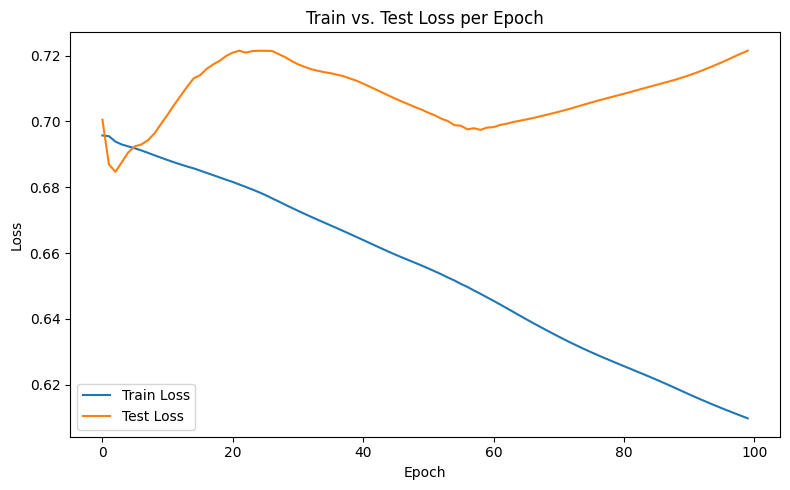

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6926
[Epoch 10/100]  Train Loss: 0.6887
[Epoch 15/100]  Train Loss: 0.6854
[Epoch 20/100]  Train Loss: 0.6824
[Epoch 25/100]  Train Loss: 0.6795
[Epoch 30/100]  Train Loss: 0.6765
[Epoch 35/100]  Train Loss: 0.6725
[Epoch 40/100]  Train Loss: 0.6682
[Epoch 45/100]  Train Loss: 0.6641
[Epoch 50/100]  Train Loss: 0.6588
[Epoch 55/100]  Train Loss: 0.6533
[Epoch 60/100]  Train Loss: 0.6489
[Epoch 65/100]  Train Loss: 0.6450
[Epoch 70/100]  Train Loss: 0.6411
[Epoch 75/100]  Train Loss: 0.6367
[Epoch 80/100]  Train Loss: 0.6325
[Epoch 85/100]  Train Loss: 0.6287
[Epoch 90/100]  Train Loss: 0.6250
[Epoch 95/100]  Train Loss: 0.6213
[Epoch 100/100]  Train Loss: 0.6177
Accuracy on Nonzero Predictions: 0.4885


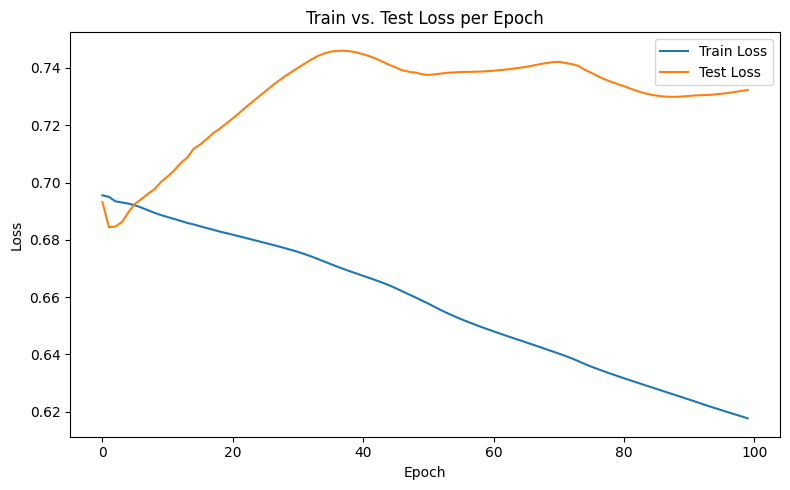

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6927
[Epoch 10/100]  Train Loss: 0.6899
[Epoch 15/100]  Train Loss: 0.6866
[Epoch 20/100]  Train Loss: 0.6831
[Epoch 25/100]  Train Loss: 0.6789
[Epoch 30/100]  Train Loss: 0.6739
[Epoch 35/100]  Train Loss: 0.6680
[Epoch 40/100]  Train Loss: 0.6617
[Epoch 45/100]  Train Loss: 0.6555
[Epoch 50/100]  Train Loss: 0.6491
[Epoch 55/100]  Train Loss: 0.6433
[Epoch 60/100]  Train Loss: 0.6382
[Epoch 65/100]  Train Loss: 0.6334
[Epoch 70/100]  Train Loss: 0.6293
[Epoch 75/100]  Train Loss: 0.6255
[Epoch 80/100]  Train Loss: 0.6216
[Epoch 85/100]  Train Loss: 0.6176
[Epoch 90/100]  Train Loss: 0.6134
[Epoch 95/100]  Train Loss: 0.6097
[Epoch 100/100]  Train Loss: 0.6063
Accuracy on Nonzero Predictions: 0.4885


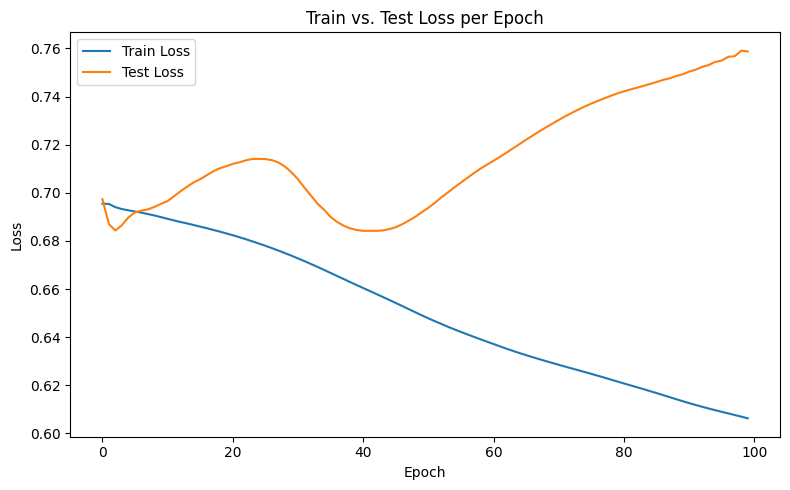

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6925
[Epoch 10/100]  Train Loss: 0.6896
[Epoch 15/100]  Train Loss: 0.6858
[Epoch 20/100]  Train Loss: 0.6815
[Epoch 25/100]  Train Loss: 0.6768
[Epoch 30/100]  Train Loss: 0.6711
[Epoch 35/100]  Train Loss: 0.6636
[Epoch 40/100]  Train Loss: 0.6563
[Epoch 45/100]  Train Loss: 0.6494
[Epoch 50/100]  Train Loss: 0.6430
[Epoch 55/100]  Train Loss: 0.6369
[Epoch 60/100]  Train Loss: 0.6306
[Epoch 65/100]  Train Loss: 0.6255
[Epoch 70/100]  Train Loss: 0.6209
[Epoch 75/100]  Train Loss: 0.6161
[Epoch 80/100]  Train Loss: 0.6111
[Epoch 85/100]  Train Loss: 0.6060
[Epoch 90/100]  Train Loss: 0.6011
[Epoch 95/100]  Train Loss: 0.5969
[Epoch 100/100]  Train Loss: 0.5929
Accuracy on Nonzero Predictions: 0.4504


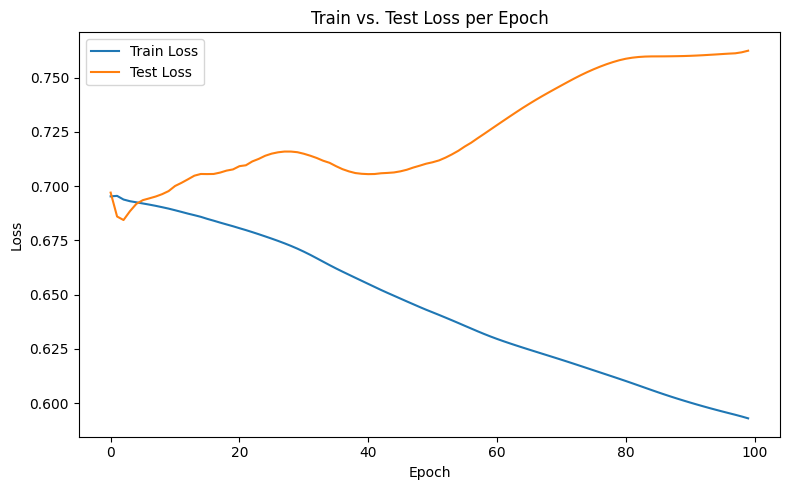

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6929
[Epoch 10/100]  Train Loss: 0.6890
[Epoch 15/100]  Train Loss: 0.6849
[Epoch 20/100]  Train Loss: 0.6813
[Epoch 25/100]  Train Loss: 0.6778
[Epoch 30/100]  Train Loss: 0.6748
[Epoch 35/100]  Train Loss: 0.6720
[Epoch 40/100]  Train Loss: 0.6691
[Epoch 45/100]  Train Loss: 0.6657
[Epoch 50/100]  Train Loss: 0.6618
[Epoch 55/100]  Train Loss: 0.6574
[Epoch 60/100]  Train Loss: 0.6527
[Epoch 65/100]  Train Loss: 0.6479
[Epoch 70/100]  Train Loss: 0.6435
[Epoch 75/100]  Train Loss: 0.6396
[Epoch 80/100]  Train Loss: 0.6360
[Epoch 85/100]  Train Loss: 0.6316
[Epoch 90/100]  Train Loss: 0.6258
[Epoch 95/100]  Train Loss: 0.6207
[Epoch 100/100]  Train Loss: 0.6167
Accuracy on Nonzero Predictions: 0.5344


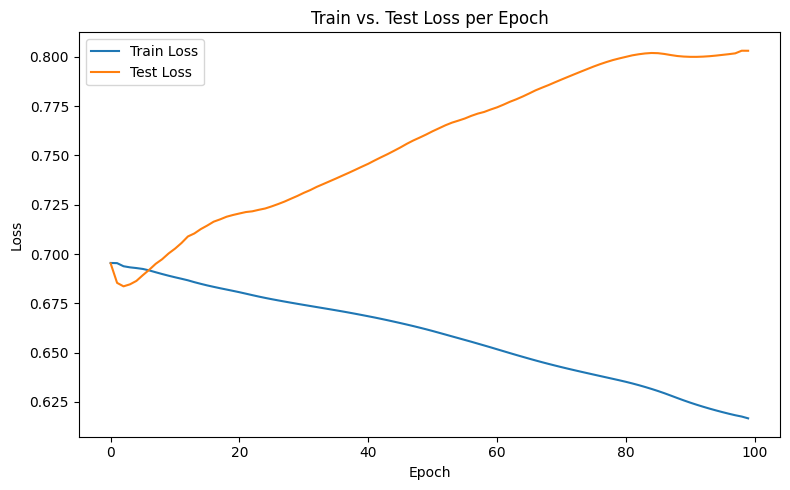

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6944
[Epoch 10/100]  Train Loss: 0.6932
[Epoch 15/100]  Train Loss: 0.6918
[Epoch 20/100]  Train Loss: 0.6894
[Epoch 25/100]  Train Loss: 0.6867
[Epoch 30/100]  Train Loss: 0.6794
[Epoch 35/100]  Train Loss: 0.6728
[Epoch 40/100]  Train Loss: 0.6645
[Epoch 45/100]  Train Loss: 0.6533
[Epoch 50/100]  Train Loss: 0.6495
[Epoch 55/100]  Train Loss: 0.6337
[Epoch 60/100]  Train Loss: 0.6296
[Epoch 65/100]  Train Loss: 0.6067
[Epoch 70/100]  Train Loss: 0.5938
[Epoch 75/100]  Train Loss: 0.5924
[Epoch 80/100]  Train Loss: 0.5740
[Epoch 85/100]  Train Loss: 0.5661
[Epoch 90/100]  Train Loss: 0.5514
[Epoch 95/100]  Train Loss: 0.5562
[Epoch 100/100]  Train Loss: 0.5454
Accuracy on Nonzero Predictions: 0.4809


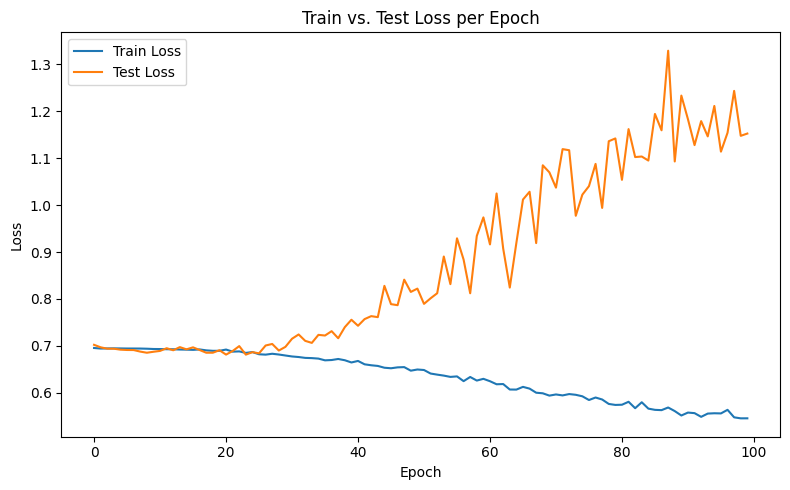

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6943
[Epoch 10/100]  Train Loss: 0.6931
[Epoch 15/100]  Train Loss: 0.6908
[Epoch 20/100]  Train Loss: 0.6879
[Epoch 25/100]  Train Loss: 0.6843
[Epoch 30/100]  Train Loss: 0.6812
[Epoch 35/100]  Train Loss: 0.6713
[Epoch 40/100]  Train Loss: 0.6646
[Epoch 45/100]  Train Loss: 0.6554
[Epoch 50/100]  Train Loss: 0.6347
[Epoch 55/100]  Train Loss: 0.6334
[Epoch 60/100]  Train Loss: 0.6261
[Epoch 65/100]  Train Loss: 0.6126
[Epoch 70/100]  Train Loss: 0.6024
[Epoch 75/100]  Train Loss: 0.5937
[Epoch 80/100]  Train Loss: 0.5892
[Epoch 85/100]  Train Loss: 0.5751
[Epoch 90/100]  Train Loss: 0.5626
[Epoch 95/100]  Train Loss: 0.5517
[Epoch 100/100]  Train Loss: 0.5616
Accuracy on Nonzero Predictions: 0.5496


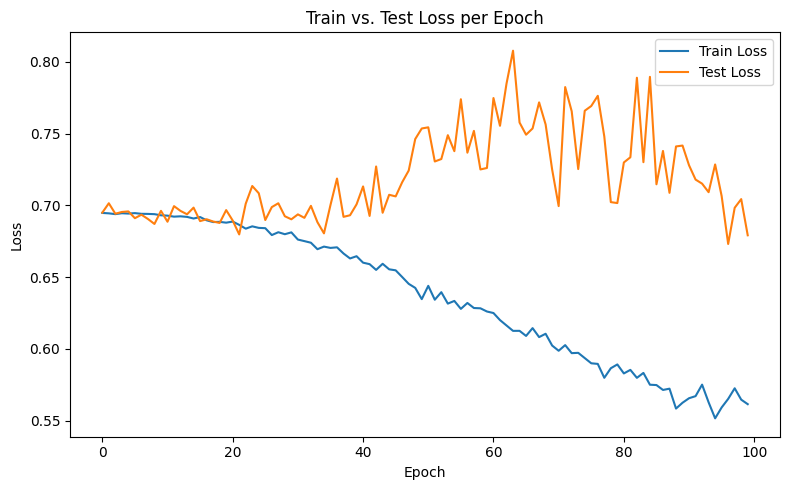

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6945
[Epoch 10/100]  Train Loss: 0.6932
[Epoch 15/100]  Train Loss: 0.6914
[Epoch 20/100]  Train Loss: 0.6884
[Epoch 25/100]  Train Loss: 0.6823
[Epoch 30/100]  Train Loss: 0.6763
[Epoch 35/100]  Train Loss: 0.6681
[Epoch 40/100]  Train Loss: 0.6627
[Epoch 45/100]  Train Loss: 0.6533
[Epoch 50/100]  Train Loss: 0.6423
[Epoch 55/100]  Train Loss: 0.6324
[Epoch 60/100]  Train Loss: 0.6216
[Epoch 65/100]  Train Loss: 0.6123
[Epoch 70/100]  Train Loss: 0.6099
[Epoch 75/100]  Train Loss: 0.5860
[Epoch 80/100]  Train Loss: 0.5848
[Epoch 85/100]  Train Loss: 0.5720
[Epoch 90/100]  Train Loss: 0.5703
[Epoch 95/100]  Train Loss: 0.5590
[Epoch 100/100]  Train Loss: 0.5564
Accuracy on Nonzero Predictions: 0.5344


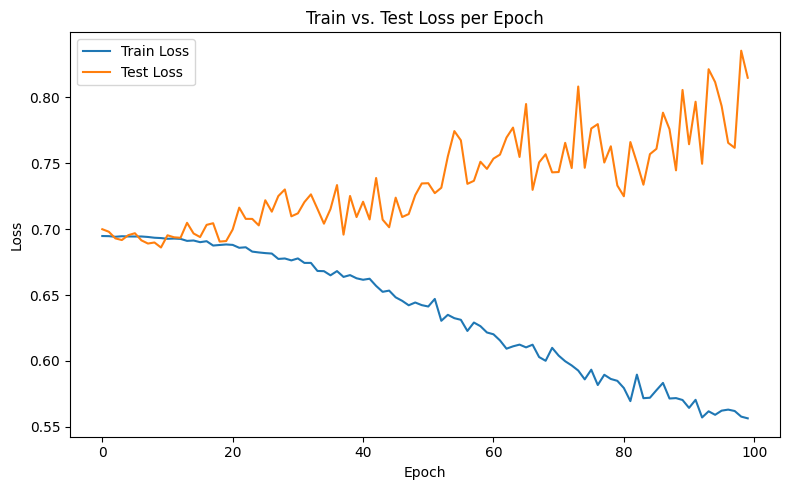

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6944
[Epoch 10/100]  Train Loss: 0.6932
[Epoch 15/100]  Train Loss: 0.6917
[Epoch 20/100]  Train Loss: 0.6884
[Epoch 25/100]  Train Loss: 0.6847
[Epoch 30/100]  Train Loss: 0.6769
[Epoch 35/100]  Train Loss: 0.6705
[Epoch 40/100]  Train Loss: 0.6640
[Epoch 45/100]  Train Loss: 0.6506
[Epoch 50/100]  Train Loss: 0.6491
[Epoch 55/100]  Train Loss: 0.6368
[Epoch 60/100]  Train Loss: 0.6289
[Epoch 65/100]  Train Loss: 0.6167
[Epoch 70/100]  Train Loss: 0.6073
[Epoch 75/100]  Train Loss: 0.5937
[Epoch 80/100]  Train Loss: 0.5808
[Epoch 85/100]  Train Loss: 0.5703
[Epoch 90/100]  Train Loss: 0.5677
[Epoch 95/100]  Train Loss: 0.5595
[Epoch 100/100]  Train Loss: 0.5571
Accuracy on Nonzero Predictions: 0.5115


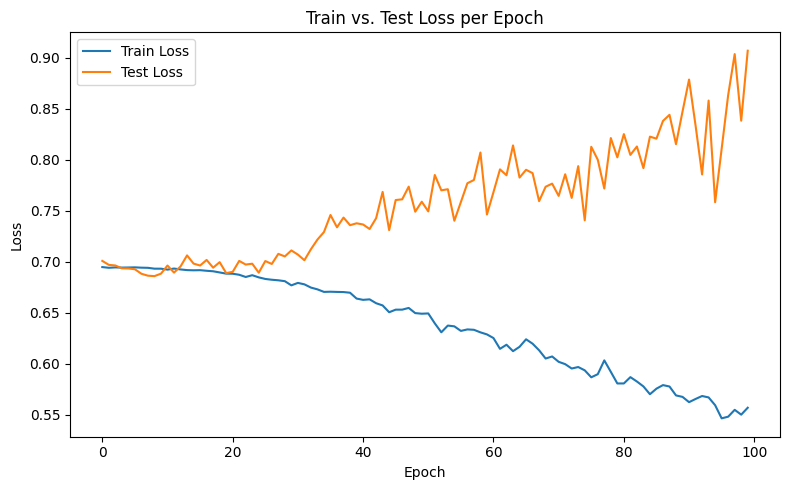

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6944
[Epoch 10/100]  Train Loss: 0.6934
[Epoch 15/100]  Train Loss: 0.6916
[Epoch 20/100]  Train Loss: 0.6878
[Epoch 25/100]  Train Loss: 0.6837
[Epoch 30/100]  Train Loss: 0.6761
[Epoch 35/100]  Train Loss: 0.6688
[Epoch 40/100]  Train Loss: 0.6576
[Epoch 45/100]  Train Loss: 0.6487
[Epoch 50/100]  Train Loss: 0.6373
[Epoch 55/100]  Train Loss: 0.6262
[Epoch 60/100]  Train Loss: 0.6197
[Epoch 65/100]  Train Loss: 0.6122
[Epoch 70/100]  Train Loss: 0.5945
[Epoch 75/100]  Train Loss: 0.6004
[Epoch 80/100]  Train Loss: 0.5813
[Epoch 85/100]  Train Loss: 0.5767
[Epoch 90/100]  Train Loss: 0.5666
[Epoch 95/100]  Train Loss: 0.5622
[Epoch 100/100]  Train Loss: 0.5578
Accuracy on Nonzero Predictions: 0.5191


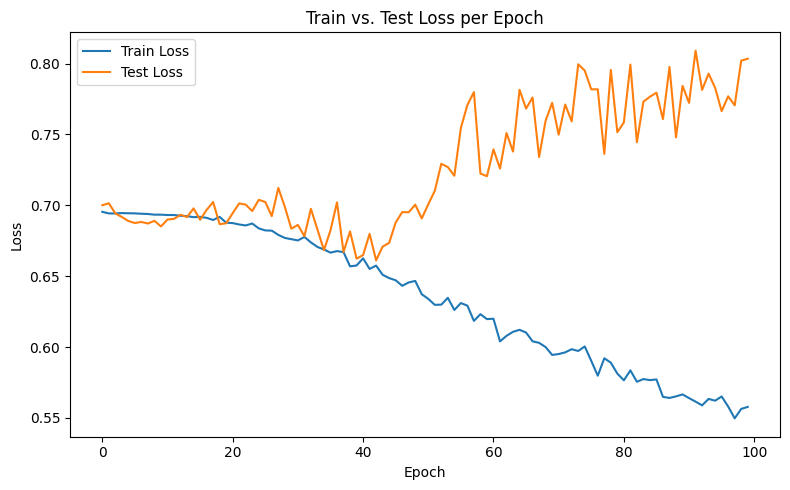

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
----- SECURITY TYPE: single_name, WINDOW SIZE: 10, STOCK: SPX -----
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6841
[Epoch 10/100]  Train Loss: 0.6631
[Epoch 15/100]  Train Loss: 0.6329
[Epoch 20/100]  Train Loss: 0.5879
[Epoch 25/100]  Train Loss: 0.5388
[Epoch 30/100]  Train Loss: 0.4966
[Epoch 35/100]  Train Loss: 0.4583
[Epoch 40/100]  Train Loss: 0.4257
[Epoch 45/100]  Train Loss: 0.3923
[Epoch 50/100]  Train Loss: 0.3586
[Epoch 55/100]  Train Loss: 0.3277
[Epoch 60/100]  Train Loss: 0.2995
[Epoch 65/100]  Train Loss: 0.2738
[Epoch 70/100]  Train Loss: 0.2510
[Epoch 75/100]  Train Loss: 0.2270
[Epoch 80/100]  Train Loss: 0.2040
[Epoch 85/100]  Train Loss: 0.1819
[Epoch 90/100]  Train Loss: 0.1612
[Epoch 95/100]  Train Loss: 0.1414
[Epoch 100/100]  Train Loss: 0.1241
Accuracy on Nonzero Predictions: 0.4275


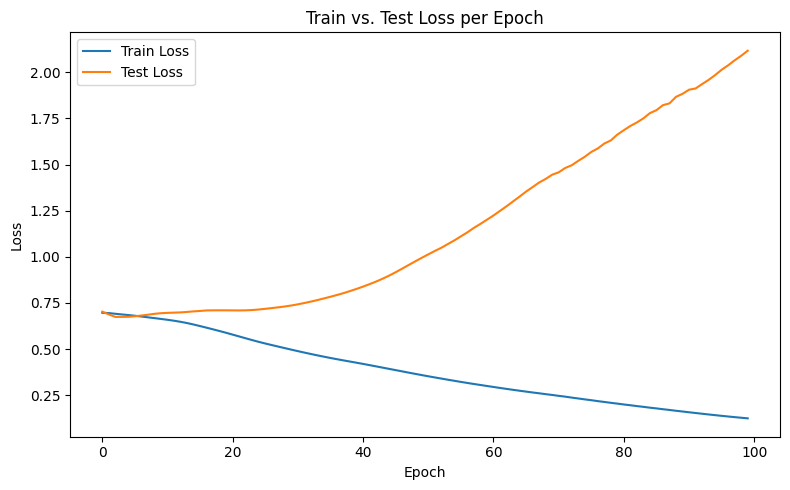

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6833
[Epoch 10/100]  Train Loss: 0.6582
[Epoch 15/100]  Train Loss: 0.6310
[Epoch 20/100]  Train Loss: 0.5945
[Epoch 25/100]  Train Loss: 0.5465
[Epoch 30/100]  Train Loss: 0.4958
[Epoch 35/100]  Train Loss: 0.4521
[Epoch 40/100]  Train Loss: 0.4117
[Epoch 45/100]  Train Loss: 0.3762
[Epoch 50/100]  Train Loss: 0.3462
[Epoch 55/100]  Train Loss: 0.3192
[Epoch 60/100]  Train Loss: 0.2944
[Epoch 65/100]  Train Loss: 0.2719
[Epoch 70/100]  Train Loss: 0.2514
[Epoch 75/100]  Train Loss: 0.2310
[Epoch 80/100]  Train Loss: 0.2116
[Epoch 85/100]  Train Loss: 0.1938
[Epoch 90/100]  Train Loss: 0.1781
[Epoch 95/100]  Train Loss: 0.1628
[Epoch 100/100]  Train Loss: 0.1485
Accuracy on Nonzero Predictions: 0.4580


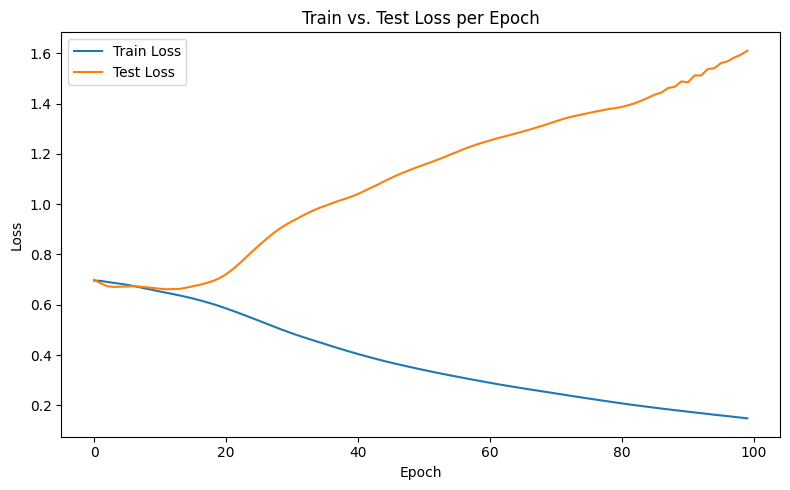

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6838
[Epoch 10/100]  Train Loss: 0.6605
[Epoch 15/100]  Train Loss: 0.6230
[Epoch 20/100]  Train Loss: 0.5820
[Epoch 25/100]  Train Loss: 0.5412
[Epoch 30/100]  Train Loss: 0.5005
[Epoch 35/100]  Train Loss: 0.4555
[Epoch 40/100]  Train Loss: 0.4133
[Epoch 45/100]  Train Loss: 0.3751
[Epoch 50/100]  Train Loss: 0.3407
[Epoch 55/100]  Train Loss: 0.3087
[Epoch 60/100]  Train Loss: 0.2786
[Epoch 65/100]  Train Loss: 0.2524
[Epoch 70/100]  Train Loss: 0.2284
[Epoch 75/100]  Train Loss: 0.2063
[Epoch 80/100]  Train Loss: 0.1861
[Epoch 85/100]  Train Loss: 0.1674
[Epoch 90/100]  Train Loss: 0.1506
[Epoch 95/100]  Train Loss: 0.1352
[Epoch 100/100]  Train Loss: 0.1209
Accuracy on Nonzero Predictions: 0.4580


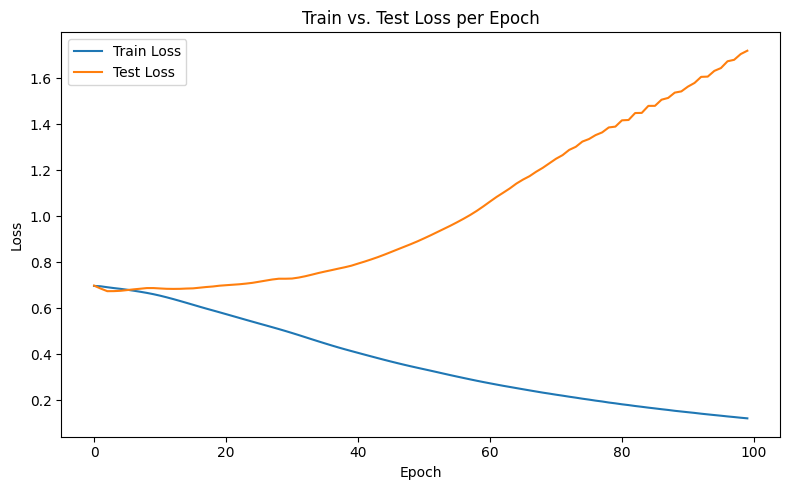

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6848
[Epoch 10/100]  Train Loss: 0.6617
[Epoch 15/100]  Train Loss: 0.6225
[Epoch 20/100]  Train Loss: 0.5741
[Epoch 25/100]  Train Loss: 0.5210
[Epoch 30/100]  Train Loss: 0.4709
[Epoch 35/100]  Train Loss: 0.4249
[Epoch 40/100]  Train Loss: 0.3829
[Epoch 45/100]  Train Loss: 0.3451
[Epoch 50/100]  Train Loss: 0.3121
[Epoch 55/100]  Train Loss: 0.2786
[Epoch 60/100]  Train Loss: 0.2492
[Epoch 65/100]  Train Loss: 0.2243
[Epoch 70/100]  Train Loss: 0.2011
[Epoch 75/100]  Train Loss: 0.1802
[Epoch 80/100]  Train Loss: 0.1612
[Epoch 85/100]  Train Loss: 0.1437
[Epoch 90/100]  Train Loss: 0.1276
[Epoch 95/100]  Train Loss: 0.1117
[Epoch 100/100]  Train Loss: 0.0969
Accuracy on Nonzero Predictions: 0.5267


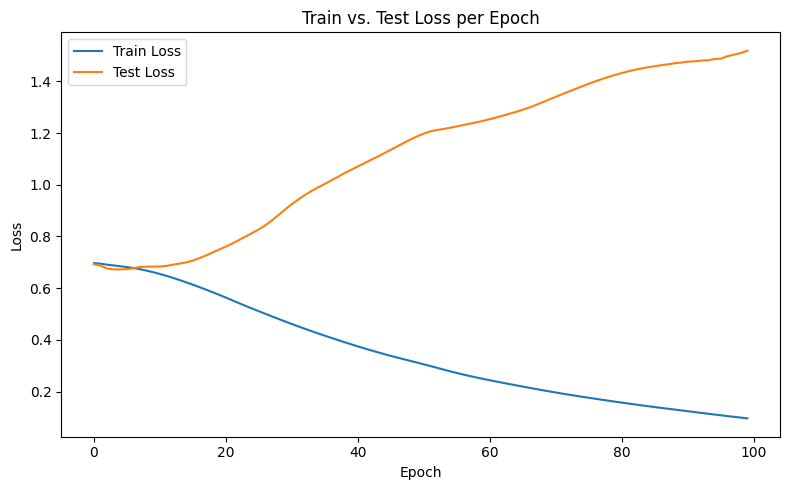

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6841
[Epoch 10/100]  Train Loss: 0.6641
[Epoch 15/100]  Train Loss: 0.6302
[Epoch 20/100]  Train Loss: 0.5911
[Epoch 25/100]  Train Loss: 0.5453
[Epoch 30/100]  Train Loss: 0.4929
[Epoch 35/100]  Train Loss: 0.4471
[Epoch 40/100]  Train Loss: 0.4073
[Epoch 45/100]  Train Loss: 0.3709
[Epoch 50/100]  Train Loss: 0.3390
[Epoch 55/100]  Train Loss: 0.3091
[Epoch 60/100]  Train Loss: 0.2824
[Epoch 65/100]  Train Loss: 0.2577
[Epoch 70/100]  Train Loss: 0.2338
[Epoch 75/100]  Train Loss: 0.2115
[Epoch 80/100]  Train Loss: 0.1906
[Epoch 85/100]  Train Loss: 0.1721
[Epoch 90/100]  Train Loss: 0.1551
[Epoch 95/100]  Train Loss: 0.1422
[Epoch 100/100]  Train Loss: 0.1275
Accuracy on Nonzero Predictions: 0.4427


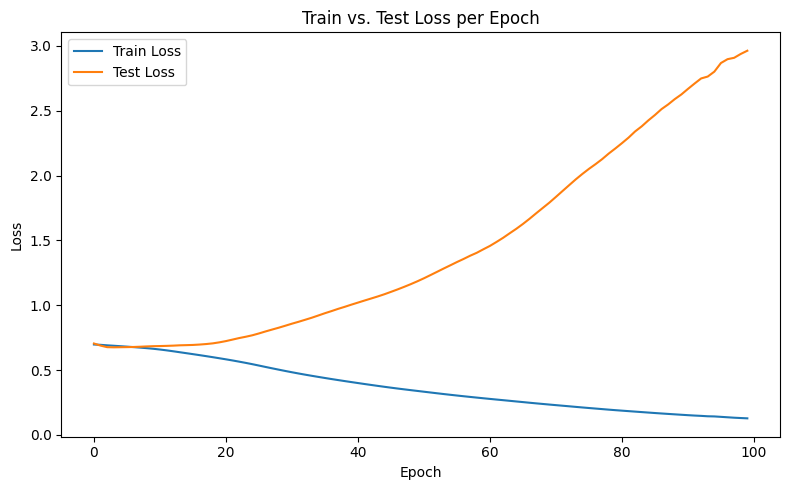

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6930
[Epoch 10/100]  Train Loss: 0.6703
[Epoch 15/100]  Train Loss: 0.6508
[Epoch 20/100]  Train Loss: 0.6254
[Epoch 25/100]  Train Loss: 0.5875
[Epoch 30/100]  Train Loss: 0.5452
[Epoch 35/100]  Train Loss: 0.5103
[Epoch 40/100]  Train Loss: 0.4807
[Epoch 45/100]  Train Loss: 0.4537
[Epoch 50/100]  Train Loss: 0.4216
[Epoch 55/100]  Train Loss: 0.4059
[Epoch 60/100]  Train Loss: 0.3824
[Epoch 65/100]  Train Loss: 0.3605
[Epoch 70/100]  Train Loss: 0.3558
[Epoch 75/100]  Train Loss: 0.3426
[Epoch 80/100]  Train Loss: 0.3459
[Epoch 85/100]  Train Loss: 0.3215
[Epoch 90/100]  Train Loss: 0.3205
[Epoch 95/100]  Train Loss: 0.3138
[Epoch 100/100]  Train Loss: 0.2773
Accuracy on Nonzero Predictions: 0.4733


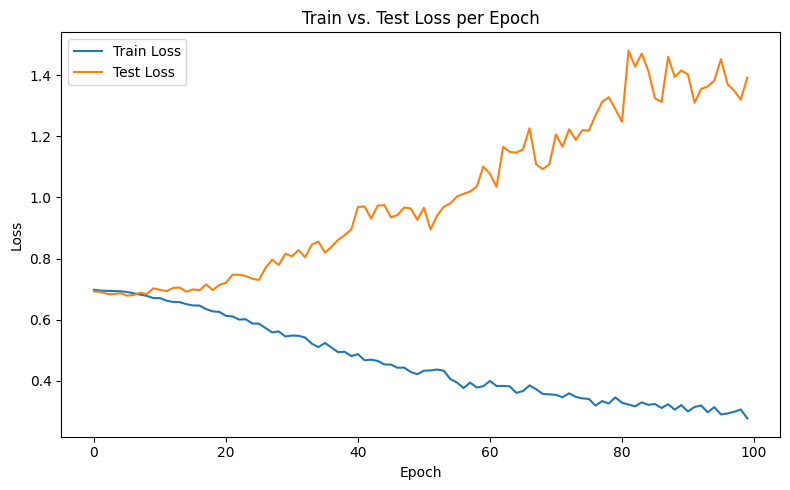

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6921
[Epoch 10/100]  Train Loss: 0.6712
[Epoch 15/100]  Train Loss: 0.6493
[Epoch 20/100]  Train Loss: 0.6183
[Epoch 25/100]  Train Loss: 0.5796
[Epoch 30/100]  Train Loss: 0.5511
[Epoch 35/100]  Train Loss: 0.5060
[Epoch 40/100]  Train Loss: 0.4729
[Epoch 45/100]  Train Loss: 0.4535
[Epoch 50/100]  Train Loss: 0.4267
[Epoch 55/100]  Train Loss: 0.4118
[Epoch 60/100]  Train Loss: 0.3885
[Epoch 65/100]  Train Loss: 0.3672
[Epoch 70/100]  Train Loss: 0.3442
[Epoch 75/100]  Train Loss: 0.3541
[Epoch 80/100]  Train Loss: 0.3320
[Epoch 85/100]  Train Loss: 0.3157
[Epoch 90/100]  Train Loss: 0.3174
[Epoch 95/100]  Train Loss: 0.3046
[Epoch 100/100]  Train Loss: 0.2985
Accuracy on Nonzero Predictions: 0.4504


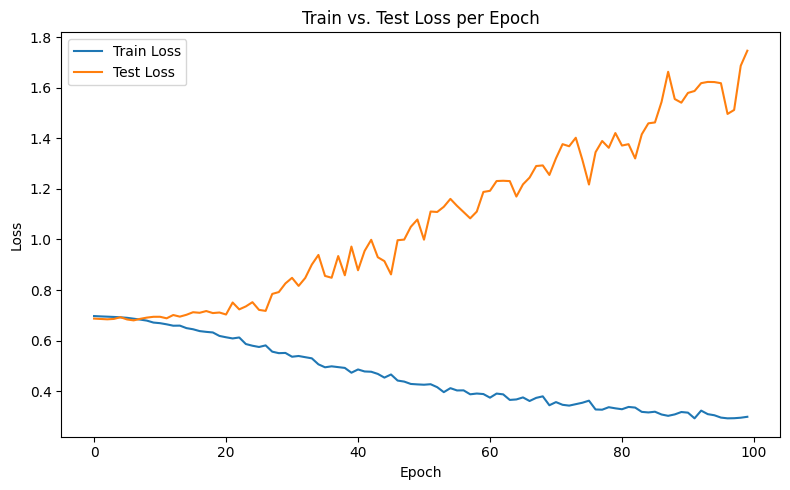

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6926
[Epoch 10/100]  Train Loss: 0.6751
[Epoch 15/100]  Train Loss: 0.6518
[Epoch 20/100]  Train Loss: 0.6119
[Epoch 25/100]  Train Loss: 0.5839
[Epoch 30/100]  Train Loss: 0.5488
[Epoch 35/100]  Train Loss: 0.5255
[Epoch 40/100]  Train Loss: 0.4833
[Epoch 45/100]  Train Loss: 0.4614
[Epoch 50/100]  Train Loss: 0.4515
[Epoch 55/100]  Train Loss: 0.4307
[Epoch 60/100]  Train Loss: 0.4174
[Epoch 65/100]  Train Loss: 0.3858
[Epoch 70/100]  Train Loss: 0.3835
[Epoch 75/100]  Train Loss: 0.3713
[Epoch 80/100]  Train Loss: 0.3425
[Epoch 85/100]  Train Loss: 0.3362
[Epoch 90/100]  Train Loss: 0.3198
[Epoch 95/100]  Train Loss: 0.3287
[Epoch 100/100]  Train Loss: 0.3304
Accuracy on Nonzero Predictions: 0.4504


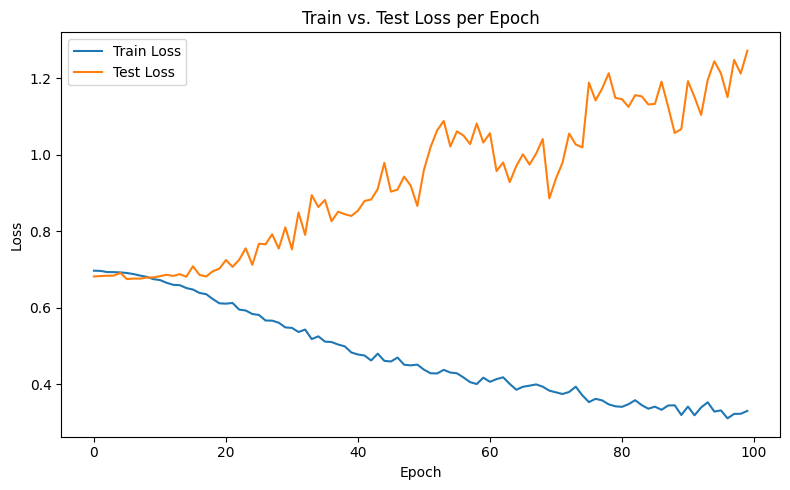

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6929
[Epoch 10/100]  Train Loss: 0.6793
[Epoch 15/100]  Train Loss: 0.6495
[Epoch 20/100]  Train Loss: 0.6198
[Epoch 25/100]  Train Loss: 0.5766
[Epoch 30/100]  Train Loss: 0.5580
[Epoch 35/100]  Train Loss: 0.5082
[Epoch 40/100]  Train Loss: 0.4748
[Epoch 45/100]  Train Loss: 0.4454
[Epoch 50/100]  Train Loss: 0.4084
[Epoch 55/100]  Train Loss: 0.3955
[Epoch 60/100]  Train Loss: 0.3874
[Epoch 65/100]  Train Loss: 0.3652
[Epoch 70/100]  Train Loss: 0.3360
[Epoch 75/100]  Train Loss: 0.3631
[Epoch 80/100]  Train Loss: 0.3306
[Epoch 85/100]  Train Loss: 0.3013
[Epoch 90/100]  Train Loss: 0.2861
[Epoch 95/100]  Train Loss: 0.2707
[Epoch 100/100]  Train Loss: 0.2870
Accuracy on Nonzero Predictions: 0.4962


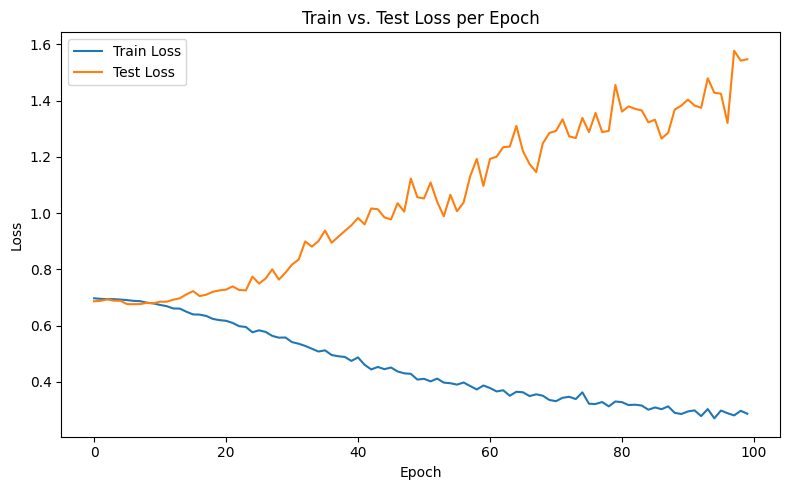

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6931
[Epoch 10/100]  Train Loss: 0.6739
[Epoch 15/100]  Train Loss: 0.6499
[Epoch 20/100]  Train Loss: 0.6170
[Epoch 25/100]  Train Loss: 0.5853
[Epoch 30/100]  Train Loss: 0.5315
[Epoch 35/100]  Train Loss: 0.5125
[Epoch 40/100]  Train Loss: 0.4635
[Epoch 45/100]  Train Loss: 0.4257
[Epoch 50/100]  Train Loss: 0.3891
[Epoch 55/100]  Train Loss: 0.4006
[Epoch 60/100]  Train Loss: 0.3473
[Epoch 65/100]  Train Loss: 0.3471
[Epoch 70/100]  Train Loss: 0.3343
[Epoch 75/100]  Train Loss: 0.3343
[Epoch 80/100]  Train Loss: 0.3213
[Epoch 85/100]  Train Loss: 0.3154
[Epoch 90/100]  Train Loss: 0.2856
[Epoch 95/100]  Train Loss: 0.2772
[Epoch 100/100]  Train Loss: 0.2639
Accuracy on Nonzero Predictions: 0.4809


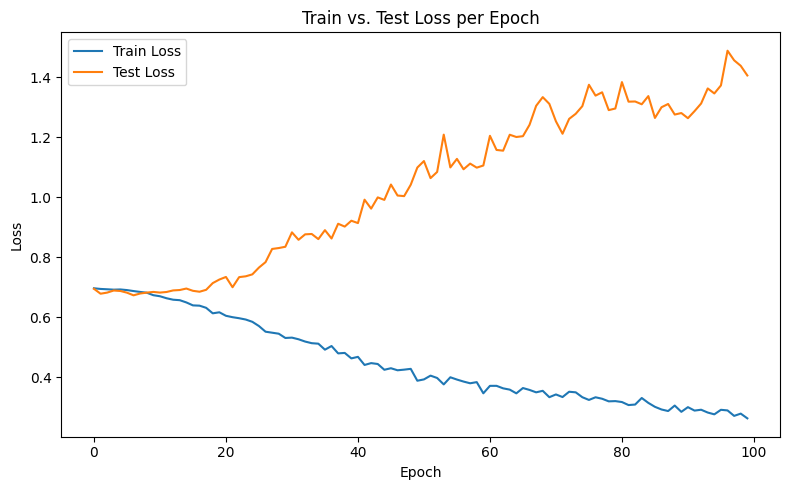

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
----- SECURITY TYPE: single_name, WINDOW SIZE: 50, STOCK: SPX -----
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.4593
[Epoch 10/100]  Train Loss: 0.0813
[Epoch 15/100]  Train Loss: 0.0866
[Epoch 20/100]  Train Loss: 0.0051
[Epoch 25/100]  Train Loss: 0.0026
[Epoch 30/100]  Train Loss: 0.0017
[Epoch 35/100]  Train Loss: 0.0012
[Epoch 40/100]  Train Loss: 0.0009
[Epoch 45/100]  Train Loss: 0.0007
[Epoch 50/100]  Train Loss: 0.0006
[Epoch 55/100]  Train Loss: 0.0005
[Epoch 60/100]  Train Loss: 0.0004
[Epoch 65/100]  Train Loss: 0.0003
[Epoch 70/100]  Train Loss: 0.0003
[Epoch 75/100]  Train Loss: 0.0002
[Epoch 80/100]  Train Loss: 0.0002
[Epoch 85/100]  Train Loss: 0.0002
[Epoch 90/100]  Train Loss: 0.0002
[Epoch 95/100]  Train Loss: 0.0001
[Epoch 100/100]  Train Loss: 0.0001
Accuracy on Nonzero Predictions: 0.4884


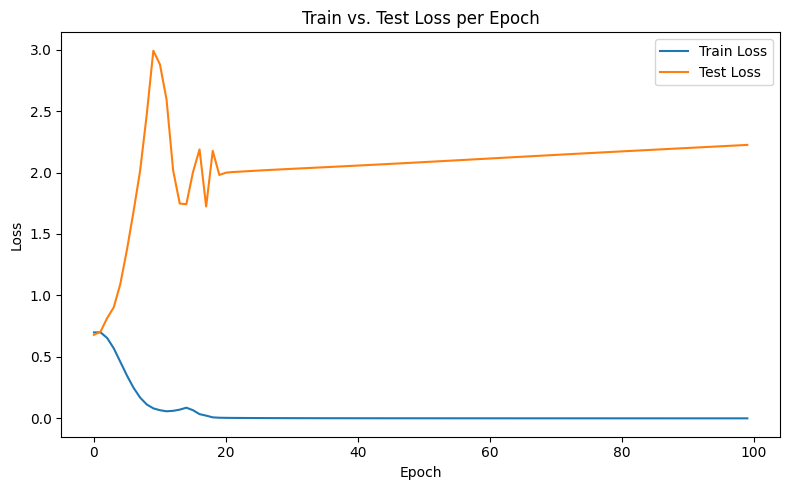

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.4733
[Epoch 10/100]  Train Loss: 0.0884
[Epoch 15/100]  Train Loss: 0.1042
[Epoch 20/100]  Train Loss: 0.0056
[Epoch 25/100]  Train Loss: 0.0029
[Epoch 30/100]  Train Loss: 0.0019
[Epoch 35/100]  Train Loss: 0.0013
[Epoch 40/100]  Train Loss: 0.0010
[Epoch 45/100]  Train Loss: 0.0008
[Epoch 50/100]  Train Loss: 0.0006
[Epoch 55/100]  Train Loss: 0.0005
[Epoch 60/100]  Train Loss: 0.0004
[Epoch 65/100]  Train Loss: 0.0003
[Epoch 70/100]  Train Loss: 0.0003
[Epoch 75/100]  Train Loss: 0.0002
[Epoch 80/100]  Train Loss: 0.0002
[Epoch 85/100]  Train Loss: 0.0002
[Epoch 90/100]  Train Loss: 0.0002
[Epoch 95/100]  Train Loss: 0.0001
[Epoch 100/100]  Train Loss: 0.0001
Accuracy on Nonzero Predictions: 0.4574


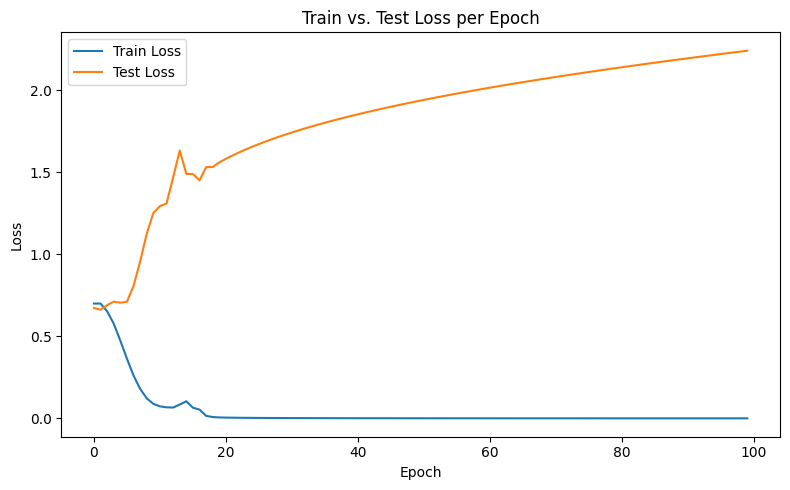

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.4643
[Epoch 10/100]  Train Loss: 0.0834
[Epoch 15/100]  Train Loss: 0.1042
[Epoch 20/100]  Train Loss: 0.0056
[Epoch 25/100]  Train Loss: 0.0028
[Epoch 30/100]  Train Loss: 0.0018
[Epoch 35/100]  Train Loss: 0.0013
[Epoch 40/100]  Train Loss: 0.0010
[Epoch 45/100]  Train Loss: 0.0008
[Epoch 50/100]  Train Loss: 0.0006
[Epoch 55/100]  Train Loss: 0.0005
[Epoch 60/100]  Train Loss: 0.0004
[Epoch 65/100]  Train Loss: 0.0003
[Epoch 70/100]  Train Loss: 0.0003
[Epoch 75/100]  Train Loss: 0.0002
[Epoch 80/100]  Train Loss: 0.0002
[Epoch 85/100]  Train Loss: 0.0002
[Epoch 90/100]  Train Loss: 0.0002
[Epoch 95/100]  Train Loss: 0.0001
[Epoch 100/100]  Train Loss: 0.0001
Accuracy on Nonzero Predictions: 0.4574


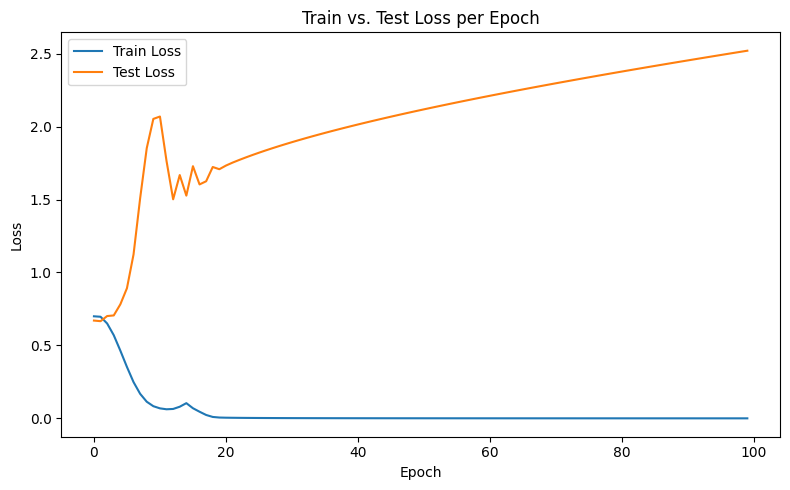

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.4786
[Epoch 10/100]  Train Loss: 0.0851
[Epoch 15/100]  Train Loss: 0.0750
[Epoch 20/100]  Train Loss: 0.0125
[Epoch 25/100]  Train Loss: 0.0025
[Epoch 30/100]  Train Loss: 0.0016
[Epoch 35/100]  Train Loss: 0.0012
[Epoch 40/100]  Train Loss: 0.0009
[Epoch 45/100]  Train Loss: 0.0007
[Epoch 50/100]  Train Loss: 0.0006
[Epoch 55/100]  Train Loss: 0.0005
[Epoch 60/100]  Train Loss: 0.0004
[Epoch 65/100]  Train Loss: 0.0003
[Epoch 70/100]  Train Loss: 0.0003
[Epoch 75/100]  Train Loss: 0.0002
[Epoch 80/100]  Train Loss: 0.0002
[Epoch 85/100]  Train Loss: 0.0002
[Epoch 90/100]  Train Loss: 0.0002
[Epoch 95/100]  Train Loss: 0.0001
[Epoch 100/100]  Train Loss: 0.0001
Accuracy on Nonzero Predictions: 0.4884


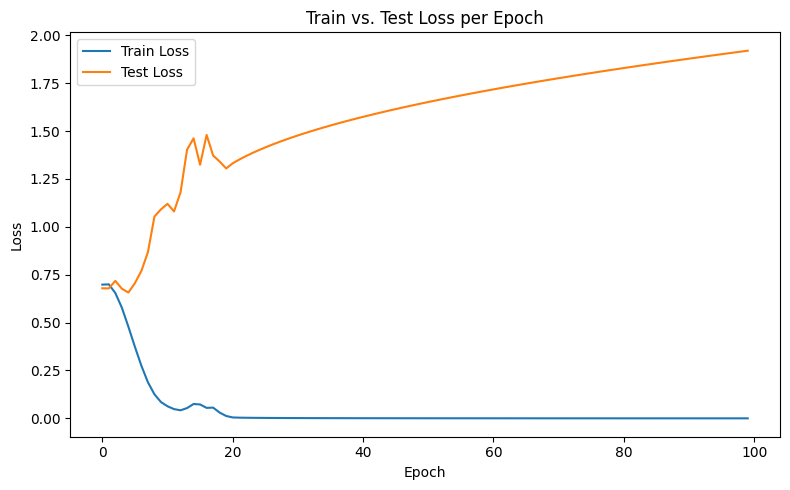

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.4557
[Epoch 10/100]  Train Loss: 0.0732
[Epoch 15/100]  Train Loss: 0.0586
[Epoch 20/100]  Train Loss: 0.0091
[Epoch 25/100]  Train Loss: 0.0024
[Epoch 30/100]  Train Loss: 0.0015
[Epoch 35/100]  Train Loss: 0.0011
[Epoch 40/100]  Train Loss: 0.0008
[Epoch 45/100]  Train Loss: 0.0006
[Epoch 50/100]  Train Loss: 0.0005
[Epoch 55/100]  Train Loss: 0.0004
[Epoch 60/100]  Train Loss: 0.0004
[Epoch 65/100]  Train Loss: 0.0003
[Epoch 70/100]  Train Loss: 0.0003
[Epoch 75/100]  Train Loss: 0.0002
[Epoch 80/100]  Train Loss: 0.0002
[Epoch 85/100]  Train Loss: 0.0002
[Epoch 90/100]  Train Loss: 0.0001
[Epoch 95/100]  Train Loss: 0.0001
[Epoch 100/100]  Train Loss: 0.0001
Accuracy on Nonzero Predictions: 0.4496


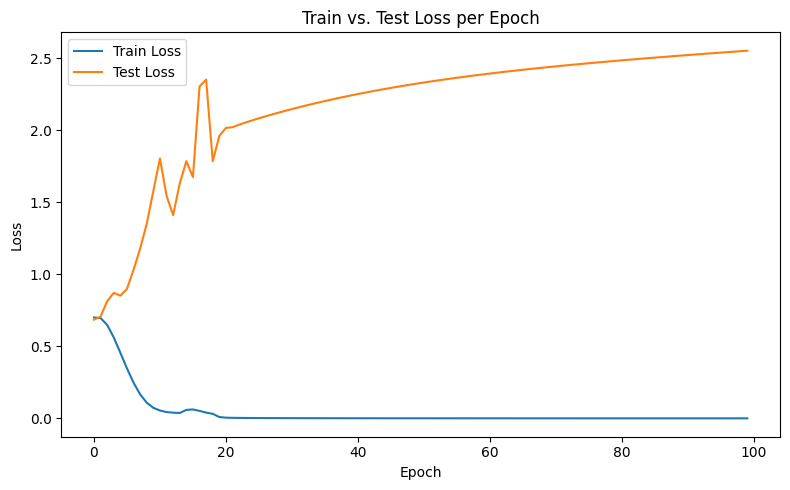

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6705
[Epoch 10/100]  Train Loss: 0.4400
[Epoch 15/100]  Train Loss: 0.2911
[Epoch 20/100]  Train Loss: 0.1800
[Epoch 25/100]  Train Loss: 0.1272
[Epoch 30/100]  Train Loss: 0.1041
[Epoch 35/100]  Train Loss: 0.0908
[Epoch 40/100]  Train Loss: 0.0678
[Epoch 45/100]  Train Loss: 0.0850
[Epoch 50/100]  Train Loss: 0.0627
[Epoch 55/100]  Train Loss: 0.0575
[Epoch 60/100]  Train Loss: 0.0616
[Epoch 65/100]  Train Loss: 0.0604
[Epoch 70/100]  Train Loss: 0.0494
[Epoch 75/100]  Train Loss: 0.0580
[Epoch 80/100]  Train Loss: 0.0473
[Epoch 85/100]  Train Loss: 0.0395
[Epoch 90/100]  Train Loss: 0.0517
[Epoch 95/100]  Train Loss: 0.0342
[Epoch 100/100]  Train Loss: 0.0564
Accuracy on Nonzero Predictions: 0.5039


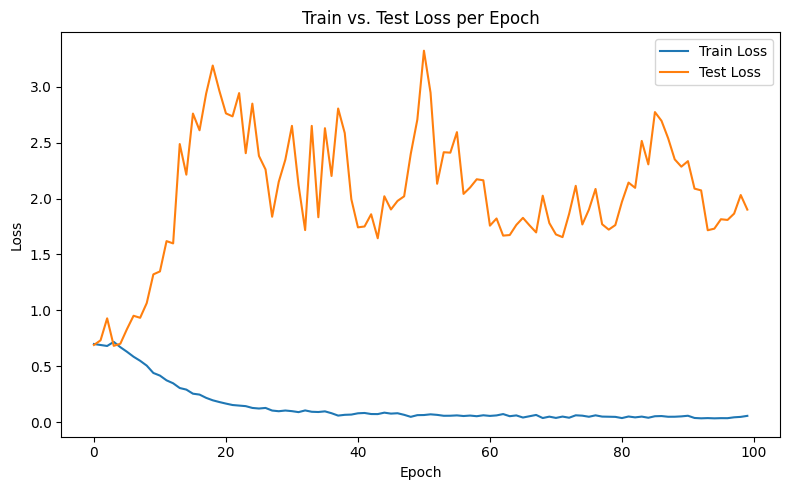

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6753
[Epoch 10/100]  Train Loss: 0.4473
[Epoch 15/100]  Train Loss: 0.2776
[Epoch 20/100]  Train Loss: 0.1713
[Epoch 25/100]  Train Loss: 0.1404
[Epoch 30/100]  Train Loss: 0.0708
[Epoch 35/100]  Train Loss: 0.0860
[Epoch 40/100]  Train Loss: 0.0672
[Epoch 45/100]  Train Loss: 0.0603
[Epoch 50/100]  Train Loss: 0.0625
[Epoch 55/100]  Train Loss: 0.0734
[Epoch 60/100]  Train Loss: 0.0545
[Epoch 65/100]  Train Loss: 0.0577
[Epoch 70/100]  Train Loss: 0.0359
[Epoch 75/100]  Train Loss: 0.0472
[Epoch 80/100]  Train Loss: 0.0429
[Epoch 85/100]  Train Loss: 0.0538
[Epoch 90/100]  Train Loss: 0.0455
[Epoch 95/100]  Train Loss: 0.0396
[Epoch 100/100]  Train Loss: 0.0570
Accuracy on Nonzero Predictions: 0.5116


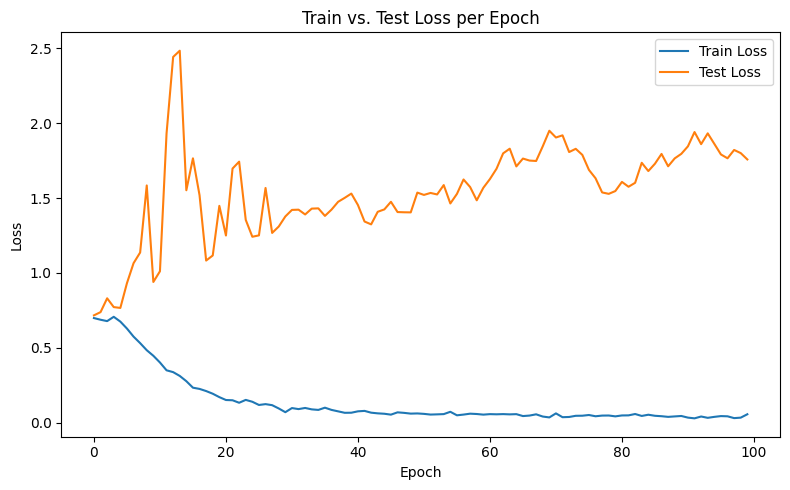

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6736
[Epoch 10/100]  Train Loss: 0.4554
[Epoch 15/100]  Train Loss: 0.2766
[Epoch 20/100]  Train Loss: 0.1871
[Epoch 25/100]  Train Loss: 0.1088
[Epoch 30/100]  Train Loss: 0.0983
[Epoch 35/100]  Train Loss: 0.0728
[Epoch 40/100]  Train Loss: 0.0965
[Epoch 45/100]  Train Loss: 0.0727
[Epoch 50/100]  Train Loss: 0.0623
[Epoch 55/100]  Train Loss: 0.0651
[Epoch 60/100]  Train Loss: 0.0610
[Epoch 65/100]  Train Loss: 0.0497
[Epoch 70/100]  Train Loss: 0.0490
[Epoch 75/100]  Train Loss: 0.0430
[Epoch 80/100]  Train Loss: 0.0492
[Epoch 85/100]  Train Loss: 0.0350
[Epoch 90/100]  Train Loss: 0.0451
[Epoch 95/100]  Train Loss: 0.0528
[Epoch 100/100]  Train Loss: 0.0433
Accuracy on Nonzero Predictions: 0.4884


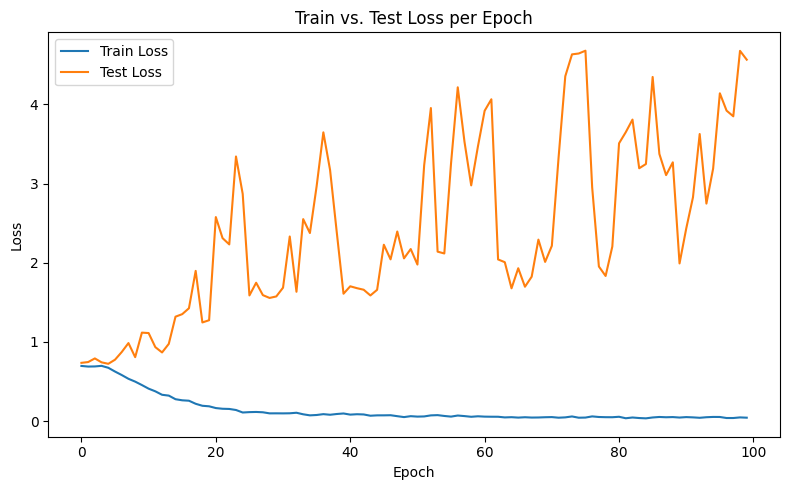

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6654
[Epoch 10/100]  Train Loss: 0.4086
[Epoch 15/100]  Train Loss: 0.2577
[Epoch 20/100]  Train Loss: 0.1652
[Epoch 25/100]  Train Loss: 0.1269
[Epoch 30/100]  Train Loss: 0.0878
[Epoch 35/100]  Train Loss: 0.0801
[Epoch 40/100]  Train Loss: 0.0747
[Epoch 45/100]  Train Loss: 0.0650
[Epoch 50/100]  Train Loss: 0.0623
[Epoch 55/100]  Train Loss: 0.0645
[Epoch 60/100]  Train Loss: 0.0479
[Epoch 65/100]  Train Loss: 0.0620
[Epoch 70/100]  Train Loss: 0.0332
[Epoch 75/100]  Train Loss: 0.0439
[Epoch 80/100]  Train Loss: 0.0387
[Epoch 85/100]  Train Loss: 0.0495
[Epoch 90/100]  Train Loss: 0.0435
[Epoch 95/100]  Train Loss: 0.0482
[Epoch 100/100]  Train Loss: 0.0349
Accuracy on Nonzero Predictions: 0.5271


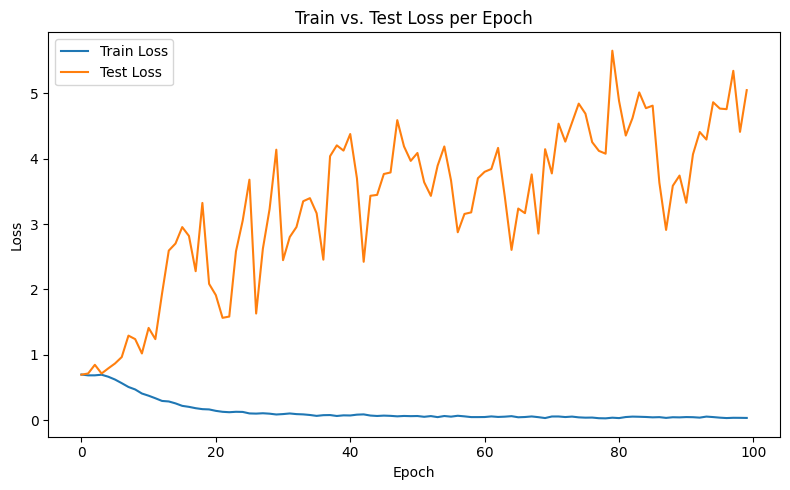

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6798
[Epoch 10/100]  Train Loss: 0.4673
[Epoch 15/100]  Train Loss: 0.3186
[Epoch 20/100]  Train Loss: 0.1819
[Epoch 25/100]  Train Loss: 0.1392
[Epoch 30/100]  Train Loss: 0.0980
[Epoch 35/100]  Train Loss: 0.0816
[Epoch 40/100]  Train Loss: 0.0763
[Epoch 45/100]  Train Loss: 0.0612
[Epoch 50/100]  Train Loss: 0.0623
[Epoch 55/100]  Train Loss: 0.0608
[Epoch 60/100]  Train Loss: 0.0528
[Epoch 65/100]  Train Loss: 0.0666
[Epoch 70/100]  Train Loss: 0.0485
[Epoch 75/100]  Train Loss: 0.0408
[Epoch 80/100]  Train Loss: 0.0470
[Epoch 85/100]  Train Loss: 0.0282
[Epoch 90/100]  Train Loss: 0.0434
[Epoch 95/100]  Train Loss: 0.0525
[Epoch 100/100]  Train Loss: 0.0444
Accuracy on Nonzero Predictions: 0.5736


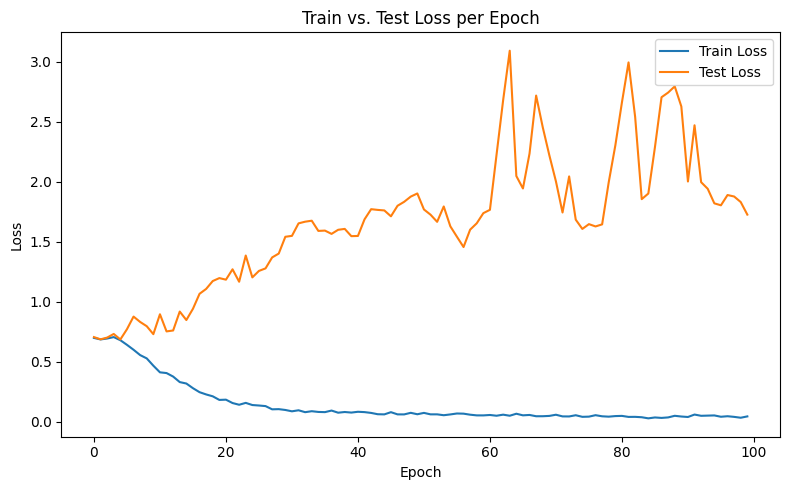

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
----- SECURITY TYPE: single_name, WINDOW SIZE: 100, STOCK: SPX -----
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.1732
[Epoch 10/100]  Train Loss: 0.0165
[Epoch 15/100]  Train Loss: 0.0022
[Epoch 20/100]  Train Loss: 0.0012
[Epoch 25/100]  Train Loss: 0.0008
[Epoch 30/100]  Train Loss: 0.0006
[Epoch 35/100]  Train Loss: 0.0004
[Epoch 40/100]  Train Loss: 0.0003
[Epoch 45/100]  Train Loss: 0.0003
[Epoch 50/100]  Train Loss: 0.0002
[Epoch 55/100]  Train Loss: 0.0002
[Epoch 60/100]  Train Loss: 0.0001
[Epoch 65/100]  Train Loss: 0.0001
[Epoch 70/100]  Train Loss: 0.0001
[Epoch 75/100]  Train Loss: 0.0001
[Epoch 80/100]  Train Loss: 0.0001
[Epoch 85/100]  Train Loss: 0.0001
[Epoch 90/100]  Train Loss: 0.0001
[Epoch 95/100]  Train Loss: 0.0000
[Epoch 100/100]  Train Loss: 0.0000
Accuracy on Nonzero Predictions: 0.5397


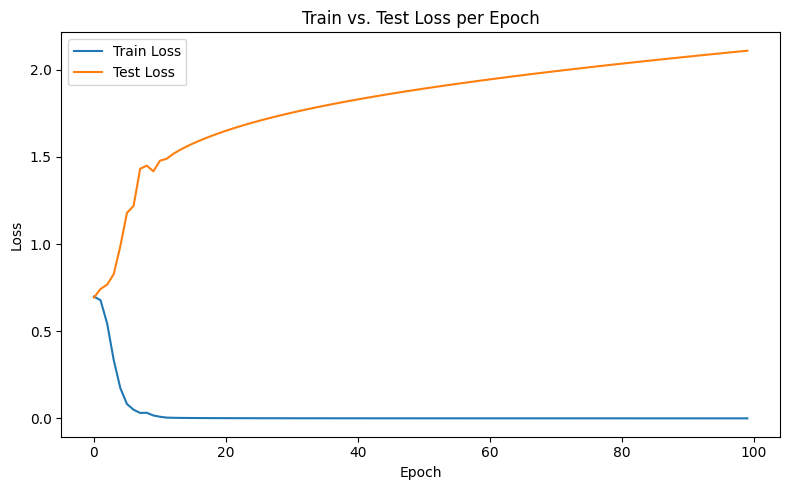

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.1757
[Epoch 10/100]  Train Loss: 0.0096
[Epoch 15/100]  Train Loss: 0.0023
[Epoch 20/100]  Train Loss: 0.0013
[Epoch 25/100]  Train Loss: 0.0008
[Epoch 30/100]  Train Loss: 0.0006
[Epoch 35/100]  Train Loss: 0.0004
[Epoch 40/100]  Train Loss: 0.0003
[Epoch 45/100]  Train Loss: 0.0003
[Epoch 50/100]  Train Loss: 0.0002
[Epoch 55/100]  Train Loss: 0.0002
[Epoch 60/100]  Train Loss: 0.0001
[Epoch 65/100]  Train Loss: 0.0001
[Epoch 70/100]  Train Loss: 0.0001
[Epoch 75/100]  Train Loss: 0.0001
[Epoch 80/100]  Train Loss: 0.0001
[Epoch 85/100]  Train Loss: 0.0001
[Epoch 90/100]  Train Loss: 0.0001
[Epoch 95/100]  Train Loss: 0.0000
[Epoch 100/100]  Train Loss: 0.0000
Accuracy on Nonzero Predictions: 0.5000


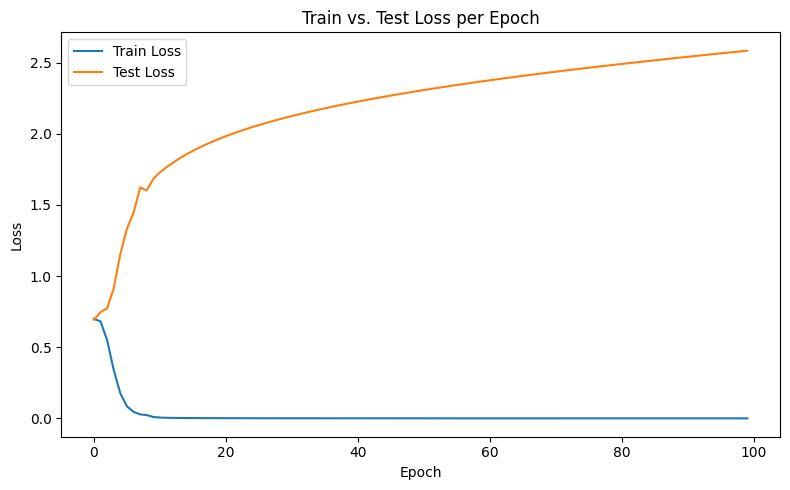

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.1754
[Epoch 10/100]  Train Loss: 0.0102
[Epoch 15/100]  Train Loss: 0.0023
[Epoch 20/100]  Train Loss: 0.0013
[Epoch 25/100]  Train Loss: 0.0008
[Epoch 30/100]  Train Loss: 0.0006
[Epoch 35/100]  Train Loss: 0.0004
[Epoch 40/100]  Train Loss: 0.0003
[Epoch 45/100]  Train Loss: 0.0003
[Epoch 50/100]  Train Loss: 0.0002
[Epoch 55/100]  Train Loss: 0.0002
[Epoch 60/100]  Train Loss: 0.0001
[Epoch 65/100]  Train Loss: 0.0001
[Epoch 70/100]  Train Loss: 0.0001
[Epoch 75/100]  Train Loss: 0.0001
[Epoch 80/100]  Train Loss: 0.0001
[Epoch 85/100]  Train Loss: 0.0001
[Epoch 90/100]  Train Loss: 0.0001
[Epoch 95/100]  Train Loss: 0.0000
[Epoch 100/100]  Train Loss: 0.0000
Accuracy on Nonzero Predictions: 0.5476


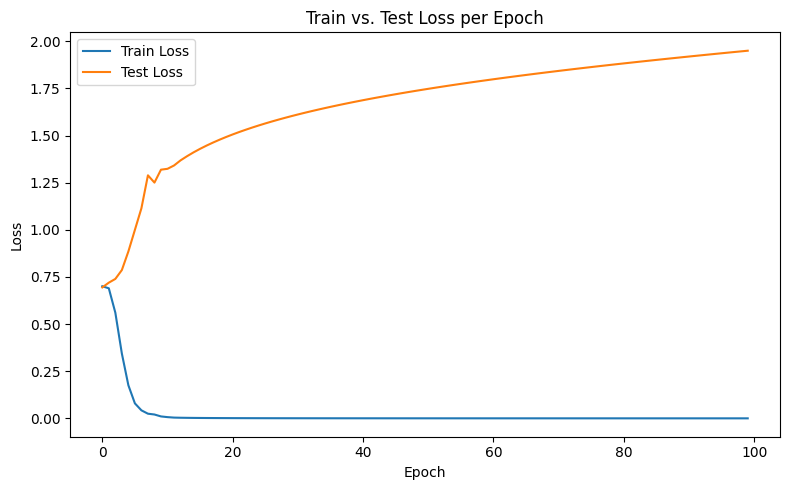

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.1490
[Epoch 10/100]  Train Loss: 0.0074
[Epoch 15/100]  Train Loss: 0.0022
[Epoch 20/100]  Train Loss: 0.0013
[Epoch 25/100]  Train Loss: 0.0008
[Epoch 30/100]  Train Loss: 0.0006
[Epoch 35/100]  Train Loss: 0.0004
[Epoch 40/100]  Train Loss: 0.0003
[Epoch 45/100]  Train Loss: 0.0003
[Epoch 50/100]  Train Loss: 0.0002
[Epoch 55/100]  Train Loss: 0.0002
[Epoch 60/100]  Train Loss: 0.0001
[Epoch 65/100]  Train Loss: 0.0001
[Epoch 70/100]  Train Loss: 0.0001
[Epoch 75/100]  Train Loss: 0.0001
[Epoch 80/100]  Train Loss: 0.0001
[Epoch 85/100]  Train Loss: 0.0001
[Epoch 90/100]  Train Loss: 0.0001
[Epoch 95/100]  Train Loss: 0.0000
[Epoch 100/100]  Train Loss: 0.0000
Accuracy on Nonzero Predictions: 0.5000


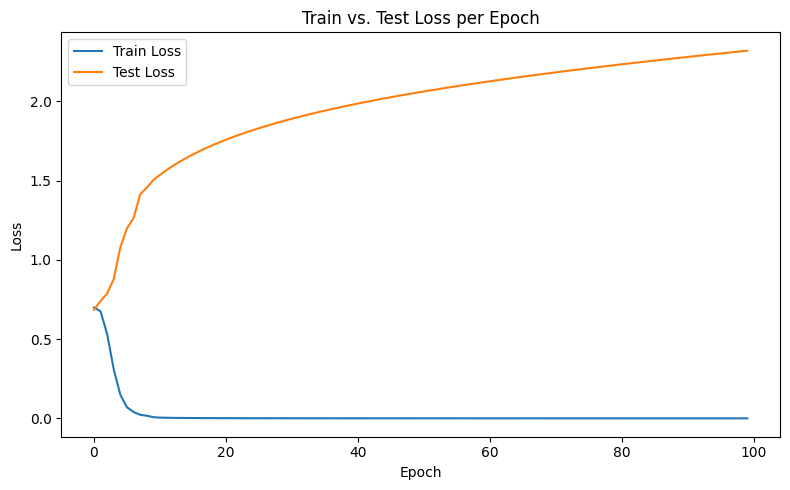

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.1711
[Epoch 10/100]  Train Loss: 0.0096
[Epoch 15/100]  Train Loss: 0.0025
[Epoch 20/100]  Train Loss: 0.0014
[Epoch 25/100]  Train Loss: 0.0009
[Epoch 30/100]  Train Loss: 0.0006
[Epoch 35/100]  Train Loss: 0.0004
[Epoch 40/100]  Train Loss: 0.0003
[Epoch 45/100]  Train Loss: 0.0003
[Epoch 50/100]  Train Loss: 0.0002
[Epoch 55/100]  Train Loss: 0.0002
[Epoch 60/100]  Train Loss: 0.0001
[Epoch 65/100]  Train Loss: 0.0001
[Epoch 70/100]  Train Loss: 0.0001
[Epoch 75/100]  Train Loss: 0.0001
[Epoch 80/100]  Train Loss: 0.0001
[Epoch 85/100]  Train Loss: 0.0001
[Epoch 90/100]  Train Loss: 0.0001
[Epoch 95/100]  Train Loss: 0.0000
[Epoch 100/100]  Train Loss: 0.0000
Accuracy on Nonzero Predictions: 0.5397


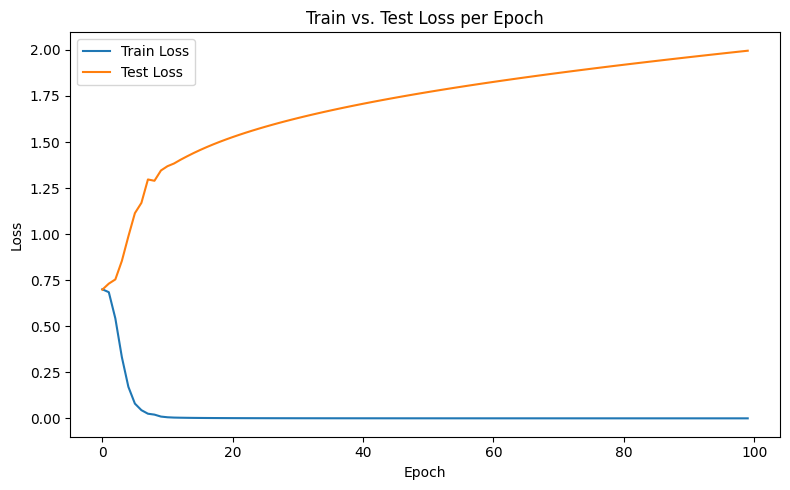

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6182
[Epoch 10/100]  Train Loss: 0.2263
[Epoch 15/100]  Train Loss: 0.1104
[Epoch 20/100]  Train Loss: 0.0742
[Epoch 25/100]  Train Loss: 0.0505
[Epoch 30/100]  Train Loss: 0.0419
[Epoch 35/100]  Train Loss: 0.0409
[Epoch 40/100]  Train Loss: 0.0454
[Epoch 45/100]  Train Loss: 0.0348
[Epoch 50/100]  Train Loss: 0.0325
[Epoch 55/100]  Train Loss: 0.0324
[Epoch 60/100]  Train Loss: 0.0326
[Epoch 65/100]  Train Loss: 0.0340
[Epoch 70/100]  Train Loss: 0.0305
[Epoch 75/100]  Train Loss: 0.0260
[Epoch 80/100]  Train Loss: 0.0185
[Epoch 85/100]  Train Loss: 0.0253
[Epoch 90/100]  Train Loss: 0.0235
[Epoch 95/100]  Train Loss: 0.0264
[Epoch 100/100]  Train Loss: 0.0197
Accuracy on Nonzero Predictions: 0.5397


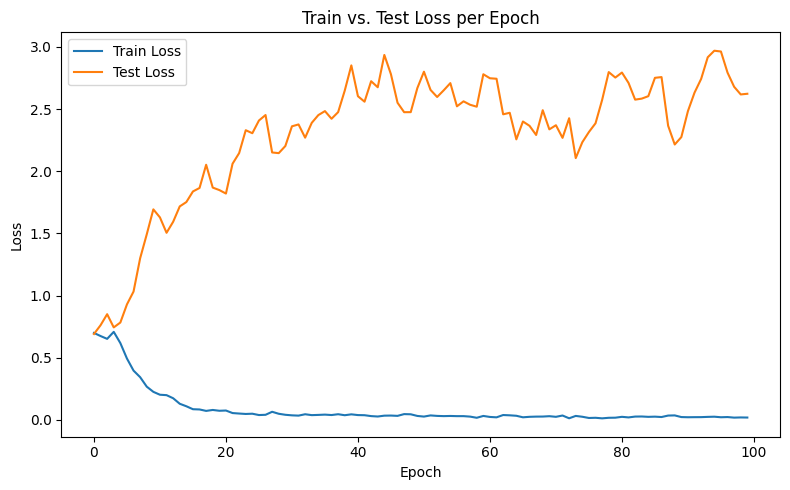

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6471
[Epoch 10/100]  Train Loss: 0.2384
[Epoch 15/100]  Train Loss: 0.1281
[Epoch 20/100]  Train Loss: 0.0601
[Epoch 25/100]  Train Loss: 0.0571
[Epoch 30/100]  Train Loss: 0.0551
[Epoch 35/100]  Train Loss: 0.0320
[Epoch 40/100]  Train Loss: 0.0308
[Epoch 45/100]  Train Loss: 0.0305
[Epoch 50/100]  Train Loss: 0.0290
[Epoch 55/100]  Train Loss: 0.0289
[Epoch 60/100]  Train Loss: 0.0341
[Epoch 65/100]  Train Loss: 0.0292
[Epoch 70/100]  Train Loss: 0.0233
[Epoch 75/100]  Train Loss: 0.0232
[Epoch 80/100]  Train Loss: 0.0164
[Epoch 85/100]  Train Loss: 0.0267
[Epoch 90/100]  Train Loss: 0.0346
[Epoch 95/100]  Train Loss: 0.0244
[Epoch 100/100]  Train Loss: 0.0313
Accuracy on Nonzero Predictions: 0.4921


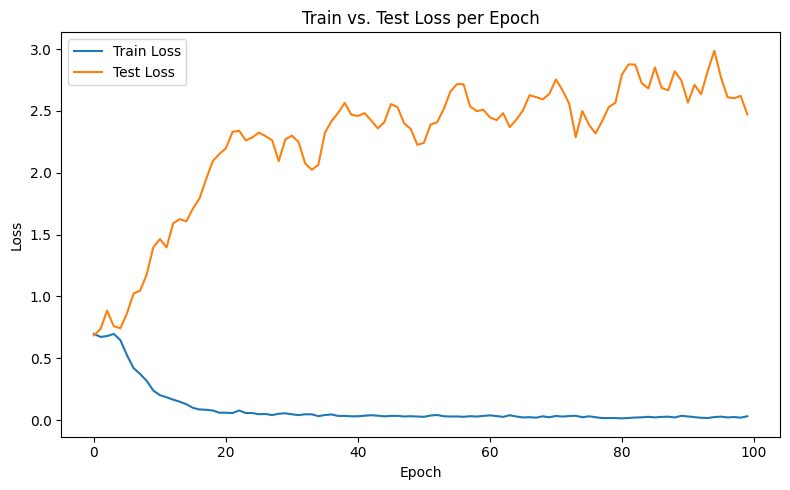

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6417
[Epoch 10/100]  Train Loss: 0.2483
[Epoch 15/100]  Train Loss: 0.1050
[Epoch 20/100]  Train Loss: 0.0607
[Epoch 25/100]  Train Loss: 0.0453
[Epoch 30/100]  Train Loss: 0.0570
[Epoch 35/100]  Train Loss: 0.0442
[Epoch 40/100]  Train Loss: 0.0314
[Epoch 45/100]  Train Loss: 0.0338
[Epoch 50/100]  Train Loss: 0.0320
[Epoch 55/100]  Train Loss: 0.0500
[Epoch 60/100]  Train Loss: 0.0276
[Epoch 65/100]  Train Loss: 0.0245
[Epoch 70/100]  Train Loss: 0.0269
[Epoch 75/100]  Train Loss: 0.0177
[Epoch 80/100]  Train Loss: 0.0310
[Epoch 85/100]  Train Loss: 0.0293
[Epoch 90/100]  Train Loss: 0.0261
[Epoch 95/100]  Train Loss: 0.0278
[Epoch 100/100]  Train Loss: 0.0216
Accuracy on Nonzero Predictions: 0.5079


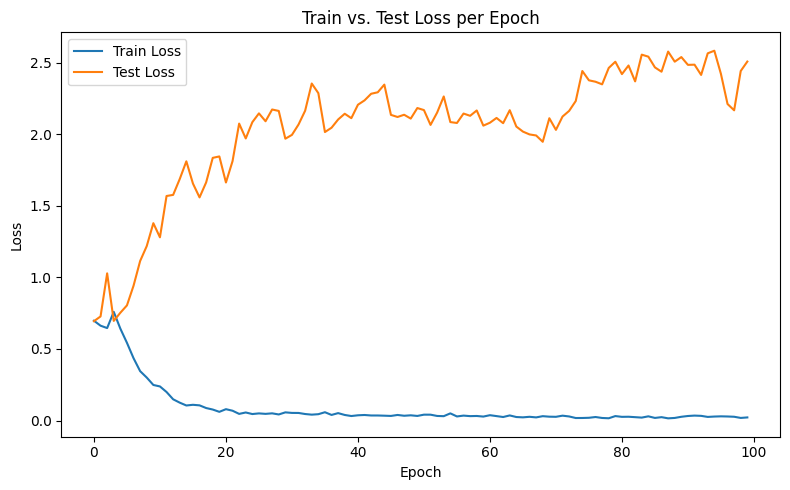

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6471
[Epoch 10/100]  Train Loss: 0.2362
[Epoch 15/100]  Train Loss: 0.1207
[Epoch 20/100]  Train Loss: 0.0652
[Epoch 25/100]  Train Loss: 0.0503
[Epoch 30/100]  Train Loss: 0.0477
[Epoch 35/100]  Train Loss: 0.0366
[Epoch 40/100]  Train Loss: 0.0322
[Epoch 45/100]  Train Loss: 0.0332
[Epoch 50/100]  Train Loss: 0.0434
[Epoch 55/100]  Train Loss: 0.0305
[Epoch 60/100]  Train Loss: 0.0365
[Epoch 65/100]  Train Loss: 0.0260
[Epoch 70/100]  Train Loss: 0.0267
[Epoch 75/100]  Train Loss: 0.0231
[Epoch 80/100]  Train Loss: 0.0234
[Epoch 85/100]  Train Loss: 0.0141
[Epoch 90/100]  Train Loss: 0.0234
[Epoch 95/100]  Train Loss: 0.0198
[Epoch 100/100]  Train Loss: 0.0188
Accuracy on Nonzero Predictions: 0.5714


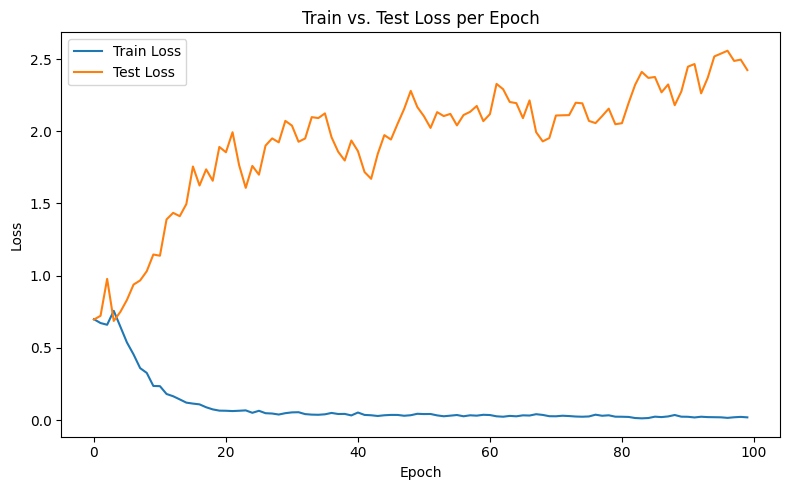

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6312
[Epoch 10/100]  Train Loss: 0.2597
[Epoch 15/100]  Train Loss: 0.1367
[Epoch 20/100]  Train Loss: 0.0615
[Epoch 25/100]  Train Loss: 0.0620
[Epoch 30/100]  Train Loss: 0.0611
[Epoch 35/100]  Train Loss: 0.0402
[Epoch 40/100]  Train Loss: 0.0336
[Epoch 45/100]  Train Loss: 0.0368
[Epoch 50/100]  Train Loss: 0.0263
[Epoch 55/100]  Train Loss: 0.0290
[Epoch 60/100]  Train Loss: 0.0291
[Epoch 65/100]  Train Loss: 0.0331
[Epoch 70/100]  Train Loss: 0.0302
[Epoch 75/100]  Train Loss: 0.0197
[Epoch 80/100]  Train Loss: 0.0274
[Epoch 85/100]  Train Loss: 0.0204
[Epoch 90/100]  Train Loss: 0.0178
[Epoch 95/100]  Train Loss: 0.0242
[Epoch 100/100]  Train Loss: 0.0201
Accuracy on Nonzero Predictions: 0.5079


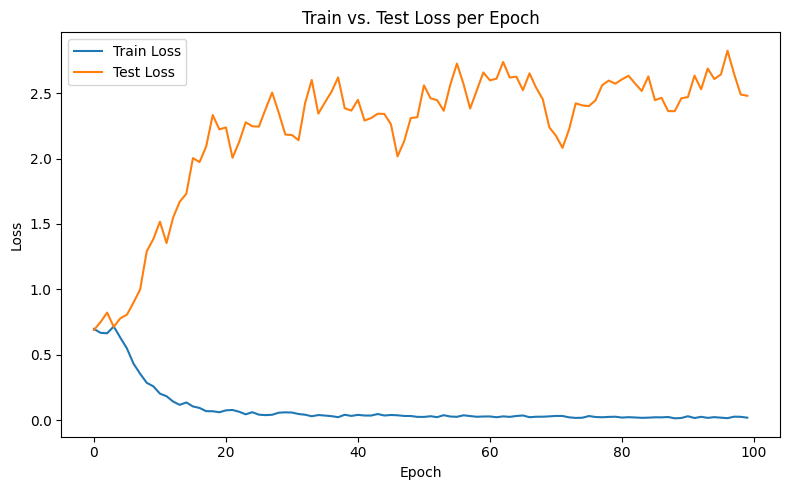

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
----- SECURITY TYPE: options, WINDOW SIZE: 5, STOCK: SPX -----
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6923
[Epoch 10/100]  Train Loss: 0.6806
[Epoch 15/100]  Train Loss: 0.6245
[Epoch 20/100]  Train Loss: 0.5385
[Epoch 25/100]  Train Loss: 0.3673
[Epoch 30/100]  Train Loss: 0.2628
[Epoch 35/100]  Train Loss: 0.1459
[Epoch 40/100]  Train Loss: 0.1418
[Epoch 45/100]  Train Loss: 0.1033
[Epoch 50/100]  Train Loss: 0.0496
[Epoch 55/100]  Train Loss: 0.0531
[Epoch 60/100]  Train Loss: 0.0739
[Epoch 65/100]  Train Loss: 0.0329
[Epoch 70/100]  Train Loss: 0.0547
[Epoch 75/100]  Train Loss: 0.0245
[Epoch 80/100]  Train Loss: 0.0058
[Epoch 85/100]  Train Loss: 0.0015
[Epoch 90/100]  Train Loss: 0.0009
[Epoch 95/100]  Train Loss: 0.0007
[Epoch 100/100]  Train Loss: 0.0005
Accuracy on Nonzero Predictions: 0.5267


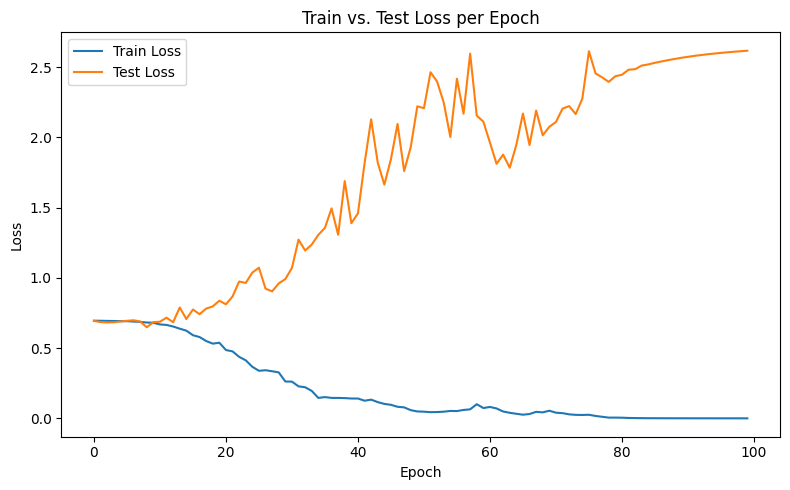

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6922
[Epoch 10/100]  Train Loss: 0.6769
[Epoch 15/100]  Train Loss: 0.6126
[Epoch 20/100]  Train Loss: 0.5048
[Epoch 25/100]  Train Loss: 0.4127
[Epoch 30/100]  Train Loss: 0.2980
[Epoch 35/100]  Train Loss: 0.2085
[Epoch 40/100]  Train Loss: 0.1383
[Epoch 45/100]  Train Loss: 0.1370
[Epoch 50/100]  Train Loss: 0.0805
[Epoch 55/100]  Train Loss: 0.0658
[Epoch 60/100]  Train Loss: 0.1278
[Epoch 65/100]  Train Loss: 0.0544
[Epoch 70/100]  Train Loss: 0.0354
[Epoch 75/100]  Train Loss: 0.0267
[Epoch 80/100]  Train Loss: 0.0800
[Epoch 85/100]  Train Loss: 0.0828
[Epoch 90/100]  Train Loss: 0.0772
[Epoch 95/100]  Train Loss: 0.0135
[Epoch 100/100]  Train Loss: 0.0160
Accuracy on Nonzero Predictions: 0.5954


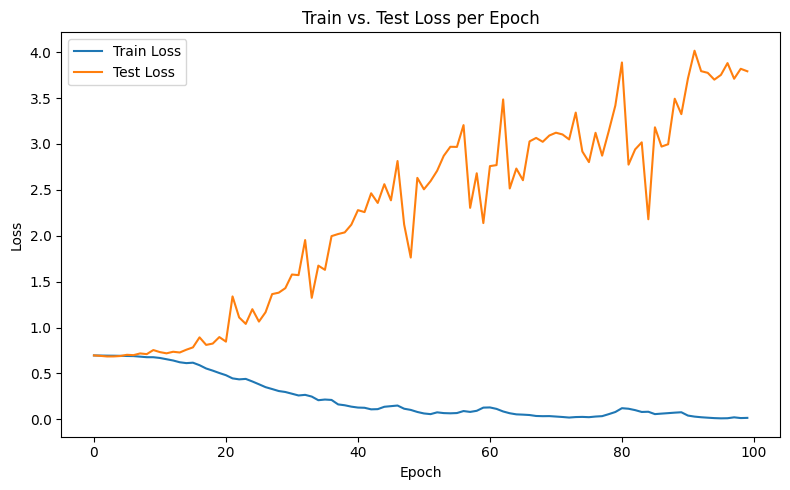

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6925
[Epoch 10/100]  Train Loss: 0.6813
[Epoch 15/100]  Train Loss: 0.6249
[Epoch 20/100]  Train Loss: 0.5058
[Epoch 25/100]  Train Loss: 0.3791
[Epoch 30/100]  Train Loss: 0.2561
[Epoch 35/100]  Train Loss: 0.1320
[Epoch 40/100]  Train Loss: 0.1311
[Epoch 45/100]  Train Loss: 0.0516
[Epoch 50/100]  Train Loss: 0.0679
[Epoch 55/100]  Train Loss: 0.0426
[Epoch 60/100]  Train Loss: 0.0636
[Epoch 65/100]  Train Loss: 0.1025
[Epoch 70/100]  Train Loss: 0.0204
[Epoch 75/100]  Train Loss: 0.0165
[Epoch 80/100]  Train Loss: 0.0132
[Epoch 85/100]  Train Loss: 0.0173
[Epoch 90/100]  Train Loss: 0.0076
[Epoch 95/100]  Train Loss: 0.0509
[Epoch 100/100]  Train Loss: 0.1313
Accuracy on Nonzero Predictions: 0.5420


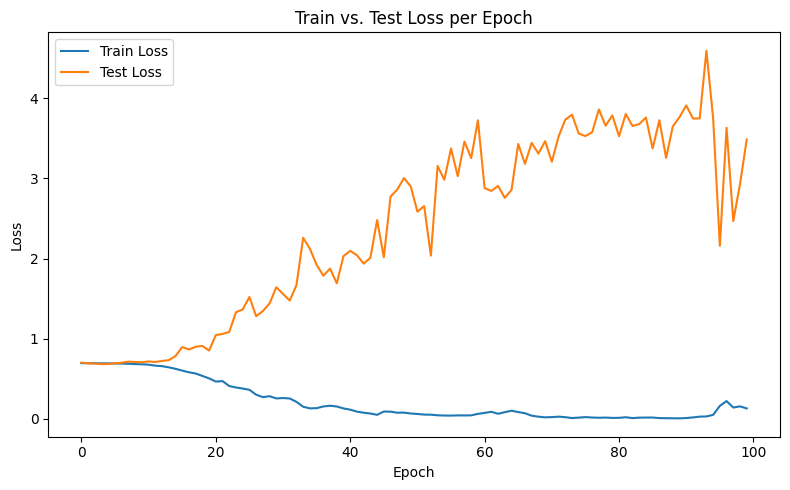

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6897
[Epoch 10/100]  Train Loss: 0.6715
[Epoch 15/100]  Train Loss: 0.6143
[Epoch 20/100]  Train Loss: 0.5607
[Epoch 25/100]  Train Loss: 0.3895
[Epoch 30/100]  Train Loss: 0.2704
[Epoch 35/100]  Train Loss: 0.1819
[Epoch 40/100]  Train Loss: 0.1513
[Epoch 45/100]  Train Loss: 0.0800
[Epoch 50/100]  Train Loss: 0.0415
[Epoch 55/100]  Train Loss: 0.0963
[Epoch 60/100]  Train Loss: 0.0285
[Epoch 65/100]  Train Loss: 0.0331
[Epoch 70/100]  Train Loss: 0.0850
[Epoch 75/100]  Train Loss: 0.0716
[Epoch 80/100]  Train Loss: 0.0192
[Epoch 85/100]  Train Loss: 0.0063
[Epoch 90/100]  Train Loss: 0.0050
[Epoch 95/100]  Train Loss: 0.0065
[Epoch 100/100]  Train Loss: 0.1324
Accuracy on Nonzero Predictions: 0.5725


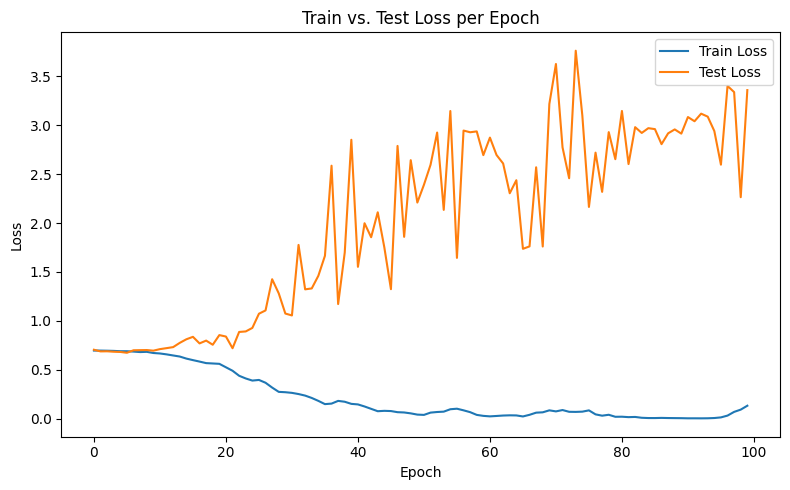

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6922
[Epoch 10/100]  Train Loss: 0.6681
[Epoch 15/100]  Train Loss: 0.6112
[Epoch 20/100]  Train Loss: 0.5295
[Epoch 25/100]  Train Loss: 0.4121
[Epoch 30/100]  Train Loss: 0.2673
[Epoch 35/100]  Train Loss: 0.1970
[Epoch 40/100]  Train Loss: 0.1474
[Epoch 45/100]  Train Loss: 0.1663
[Epoch 50/100]  Train Loss: 0.0662
[Epoch 55/100]  Train Loss: 0.0453
[Epoch 60/100]  Train Loss: 0.0716
[Epoch 65/100]  Train Loss: 0.1581
[Epoch 70/100]  Train Loss: 0.0329
[Epoch 75/100]  Train Loss: 0.0223
[Epoch 80/100]  Train Loss: 0.0180
[Epoch 85/100]  Train Loss: 0.0175
[Epoch 90/100]  Train Loss: 0.0233
[Epoch 95/100]  Train Loss: 0.1773
[Epoch 100/100]  Train Loss: 0.1182
Accuracy on Nonzero Predictions: 0.4962


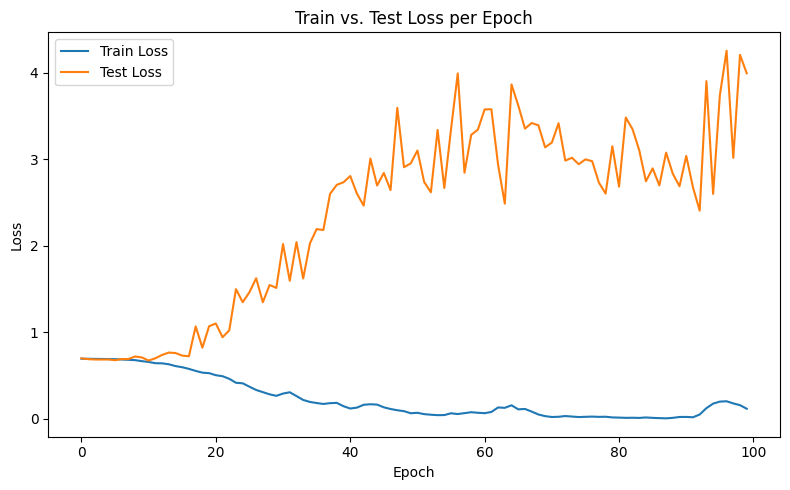

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6909
[Epoch 10/100]  Train Loss: 0.7034
[Epoch 15/100]  Train Loss: 0.6928
[Epoch 20/100]  Train Loss: 0.6849
[Epoch 25/100]  Train Loss: 0.6580
[Epoch 30/100]  Train Loss: 0.6451
[Epoch 35/100]  Train Loss: 0.5905
[Epoch 40/100]  Train Loss: 0.6041
[Epoch 45/100]  Train Loss: 0.5678
[Epoch 50/100]  Train Loss: 0.5144
[Epoch 55/100]  Train Loss: 0.4922
[Epoch 60/100]  Train Loss: 0.5012
[Epoch 65/100]  Train Loss: 0.4876
[Epoch 70/100]  Train Loss: 0.4621
[Epoch 75/100]  Train Loss: 0.4022
[Epoch 80/100]  Train Loss: 0.3722
[Epoch 85/100]  Train Loss: 0.3682
[Epoch 90/100]  Train Loss: 0.3547
[Epoch 95/100]  Train Loss: 0.3515
[Epoch 100/100]  Train Loss: 0.3437
Accuracy on Nonzero Predictions: 0.5878


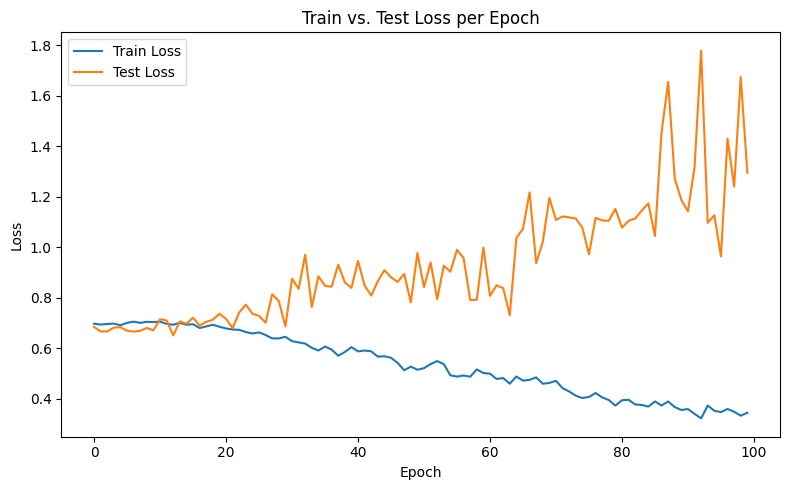

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6967
[Epoch 10/100]  Train Loss: 0.6906
[Epoch 15/100]  Train Loss: 0.6978
[Epoch 20/100]  Train Loss: 0.6957
[Epoch 25/100]  Train Loss: 0.6862
[Epoch 30/100]  Train Loss: 0.6840
[Epoch 35/100]  Train Loss: 0.6819
[Epoch 40/100]  Train Loss: 0.6742
[Epoch 45/100]  Train Loss: 0.6746
[Epoch 50/100]  Train Loss: 0.6695
[Epoch 55/100]  Train Loss: 0.6559
[Epoch 60/100]  Train Loss: 0.6486
[Epoch 65/100]  Train Loss: 0.6233
[Epoch 70/100]  Train Loss: 0.6011
[Epoch 75/100]  Train Loss: 0.6021
[Epoch 80/100]  Train Loss: 0.5916
[Epoch 85/100]  Train Loss: 0.5905
[Epoch 90/100]  Train Loss: 0.5775
[Epoch 95/100]  Train Loss: 0.5805
[Epoch 100/100]  Train Loss: 0.5437
Accuracy on Nonzero Predictions: 0.5649


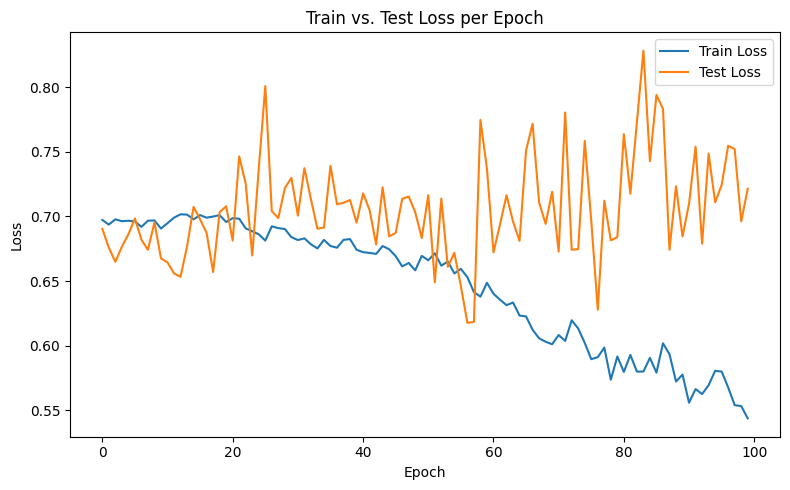

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6953
[Epoch 10/100]  Train Loss: 0.6989
[Epoch 15/100]  Train Loss: 0.6939
[Epoch 20/100]  Train Loss: 0.7005
[Epoch 25/100]  Train Loss: 0.6939
[Epoch 30/100]  Train Loss: 0.7034
[Epoch 35/100]  Train Loss: 0.6999
[Epoch 40/100]  Train Loss: 0.6981
[Epoch 45/100]  Train Loss: 0.6994
[Epoch 50/100]  Train Loss: 0.6900
[Epoch 55/100]  Train Loss: 0.6891
[Epoch 60/100]  Train Loss: 0.6798
[Epoch 65/100]  Train Loss: 0.6685
[Epoch 70/100]  Train Loss: 0.6847
[Epoch 75/100]  Train Loss: 0.6718
[Epoch 80/100]  Train Loss: 0.6534
[Epoch 85/100]  Train Loss: 0.6801
[Epoch 90/100]  Train Loss: 0.6719
[Epoch 95/100]  Train Loss: 0.6625
[Epoch 100/100]  Train Loss: 0.6612
Accuracy on Nonzero Predictions: 0.4351


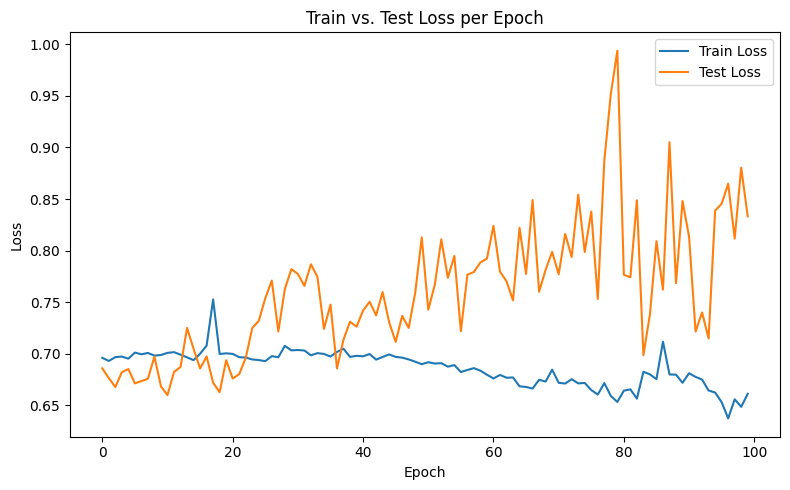

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.7011
[Epoch 10/100]  Train Loss: 0.6936
[Epoch 15/100]  Train Loss: 0.6823
[Epoch 20/100]  Train Loss: 0.6745
[Epoch 25/100]  Train Loss: 0.6627
[Epoch 30/100]  Train Loss: 0.6696
[Epoch 35/100]  Train Loss: 0.6699
[Epoch 40/100]  Train Loss: 0.6469
[Epoch 45/100]  Train Loss: 0.6539
[Epoch 50/100]  Train Loss: 0.6398
[Epoch 55/100]  Train Loss: 0.6059
[Epoch 60/100]  Train Loss: 0.5992
[Epoch 65/100]  Train Loss: 0.5636
[Epoch 70/100]  Train Loss: 0.5961
[Epoch 75/100]  Train Loss: 0.5687
[Epoch 80/100]  Train Loss: 0.5558
[Epoch 85/100]  Train Loss: 0.5088
[Epoch 90/100]  Train Loss: 0.4904
[Epoch 95/100]  Train Loss: 0.5421
[Epoch 100/100]  Train Loss: 0.5099
Accuracy on Nonzero Predictions: 0.6183


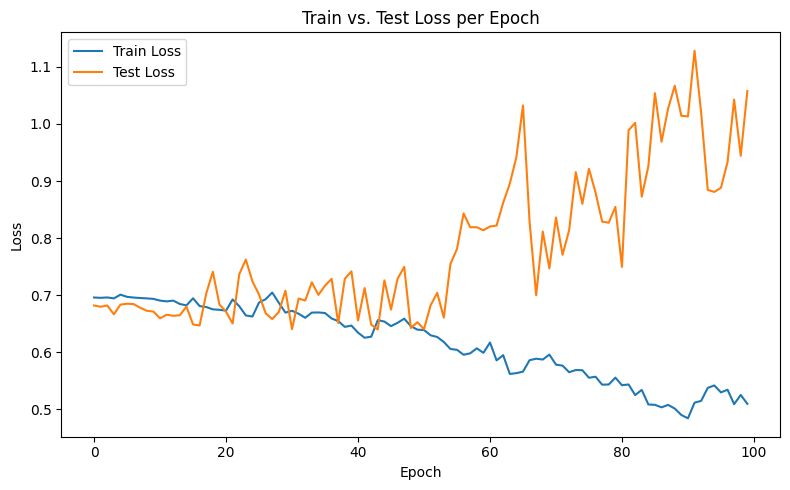

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6964
[Epoch 10/100]  Train Loss: 0.6998
[Epoch 15/100]  Train Loss: 0.6856
[Epoch 20/100]  Train Loss: 0.6761
[Epoch 25/100]  Train Loss: 0.6569
[Epoch 30/100]  Train Loss: 0.6274
[Epoch 35/100]  Train Loss: 0.6180
[Epoch 40/100]  Train Loss: 0.6042
[Epoch 45/100]  Train Loss: 0.5673
[Epoch 50/100]  Train Loss: 0.5271
[Epoch 55/100]  Train Loss: 0.5096
[Epoch 60/100]  Train Loss: 0.4979
[Epoch 65/100]  Train Loss: 0.4574
[Epoch 70/100]  Train Loss: 0.4481
[Epoch 75/100]  Train Loss: 0.4153
[Epoch 80/100]  Train Loss: 0.3907
[Epoch 85/100]  Train Loss: 0.4350
[Epoch 90/100]  Train Loss: 0.3984
[Epoch 95/100]  Train Loss: 0.3800
[Epoch 100/100]  Train Loss: 0.3866
Accuracy on Nonzero Predictions: 0.5725


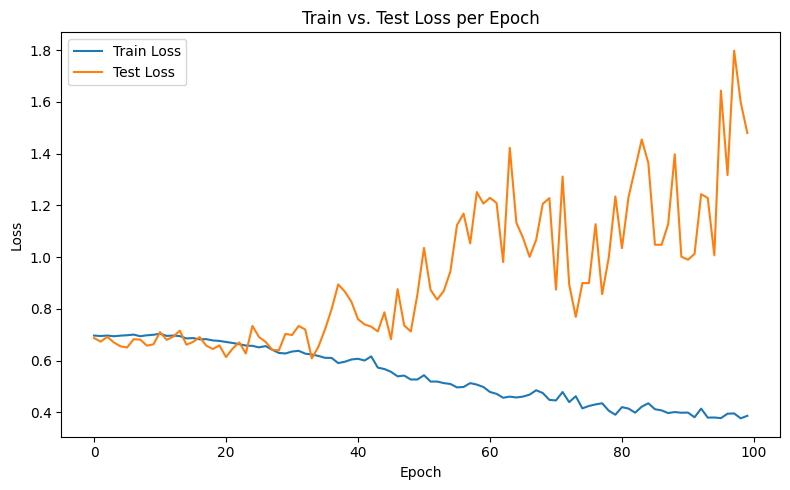

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
----- SECURITY TYPE: options, WINDOW SIZE: 10, STOCK: SPX -----
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6835
[Epoch 10/100]  Train Loss: 0.5923
[Epoch 15/100]  Train Loss: 0.3909
[Epoch 20/100]  Train Loss: 0.2388
[Epoch 25/100]  Train Loss: 0.1067
[Epoch 30/100]  Train Loss: 0.0459
[Epoch 35/100]  Train Loss: 0.1273
[Epoch 40/100]  Train Loss: 0.0162
[Epoch 45/100]  Train Loss: 0.0066
[Epoch 50/100]  Train Loss: 0.0022
[Epoch 55/100]  Train Loss: 0.0013
[Epoch 60/100]  Train Loss: 0.0009
[Epoch 65/100]  Train Loss: 0.0007
[Epoch 70/100]  Train Loss: 0.0005
[Epoch 75/100]  Train Loss: 0.0004
[Epoch 80/100]  Train Loss: 0.0003
[Epoch 85/100]  Train Loss: 0.0003
[Epoch 90/100]  Train Loss: 0.0002
[Epoch 95/100]  Train Loss: 0.0002
[Epoch 100/100]  Train Loss: 0.0002
Accuracy on Nonzero Predictions: 0.5725


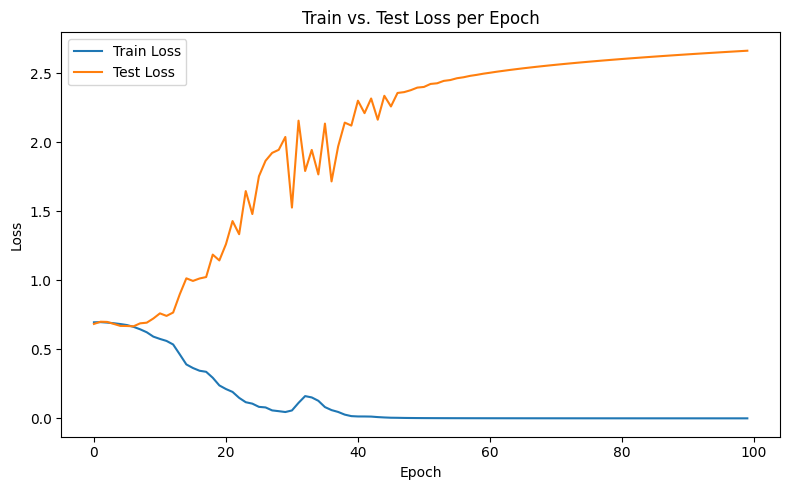

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6796
[Epoch 10/100]  Train Loss: 0.6139
[Epoch 15/100]  Train Loss: 0.4689
[Epoch 20/100]  Train Loss: 0.2212
[Epoch 25/100]  Train Loss: 0.1181
[Epoch 30/100]  Train Loss: 0.0661
[Epoch 35/100]  Train Loss: 0.0402
[Epoch 40/100]  Train Loss: 0.0908
[Epoch 45/100]  Train Loss: 0.0620
[Epoch 50/100]  Train Loss: 0.0123
[Epoch 55/100]  Train Loss: 0.0034
[Epoch 60/100]  Train Loss: 0.0169
[Epoch 65/100]  Train Loss: 0.0278
[Epoch 70/100]  Train Loss: 0.0847
[Epoch 75/100]  Train Loss: 0.0130
[Epoch 80/100]  Train Loss: 0.0017
[Epoch 85/100]  Train Loss: 0.0011
[Epoch 90/100]  Train Loss: 0.0008
[Epoch 95/100]  Train Loss: 0.0006
[Epoch 100/100]  Train Loss: 0.0005
Accuracy on Nonzero Predictions: 0.4809


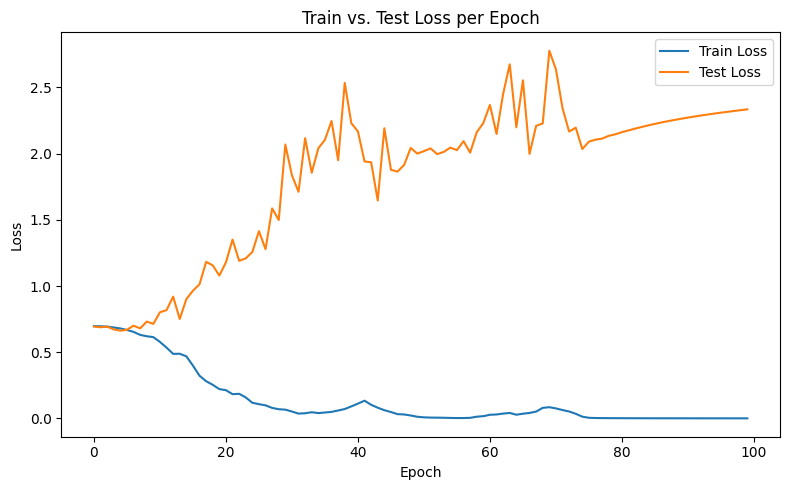

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6802
[Epoch 10/100]  Train Loss: 0.6119
[Epoch 15/100]  Train Loss: 0.4381
[Epoch 20/100]  Train Loss: 0.2348
[Epoch 25/100]  Train Loss: 0.1264
[Epoch 30/100]  Train Loss: 0.0527
[Epoch 35/100]  Train Loss: 0.0260
[Epoch 40/100]  Train Loss: 0.0129
[Epoch 45/100]  Train Loss: 0.1433
[Epoch 50/100]  Train Loss: 0.0484
[Epoch 55/100]  Train Loss: 0.0135
[Epoch 60/100]  Train Loss: 0.0018
[Epoch 65/100]  Train Loss: 0.0012
[Epoch 70/100]  Train Loss: 0.0008
[Epoch 75/100]  Train Loss: 0.0006
[Epoch 80/100]  Train Loss: 0.0005
[Epoch 85/100]  Train Loss: 0.0004
[Epoch 90/100]  Train Loss: 0.0003
[Epoch 95/100]  Train Loss: 0.0003
[Epoch 100/100]  Train Loss: 0.0002
Accuracy on Nonzero Predictions: 0.5344


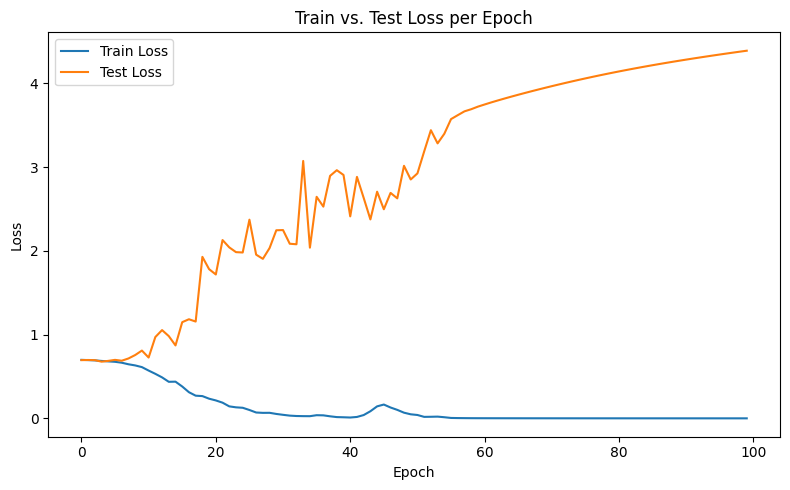

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6827
[Epoch 10/100]  Train Loss: 0.6114
[Epoch 15/100]  Train Loss: 0.4396
[Epoch 20/100]  Train Loss: 0.2390
[Epoch 25/100]  Train Loss: 0.1268
[Epoch 30/100]  Train Loss: 0.0745
[Epoch 35/100]  Train Loss: 0.0809
[Epoch 40/100]  Train Loss: 0.0177
[Epoch 45/100]  Train Loss: 0.0204
[Epoch 50/100]  Train Loss: 0.0149
[Epoch 55/100]  Train Loss: 0.0038
[Epoch 60/100]  Train Loss: 0.0011
[Epoch 65/100]  Train Loss: 0.0007
[Epoch 70/100]  Train Loss: 0.0006
[Epoch 75/100]  Train Loss: 0.0004
[Epoch 80/100]  Train Loss: 0.0003
[Epoch 85/100]  Train Loss: 0.0003
[Epoch 90/100]  Train Loss: 0.0002
[Epoch 95/100]  Train Loss: 0.0002
[Epoch 100/100]  Train Loss: 0.0002
Accuracy on Nonzero Predictions: 0.5496


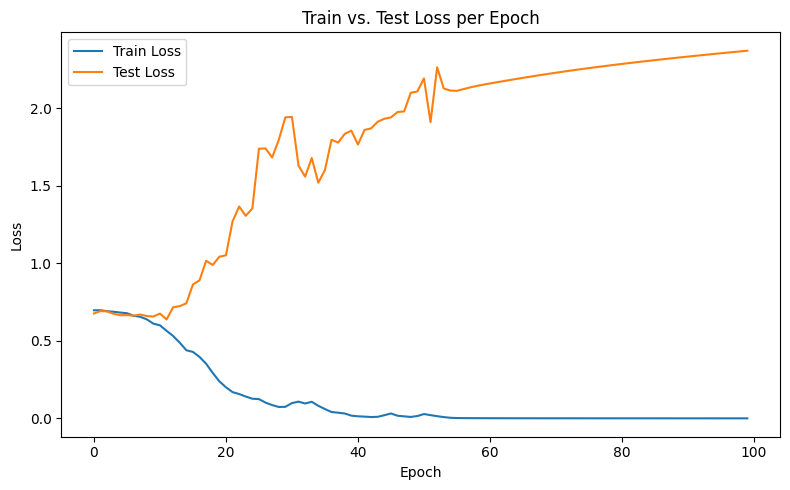

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6811
[Epoch 10/100]  Train Loss: 0.5838
[Epoch 15/100]  Train Loss: 0.3596
[Epoch 20/100]  Train Loss: 0.2060
[Epoch 25/100]  Train Loss: 0.0937
[Epoch 30/100]  Train Loss: 0.0511
[Epoch 35/100]  Train Loss: 0.0424
[Epoch 40/100]  Train Loss: 0.0189
[Epoch 45/100]  Train Loss: 0.1318
[Epoch 50/100]  Train Loss: 0.0240
[Epoch 55/100]  Train Loss: 0.0033
[Epoch 60/100]  Train Loss: 0.0016
[Epoch 65/100]  Train Loss: 0.0011
[Epoch 70/100]  Train Loss: 0.0008
[Epoch 75/100]  Train Loss: 0.0006
[Epoch 80/100]  Train Loss: 0.0005
[Epoch 85/100]  Train Loss: 0.0004
[Epoch 90/100]  Train Loss: 0.0003
[Epoch 95/100]  Train Loss: 0.0003
[Epoch 100/100]  Train Loss: 0.0002
Accuracy on Nonzero Predictions: 0.5725


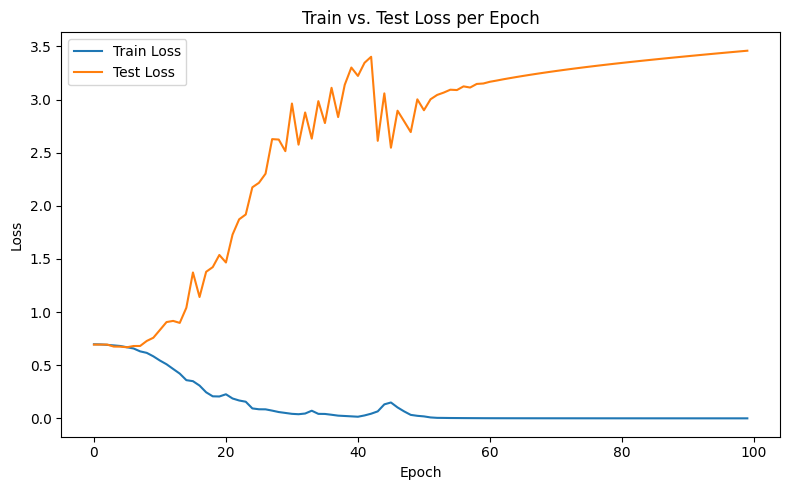

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6936
[Epoch 10/100]  Train Loss: 0.6874
[Epoch 15/100]  Train Loss: 0.6768
[Epoch 20/100]  Train Loss: 0.6562
[Epoch 25/100]  Train Loss: 0.6537
[Epoch 30/100]  Train Loss: 0.6464
[Epoch 35/100]  Train Loss: 0.6598
[Epoch 40/100]  Train Loss: 0.6584
[Epoch 45/100]  Train Loss: 0.6520
[Epoch 50/100]  Train Loss: 0.6428
[Epoch 55/100]  Train Loss: 0.6615
[Epoch 60/100]  Train Loss: 0.6751
[Epoch 65/100]  Train Loss: 0.6841
[Epoch 70/100]  Train Loss: 0.6782
[Epoch 75/100]  Train Loss: 0.6817
[Epoch 80/100]  Train Loss: 0.6817
[Epoch 85/100]  Train Loss: 0.6722
[Epoch 90/100]  Train Loss: 0.6835
[Epoch 95/100]  Train Loss: 0.6840
[Epoch 100/100]  Train Loss: 0.6771
Accuracy on Nonzero Predictions: 0.5802


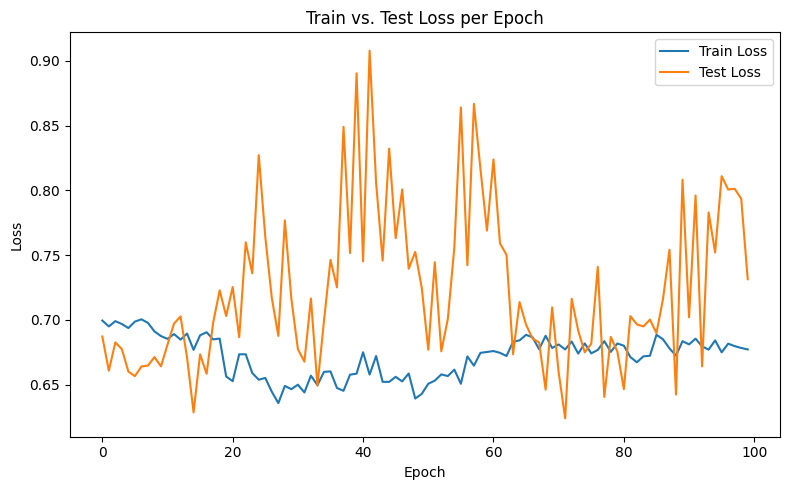

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6929
[Epoch 10/100]  Train Loss: 0.6811
[Epoch 15/100]  Train Loss: 0.6628
[Epoch 20/100]  Train Loss: 0.6057
[Epoch 25/100]  Train Loss: 0.5619
[Epoch 30/100]  Train Loss: 0.5672
[Epoch 35/100]  Train Loss: 0.5668
[Epoch 40/100]  Train Loss: 0.5318
[Epoch 45/100]  Train Loss: 0.5139
[Epoch 50/100]  Train Loss: 0.5393
[Epoch 55/100]  Train Loss: 0.5007
[Epoch 60/100]  Train Loss: 0.4937
[Epoch 65/100]  Train Loss: 0.5110
[Epoch 70/100]  Train Loss: 0.4608
[Epoch 75/100]  Train Loss: 0.4930
[Epoch 80/100]  Train Loss: 0.4509
[Epoch 85/100]  Train Loss: 0.4611
[Epoch 90/100]  Train Loss: 0.4556
[Epoch 95/100]  Train Loss: 0.4243
[Epoch 100/100]  Train Loss: 0.4386
Accuracy on Nonzero Predictions: 0.5038


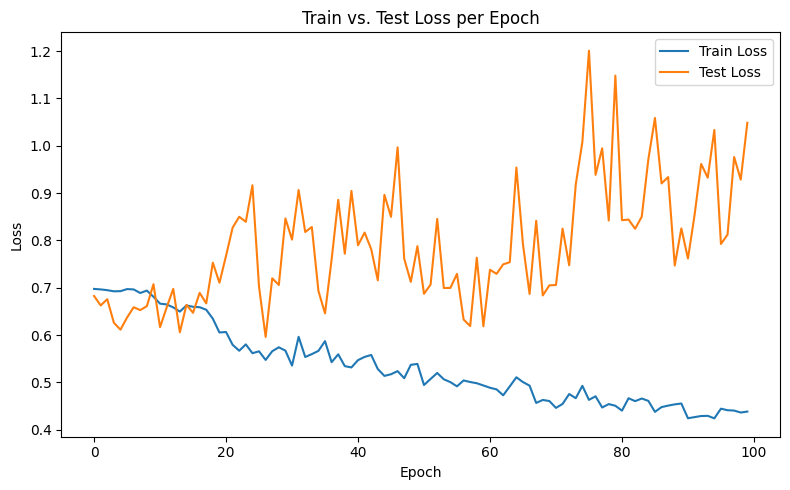

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6894
[Epoch 10/100]  Train Loss: 0.6634
[Epoch 15/100]  Train Loss: 0.6418
[Epoch 20/100]  Train Loss: 0.5895
[Epoch 25/100]  Train Loss: 0.5387
[Epoch 30/100]  Train Loss: 0.5120
[Epoch 35/100]  Train Loss: 0.4870
[Epoch 40/100]  Train Loss: 0.4793
[Epoch 45/100]  Train Loss: 0.4367
[Epoch 50/100]  Train Loss: 0.4084
[Epoch 55/100]  Train Loss: 0.4267
[Epoch 60/100]  Train Loss: 0.3933
[Epoch 65/100]  Train Loss: 0.4062
[Epoch 70/100]  Train Loss: 0.3748
[Epoch 75/100]  Train Loss: 0.4052
[Epoch 80/100]  Train Loss: 0.3662
[Epoch 85/100]  Train Loss: 0.3776
[Epoch 90/100]  Train Loss: 0.4000
[Epoch 95/100]  Train Loss: 0.4077
[Epoch 100/100]  Train Loss: 0.4173
Accuracy on Nonzero Predictions: 0.4962


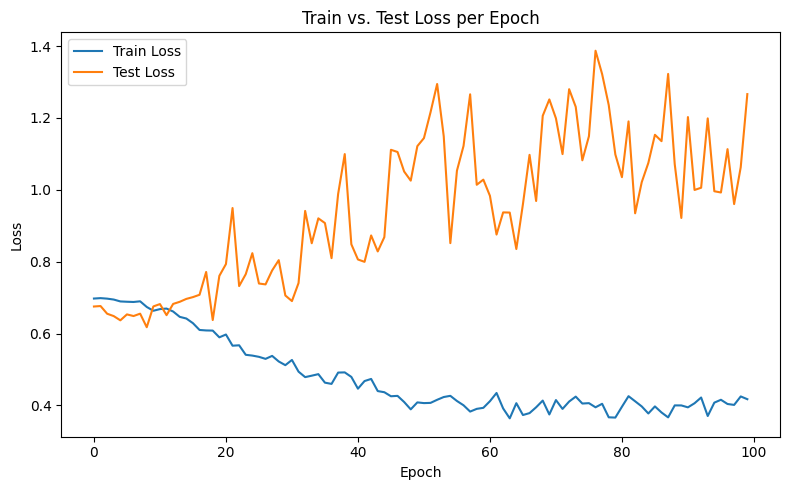

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6965
[Epoch 10/100]  Train Loss: 0.7143
[Epoch 15/100]  Train Loss: 0.6839
[Epoch 20/100]  Train Loss: 0.6662
[Epoch 25/100]  Train Loss: 0.6478
[Epoch 30/100]  Train Loss: 0.6281
[Epoch 35/100]  Train Loss: 0.6100
[Epoch 40/100]  Train Loss: 0.6180
[Epoch 45/100]  Train Loss: 0.5792
[Epoch 50/100]  Train Loss: 0.5740
[Epoch 55/100]  Train Loss: 0.5749
[Epoch 60/100]  Train Loss: 0.5555
[Epoch 65/100]  Train Loss: 0.5553
[Epoch 70/100]  Train Loss: 0.5694
[Epoch 75/100]  Train Loss: 0.5669
[Epoch 80/100]  Train Loss: 0.5542
[Epoch 85/100]  Train Loss: 0.5292
[Epoch 90/100]  Train Loss: 0.5197
[Epoch 95/100]  Train Loss: 0.4956
[Epoch 100/100]  Train Loss: 0.4905
Accuracy on Nonzero Predictions: 0.4733


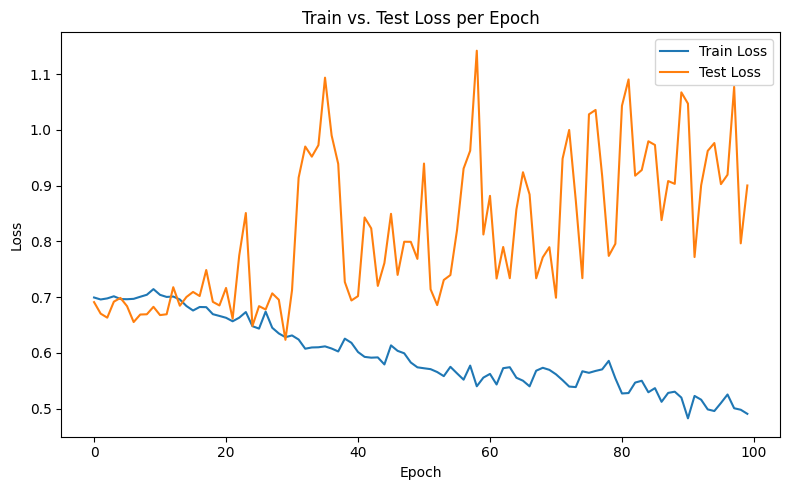

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6968
[Epoch 10/100]  Train Loss: 0.6840
[Epoch 15/100]  Train Loss: 0.6718
[Epoch 20/100]  Train Loss: 0.6224
[Epoch 25/100]  Train Loss: 0.6133
[Epoch 30/100]  Train Loss: 0.5923
[Epoch 35/100]  Train Loss: 0.5697
[Epoch 40/100]  Train Loss: 0.5680
[Epoch 45/100]  Train Loss: 0.5491
[Epoch 50/100]  Train Loss: 0.5150
[Epoch 55/100]  Train Loss: 0.5084
[Epoch 60/100]  Train Loss: 0.5355
[Epoch 65/100]  Train Loss: 0.4860
[Epoch 70/100]  Train Loss: 0.5077
[Epoch 75/100]  Train Loss: 0.4639
[Epoch 80/100]  Train Loss: 0.4935
[Epoch 85/100]  Train Loss: 0.4787
[Epoch 90/100]  Train Loss: 0.4632
[Epoch 95/100]  Train Loss: 0.4779
[Epoch 100/100]  Train Loss: 0.5080
Accuracy on Nonzero Predictions: 0.4885


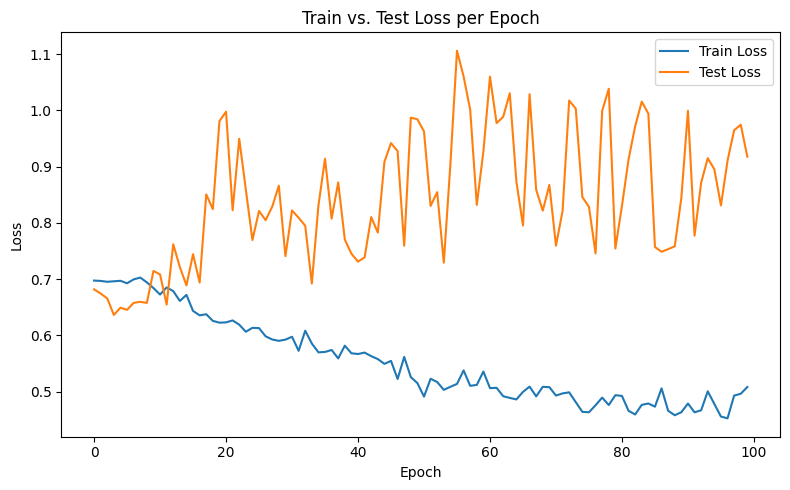

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
----- SECURITY TYPE: options, WINDOW SIZE: 50, STOCK: SPX -----
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.4784
[Epoch 10/100]  Train Loss: 0.1082
[Epoch 15/100]  Train Loss: 0.0384
[Epoch 20/100]  Train Loss: 0.0021
[Epoch 25/100]  Train Loss: 0.0011
[Epoch 30/100]  Train Loss: 0.0007
[Epoch 35/100]  Train Loss: 0.0005
[Epoch 40/100]  Train Loss: 0.0004
[Epoch 45/100]  Train Loss: 0.0003
[Epoch 50/100]  Train Loss: 0.0002
[Epoch 55/100]  Train Loss: 0.0002
[Epoch 60/100]  Train Loss: 0.0002
[Epoch 65/100]  Train Loss: 0.0001
[Epoch 70/100]  Train Loss: 0.0001
[Epoch 75/100]  Train Loss: 0.0001
[Epoch 80/100]  Train Loss: 0.0001
[Epoch 85/100]  Train Loss: 0.0001
[Epoch 90/100]  Train Loss: 0.0001
[Epoch 95/100]  Train Loss: 0.0001
[Epoch 100/100]  Train Loss: 0.0000
Accuracy on Nonzero Predictions: 0.5194


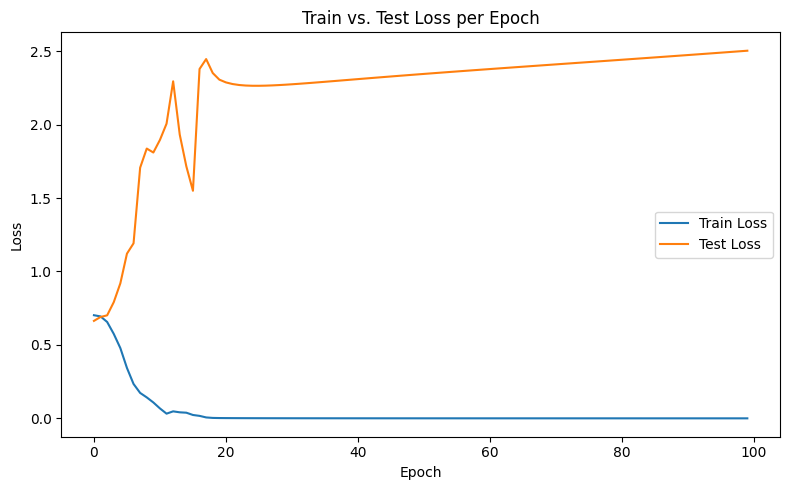

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.4369
[Epoch 10/100]  Train Loss: 0.1294
[Epoch 15/100]  Train Loss: 0.0218
[Epoch 20/100]  Train Loss: 0.0022
[Epoch 25/100]  Train Loss: 0.0013
[Epoch 30/100]  Train Loss: 0.0008
[Epoch 35/100]  Train Loss: 0.0006
[Epoch 40/100]  Train Loss: 0.0004
[Epoch 45/100]  Train Loss: 0.0003
[Epoch 50/100]  Train Loss: 0.0003
[Epoch 55/100]  Train Loss: 0.0002
[Epoch 60/100]  Train Loss: 0.0002
[Epoch 65/100]  Train Loss: 0.0002
[Epoch 70/100]  Train Loss: 0.0001
[Epoch 75/100]  Train Loss: 0.0001
[Epoch 80/100]  Train Loss: 0.0001
[Epoch 85/100]  Train Loss: 0.0001
[Epoch 90/100]  Train Loss: 0.0001
[Epoch 95/100]  Train Loss: 0.0001
[Epoch 100/100]  Train Loss: 0.0001
Accuracy on Nonzero Predictions: 0.5426


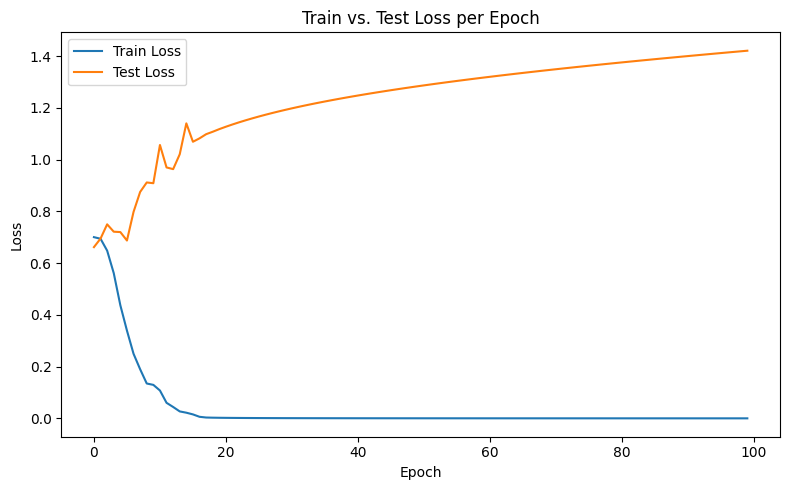

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.4203
[Epoch 10/100]  Train Loss: 0.0871
[Epoch 15/100]  Train Loss: 0.0319
[Epoch 20/100]  Train Loss: 0.0021
[Epoch 25/100]  Train Loss: 0.0012
[Epoch 30/100]  Train Loss: 0.0008
[Epoch 35/100]  Train Loss: 0.0006
[Epoch 40/100]  Train Loss: 0.0004
[Epoch 45/100]  Train Loss: 0.0003
[Epoch 50/100]  Train Loss: 0.0003
[Epoch 55/100]  Train Loss: 0.0002
[Epoch 60/100]  Train Loss: 0.0002
[Epoch 65/100]  Train Loss: 0.0001
[Epoch 70/100]  Train Loss: 0.0001
[Epoch 75/100]  Train Loss: 0.0001
[Epoch 80/100]  Train Loss: 0.0001
[Epoch 85/100]  Train Loss: 0.0001
[Epoch 90/100]  Train Loss: 0.0001
[Epoch 95/100]  Train Loss: 0.0001
[Epoch 100/100]  Train Loss: 0.0000
Accuracy on Nonzero Predictions: 0.4806


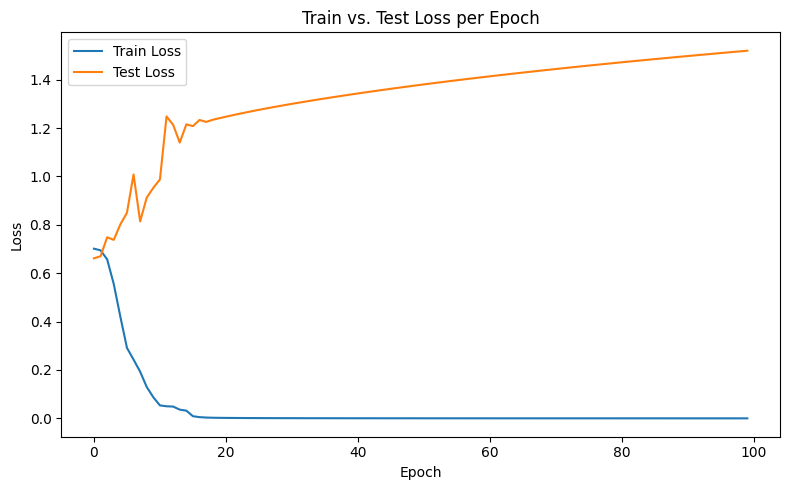

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.4377
[Epoch 10/100]  Train Loss: 0.1302
[Epoch 15/100]  Train Loss: 0.0143
[Epoch 20/100]  Train Loss: 0.0027
[Epoch 25/100]  Train Loss: 0.0015
[Epoch 30/100]  Train Loss: 0.0010
[Epoch 35/100]  Train Loss: 0.0007
[Epoch 40/100]  Train Loss: 0.0005
[Epoch 45/100]  Train Loss: 0.0004
[Epoch 50/100]  Train Loss: 0.0003
[Epoch 55/100]  Train Loss: 0.0002
[Epoch 60/100]  Train Loss: 0.0002
[Epoch 65/100]  Train Loss: 0.0002
[Epoch 70/100]  Train Loss: 0.0001
[Epoch 75/100]  Train Loss: 0.0001
[Epoch 80/100]  Train Loss: 0.0001
[Epoch 85/100]  Train Loss: 0.0001
[Epoch 90/100]  Train Loss: 0.0001
[Epoch 95/100]  Train Loss: 0.0001
[Epoch 100/100]  Train Loss: 0.0001
Accuracy on Nonzero Predictions: 0.5736


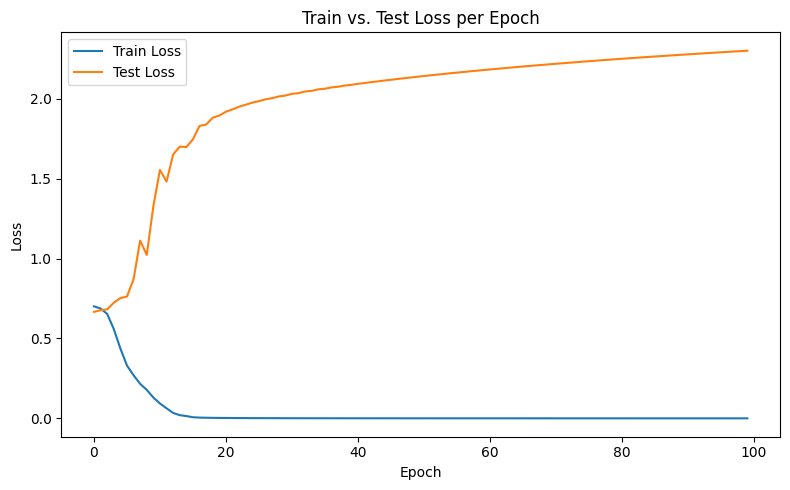

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.4395
[Epoch 10/100]  Train Loss: 0.1606
[Epoch 15/100]  Train Loss: 0.0148
[Epoch 20/100]  Train Loss: 0.0027
[Epoch 25/100]  Train Loss: 0.0015
[Epoch 30/100]  Train Loss: 0.0009
[Epoch 35/100]  Train Loss: 0.0006
[Epoch 40/100]  Train Loss: 0.0005
[Epoch 45/100]  Train Loss: 0.0004
[Epoch 50/100]  Train Loss: 0.0003
[Epoch 55/100]  Train Loss: 0.0002
[Epoch 60/100]  Train Loss: 0.0002
[Epoch 65/100]  Train Loss: 0.0002
[Epoch 70/100]  Train Loss: 0.0001
[Epoch 75/100]  Train Loss: 0.0001
[Epoch 80/100]  Train Loss: 0.0001
[Epoch 85/100]  Train Loss: 0.0001
[Epoch 90/100]  Train Loss: 0.0001
[Epoch 95/100]  Train Loss: 0.0001
[Epoch 100/100]  Train Loss: 0.0001
Accuracy on Nonzero Predictions: 0.5194


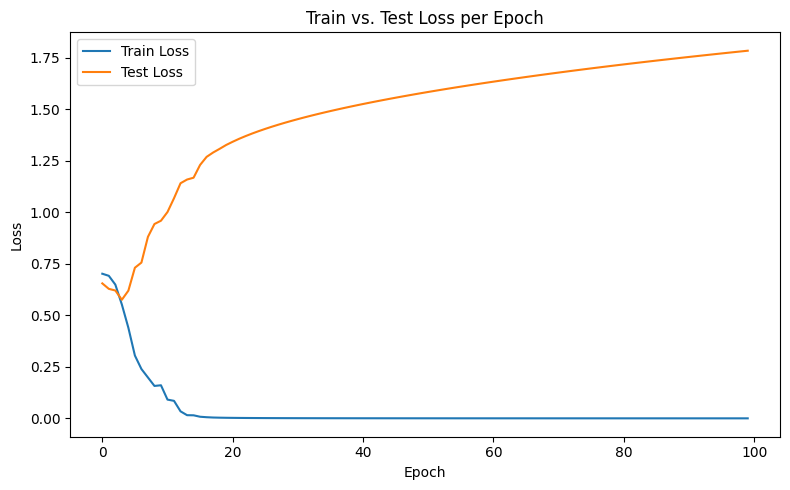

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6843
[Epoch 10/100]  Train Loss: 0.5401
[Epoch 15/100]  Train Loss: 0.3580
[Epoch 20/100]  Train Loss: 0.2564
[Epoch 25/100]  Train Loss: 0.2512
[Epoch 30/100]  Train Loss: 0.2034
[Epoch 35/100]  Train Loss: 0.2114
[Epoch 40/100]  Train Loss: 0.1549
[Epoch 45/100]  Train Loss: 0.1472
[Epoch 50/100]  Train Loss: 0.1227
[Epoch 55/100]  Train Loss: 0.1509
[Epoch 60/100]  Train Loss: 0.1346
[Epoch 65/100]  Train Loss: 0.1153
[Epoch 70/100]  Train Loss: 0.1640
[Epoch 75/100]  Train Loss: 0.1163
[Epoch 80/100]  Train Loss: 0.1448
[Epoch 85/100]  Train Loss: 0.1315
[Epoch 90/100]  Train Loss: 0.1467
[Epoch 95/100]  Train Loss: 0.1378
[Epoch 100/100]  Train Loss: 0.1436
Accuracy on Nonzero Predictions: 0.6047


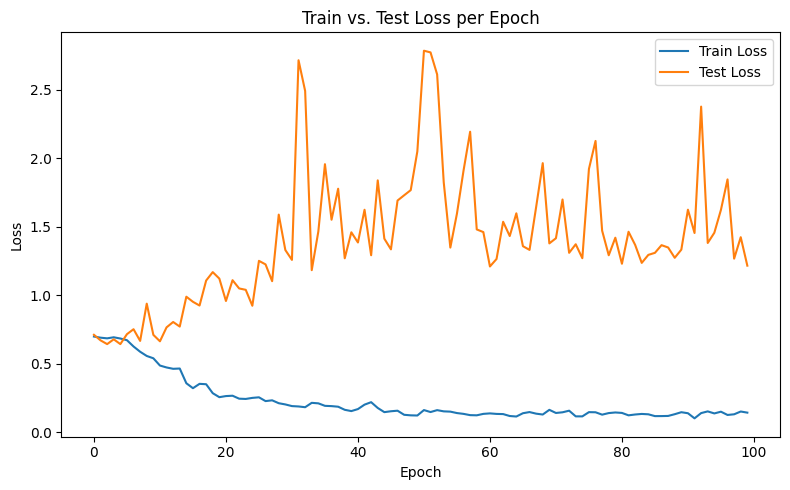

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.7043
[Epoch 10/100]  Train Loss: 0.5444
[Epoch 15/100]  Train Loss: 0.4137
[Epoch 20/100]  Train Loss: 0.2779
[Epoch 25/100]  Train Loss: 0.2373
[Epoch 30/100]  Train Loss: 0.1810
[Epoch 35/100]  Train Loss: 0.1637
[Epoch 40/100]  Train Loss: 0.1918
[Epoch 45/100]  Train Loss: 0.1778
[Epoch 50/100]  Train Loss: 0.1754
[Epoch 55/100]  Train Loss: 0.1537
[Epoch 60/100]  Train Loss: 0.1433
[Epoch 65/100]  Train Loss: 0.1720
[Epoch 70/100]  Train Loss: 0.1640
[Epoch 75/100]  Train Loss: 0.1608
[Epoch 80/100]  Train Loss: 0.1576
[Epoch 85/100]  Train Loss: 0.1842
[Epoch 90/100]  Train Loss: 0.1496
[Epoch 95/100]  Train Loss: 0.1512
[Epoch 100/100]  Train Loss: 0.1633
Accuracy on Nonzero Predictions: 0.5426


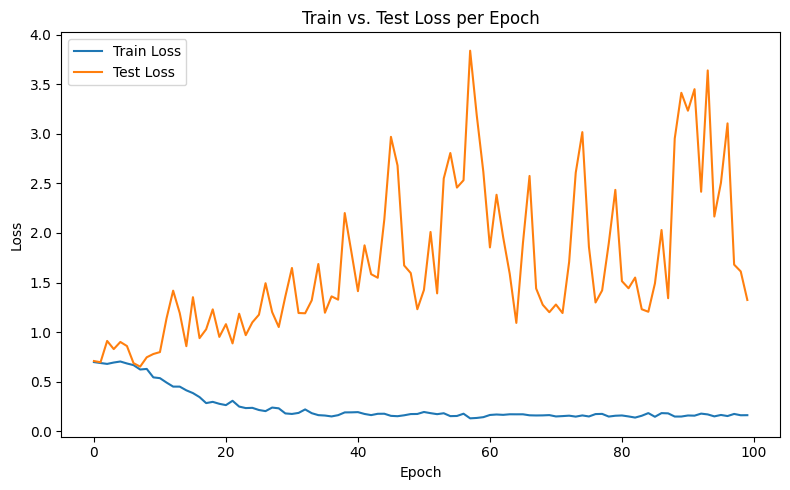

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.7071
[Epoch 10/100]  Train Loss: 0.5355
[Epoch 15/100]  Train Loss: 0.3704
[Epoch 20/100]  Train Loss: 0.2691
[Epoch 25/100]  Train Loss: 0.1967
[Epoch 30/100]  Train Loss: 0.1612
[Epoch 35/100]  Train Loss: 0.1570
[Epoch 40/100]  Train Loss: 0.1651
[Epoch 45/100]  Train Loss: 0.1376
[Epoch 50/100]  Train Loss: 0.1144
[Epoch 55/100]  Train Loss: 0.1141
[Epoch 60/100]  Train Loss: 0.1422
[Epoch 65/100]  Train Loss: 0.1167
[Epoch 70/100]  Train Loss: 0.0921
[Epoch 75/100]  Train Loss: 0.0940
[Epoch 80/100]  Train Loss: 0.0933
[Epoch 85/100]  Train Loss: 0.1228
[Epoch 90/100]  Train Loss: 0.0995
[Epoch 95/100]  Train Loss: 0.0989
[Epoch 100/100]  Train Loss: 0.1633
Accuracy on Nonzero Predictions: 0.5349


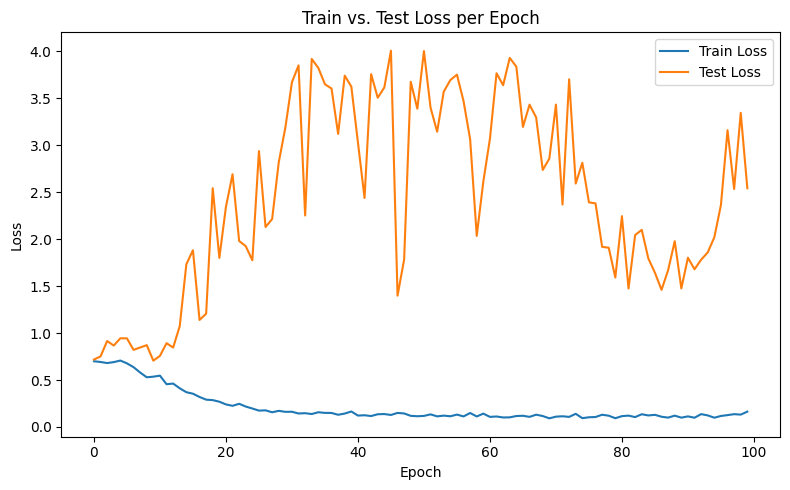

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6955
[Epoch 10/100]  Train Loss: 0.5415
[Epoch 15/100]  Train Loss: 0.3349
[Epoch 20/100]  Train Loss: 0.2528
[Epoch 25/100]  Train Loss: 0.2373
[Epoch 30/100]  Train Loss: 0.1632
[Epoch 35/100]  Train Loss: 0.1339
[Epoch 40/100]  Train Loss: 0.1494
[Epoch 45/100]  Train Loss: 0.1385
[Epoch 50/100]  Train Loss: 0.1563
[Epoch 55/100]  Train Loss: 0.1241
[Epoch 60/100]  Train Loss: 0.1074
[Epoch 65/100]  Train Loss: 0.1268
[Epoch 70/100]  Train Loss: 0.1115
[Epoch 75/100]  Train Loss: 0.1160
[Epoch 80/100]  Train Loss: 0.1379
[Epoch 85/100]  Train Loss: 0.1188
[Epoch 90/100]  Train Loss: 0.1235
[Epoch 95/100]  Train Loss: 0.1466
[Epoch 100/100]  Train Loss: 0.1290
Accuracy on Nonzero Predictions: 0.4961


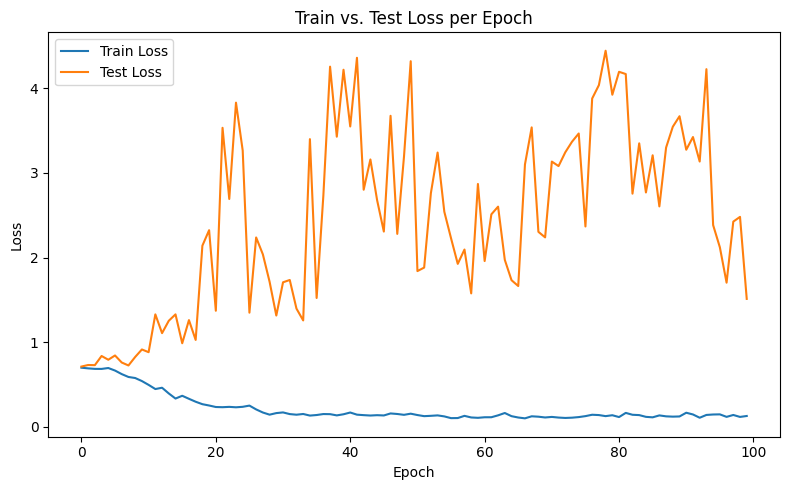

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6930
[Epoch 10/100]  Train Loss: 0.5371
[Epoch 15/100]  Train Loss: 0.3944
[Epoch 20/100]  Train Loss: 0.2924
[Epoch 25/100]  Train Loss: 0.2243
[Epoch 30/100]  Train Loss: 0.2115
[Epoch 35/100]  Train Loss: 0.1650
[Epoch 40/100]  Train Loss: 0.1825
[Epoch 45/100]  Train Loss: 0.1480
[Epoch 50/100]  Train Loss: 0.1478
[Epoch 55/100]  Train Loss: 0.1585
[Epoch 60/100]  Train Loss: 0.1227
[Epoch 65/100]  Train Loss: 0.1382
[Epoch 70/100]  Train Loss: 0.1613
[Epoch 75/100]  Train Loss: 0.1425
[Epoch 80/100]  Train Loss: 0.1440
[Epoch 85/100]  Train Loss: 0.1602
[Epoch 90/100]  Train Loss: 0.1375
[Epoch 95/100]  Train Loss: 0.1495
[Epoch 100/100]  Train Loss: 0.1076
Accuracy on Nonzero Predictions: 0.5581


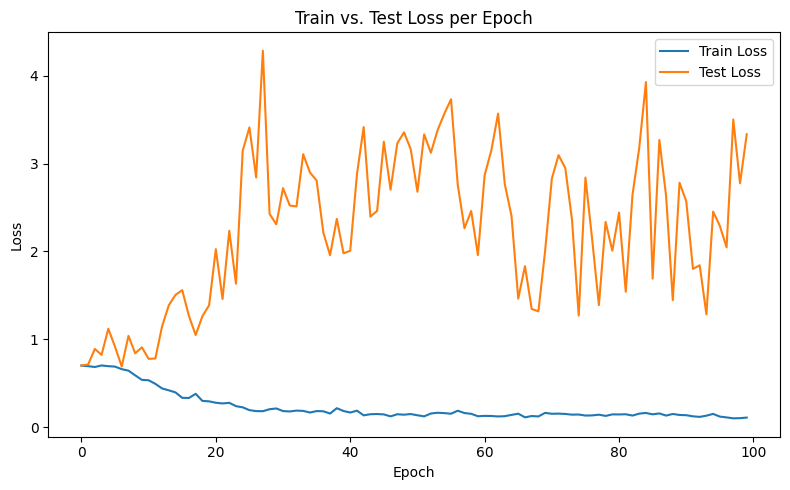

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
----- SECURITY TYPE: options, WINDOW SIZE: 100, STOCK: SPX -----
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.2094
[Epoch 10/100]  Train Loss: 0.0265
[Epoch 15/100]  Train Loss: 0.0021
[Epoch 20/100]  Train Loss: 0.0011
[Epoch 25/100]  Train Loss: 0.0007
[Epoch 30/100]  Train Loss: 0.0005
[Epoch 35/100]  Train Loss: 0.0004
[Epoch 40/100]  Train Loss: 0.0003
[Epoch 45/100]  Train Loss: 0.0002
[Epoch 50/100]  Train Loss: 0.0002
[Epoch 55/100]  Train Loss: 0.0001
[Epoch 60/100]  Train Loss: 0.0001
[Epoch 65/100]  Train Loss: 0.0001
[Epoch 70/100]  Train Loss: 0.0001
[Epoch 75/100]  Train Loss: 0.0001
[Epoch 80/100]  Train Loss: 0.0001
[Epoch 85/100]  Train Loss: 0.0001
[Epoch 90/100]  Train Loss: 0.0000
[Epoch 95/100]  Train Loss: 0.0000
[Epoch 100/100]  Train Loss: 0.0000
Accuracy on Nonzero Predictions: 0.5000


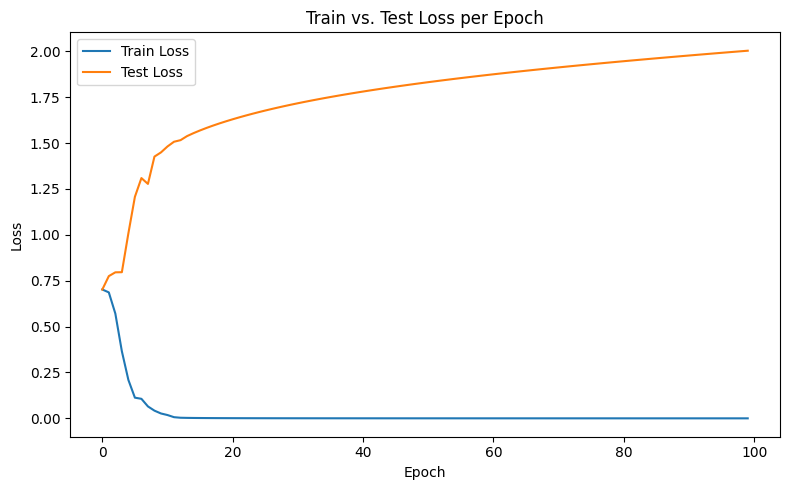

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.2180
[Epoch 10/100]  Train Loss: 0.0291
[Epoch 15/100]  Train Loss: 0.0020
[Epoch 20/100]  Train Loss: 0.0010
[Epoch 25/100]  Train Loss: 0.0007
[Epoch 30/100]  Train Loss: 0.0005
[Epoch 35/100]  Train Loss: 0.0003
[Epoch 40/100]  Train Loss: 0.0003
[Epoch 45/100]  Train Loss: 0.0002
[Epoch 50/100]  Train Loss: 0.0002
[Epoch 55/100]  Train Loss: 0.0001
[Epoch 60/100]  Train Loss: 0.0001
[Epoch 65/100]  Train Loss: 0.0001
[Epoch 70/100]  Train Loss: 0.0001
[Epoch 75/100]  Train Loss: 0.0001
[Epoch 80/100]  Train Loss: 0.0001
[Epoch 85/100]  Train Loss: 0.0001
[Epoch 90/100]  Train Loss: 0.0000
[Epoch 95/100]  Train Loss: 0.0000
[Epoch 100/100]  Train Loss: 0.0000
Accuracy on Nonzero Predictions: 0.4524


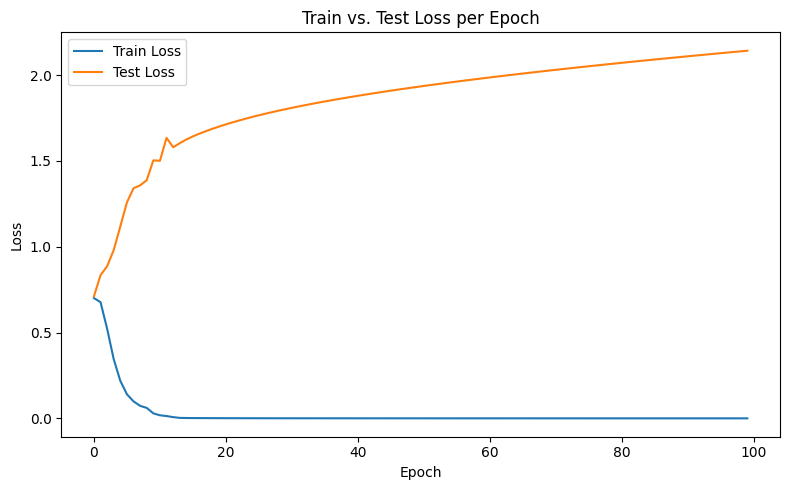

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.2804
[Epoch 10/100]  Train Loss: 0.0302
[Epoch 15/100]  Train Loss: 0.0024
[Epoch 20/100]  Train Loss: 0.0012
[Epoch 25/100]  Train Loss: 0.0007
[Epoch 30/100]  Train Loss: 0.0005
[Epoch 35/100]  Train Loss: 0.0004
[Epoch 40/100]  Train Loss: 0.0003
[Epoch 45/100]  Train Loss: 0.0002
[Epoch 50/100]  Train Loss: 0.0002
[Epoch 55/100]  Train Loss: 0.0001
[Epoch 60/100]  Train Loss: 0.0001
[Epoch 65/100]  Train Loss: 0.0001
[Epoch 70/100]  Train Loss: 0.0001
[Epoch 75/100]  Train Loss: 0.0001
[Epoch 80/100]  Train Loss: 0.0001
[Epoch 85/100]  Train Loss: 0.0001
[Epoch 90/100]  Train Loss: 0.0000
[Epoch 95/100]  Train Loss: 0.0000
[Epoch 100/100]  Train Loss: 0.0000
Accuracy on Nonzero Predictions: 0.4762


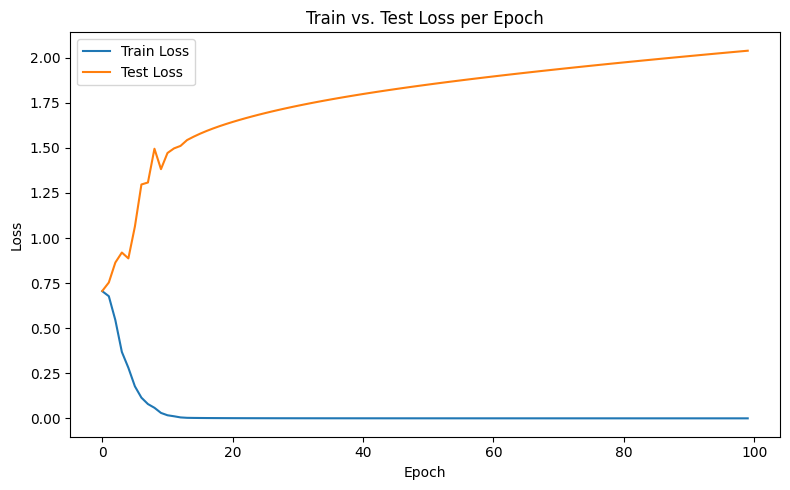

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.1987
[Epoch 10/100]  Train Loss: 0.0258
[Epoch 15/100]  Train Loss: 0.0021
[Epoch 20/100]  Train Loss: 0.0011
[Epoch 25/100]  Train Loss: 0.0007
[Epoch 30/100]  Train Loss: 0.0005
[Epoch 35/100]  Train Loss: 0.0004
[Epoch 40/100]  Train Loss: 0.0003
[Epoch 45/100]  Train Loss: 0.0002
[Epoch 50/100]  Train Loss: 0.0002
[Epoch 55/100]  Train Loss: 0.0001
[Epoch 60/100]  Train Loss: 0.0001
[Epoch 65/100]  Train Loss: 0.0001
[Epoch 70/100]  Train Loss: 0.0001
[Epoch 75/100]  Train Loss: 0.0001
[Epoch 80/100]  Train Loss: 0.0001
[Epoch 85/100]  Train Loss: 0.0001
[Epoch 90/100]  Train Loss: 0.0000
[Epoch 95/100]  Train Loss: 0.0000
[Epoch 100/100]  Train Loss: 0.0000
Accuracy on Nonzero Predictions: 0.5317


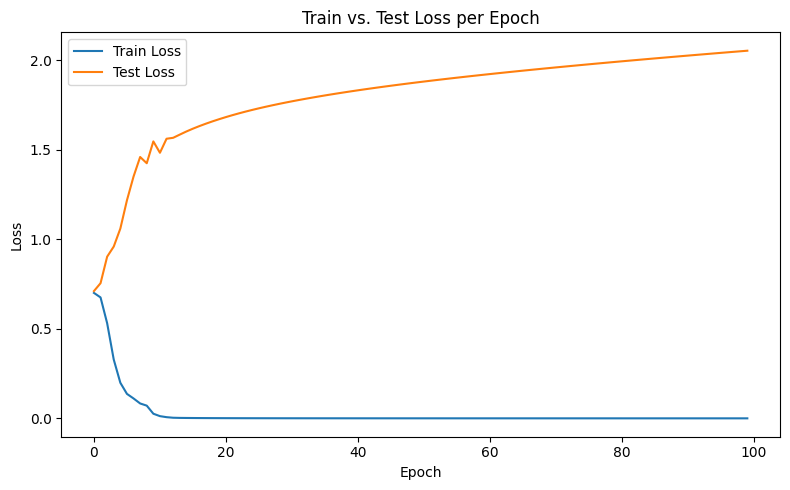

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.2241
[Epoch 10/100]  Train Loss: 0.0128
[Epoch 15/100]  Train Loss: 0.0023
[Epoch 20/100]  Train Loss: 0.0010
[Epoch 25/100]  Train Loss: 0.0006
[Epoch 30/100]  Train Loss: 0.0004
[Epoch 35/100]  Train Loss: 0.0003
[Epoch 40/100]  Train Loss: 0.0002
[Epoch 45/100]  Train Loss: 0.0002
[Epoch 50/100]  Train Loss: 0.0001
[Epoch 55/100]  Train Loss: 0.0001
[Epoch 60/100]  Train Loss: 0.0001
[Epoch 65/100]  Train Loss: 0.0001
[Epoch 70/100]  Train Loss: 0.0001
[Epoch 75/100]  Train Loss: 0.0001
[Epoch 80/100]  Train Loss: 0.0000
[Epoch 85/100]  Train Loss: 0.0000
[Epoch 90/100]  Train Loss: 0.0000
[Epoch 95/100]  Train Loss: 0.0000
[Epoch 100/100]  Train Loss: 0.0000
Accuracy on Nonzero Predictions: 0.5873


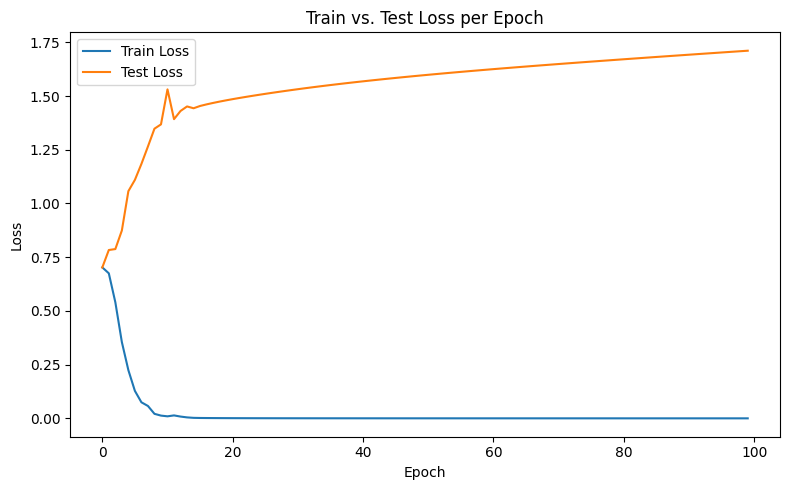

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6944
[Epoch 10/100]  Train Loss: 0.4328
[Epoch 15/100]  Train Loss: 0.2744
[Epoch 20/100]  Train Loss: 0.1828
[Epoch 25/100]  Train Loss: 0.1785
[Epoch 30/100]  Train Loss: 0.1038
[Epoch 35/100]  Train Loss: 0.0775
[Epoch 40/100]  Train Loss: 0.0734
[Epoch 45/100]  Train Loss: 0.0716
[Epoch 50/100]  Train Loss: 0.0530
[Epoch 55/100]  Train Loss: 0.0654
[Epoch 60/100]  Train Loss: 0.0869
[Epoch 65/100]  Train Loss: 0.0716
[Epoch 70/100]  Train Loss: 0.0759
[Epoch 75/100]  Train Loss: 0.0589
[Epoch 80/100]  Train Loss: 0.0610
[Epoch 85/100]  Train Loss: 0.0587
[Epoch 90/100]  Train Loss: 0.0499
[Epoch 95/100]  Train Loss: 0.0673
[Epoch 100/100]  Train Loss: 0.0722
Accuracy on Nonzero Predictions: 0.4921


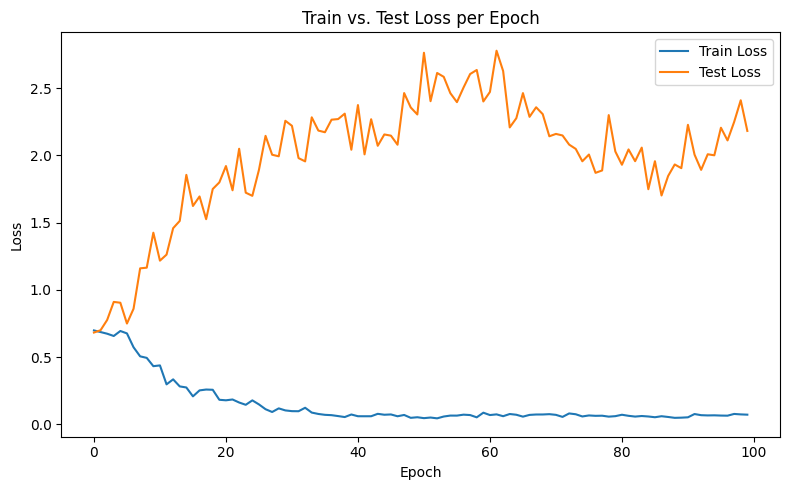

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6803
[Epoch 10/100]  Train Loss: 0.3792
[Epoch 15/100]  Train Loss: 0.2175
[Epoch 20/100]  Train Loss: 0.1470
[Epoch 25/100]  Train Loss: 0.1141
[Epoch 30/100]  Train Loss: 0.0948
[Epoch 35/100]  Train Loss: 0.0605
[Epoch 40/100]  Train Loss: 0.0737
[Epoch 45/100]  Train Loss: 0.0840
[Epoch 50/100]  Train Loss: 0.0469
[Epoch 55/100]  Train Loss: 0.0711
[Epoch 60/100]  Train Loss: 0.0705
[Epoch 65/100]  Train Loss: 0.0786
[Epoch 70/100]  Train Loss: 0.0557
[Epoch 75/100]  Train Loss: 0.0895
[Epoch 80/100]  Train Loss: 0.0733
[Epoch 85/100]  Train Loss: 0.0769
[Epoch 90/100]  Train Loss: 0.0558
[Epoch 95/100]  Train Loss: 0.0805
[Epoch 100/100]  Train Loss: 0.0554
Accuracy on Nonzero Predictions: 0.5635


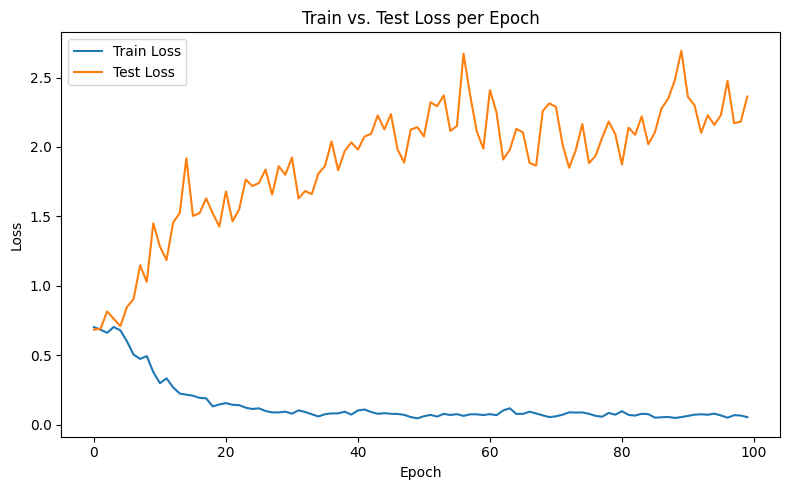

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6740
[Epoch 10/100]  Train Loss: 0.4011
[Epoch 15/100]  Train Loss: 0.2006
[Epoch 20/100]  Train Loss: 0.1637
[Epoch 25/100]  Train Loss: 0.1469
[Epoch 30/100]  Train Loss: 0.0795
[Epoch 35/100]  Train Loss: 0.0967
[Epoch 40/100]  Train Loss: 0.0816
[Epoch 45/100]  Train Loss: 0.0702
[Epoch 50/100]  Train Loss: 0.0709
[Epoch 55/100]  Train Loss: 0.0755
[Epoch 60/100]  Train Loss: 0.0583
[Epoch 65/100]  Train Loss: 0.0634
[Epoch 70/100]  Train Loss: 0.0673
[Epoch 75/100]  Train Loss: 0.0651
[Epoch 80/100]  Train Loss: 0.0848
[Epoch 85/100]  Train Loss: 0.0661
[Epoch 90/100]  Train Loss: 0.0715
[Epoch 95/100]  Train Loss: 0.0800
[Epoch 100/100]  Train Loss: 0.0654
Accuracy on Nonzero Predictions: 0.5159


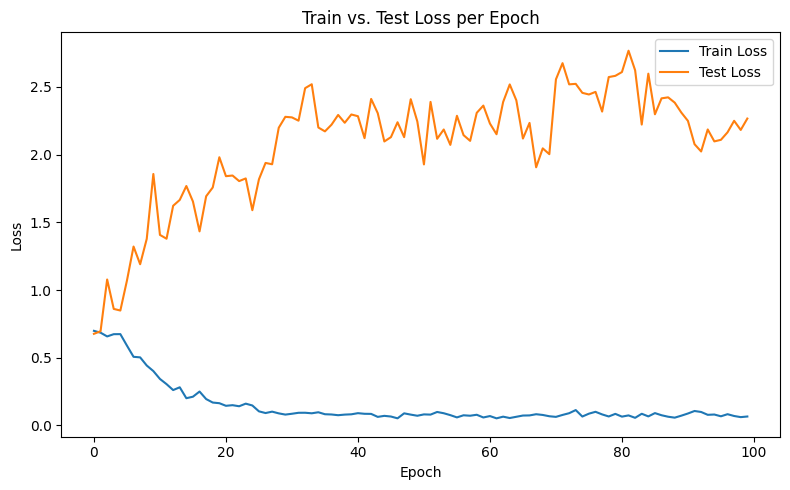

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6860
[Epoch 10/100]  Train Loss: 0.3948
[Epoch 15/100]  Train Loss: 0.2343
[Epoch 20/100]  Train Loss: 0.1693
[Epoch 25/100]  Train Loss: 0.1303
[Epoch 30/100]  Train Loss: 0.0996
[Epoch 35/100]  Train Loss: 0.1037
[Epoch 40/100]  Train Loss: 0.0813
[Epoch 45/100]  Train Loss: 0.0839
[Epoch 50/100]  Train Loss: 0.0734
[Epoch 55/100]  Train Loss: 0.0943
[Epoch 60/100]  Train Loss: 0.0529
[Epoch 65/100]  Train Loss: 0.0614
[Epoch 70/100]  Train Loss: 0.0621
[Epoch 75/100]  Train Loss: 0.0824
[Epoch 80/100]  Train Loss: 0.1006
[Epoch 85/100]  Train Loss: 0.0541
[Epoch 90/100]  Train Loss: 0.0501
[Epoch 95/100]  Train Loss: 0.0579
[Epoch 100/100]  Train Loss: 0.0587
Accuracy on Nonzero Predictions: 0.5000


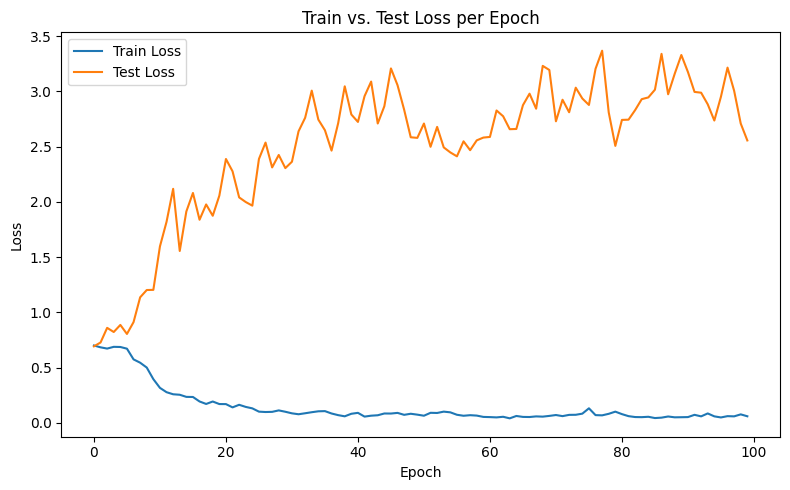

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: options
[Epoch 5/100]  Train Loss: 0.6412
[Epoch 10/100]  Train Loss: 0.4121
[Epoch 15/100]  Train Loss: 0.2075
[Epoch 20/100]  Train Loss: 0.1370
[Epoch 25/100]  Train Loss: 0.0955
[Epoch 30/100]  Train Loss: 0.0890
[Epoch 35/100]  Train Loss: 0.0740
[Epoch 40/100]  Train Loss: 0.0718
[Epoch 45/100]  Train Loss: 0.0744
[Epoch 50/100]  Train Loss: 0.0747
[Epoch 55/100]  Train Loss: 0.0597
[Epoch 60/100]  Train Loss: 0.0708
[Epoch 65/100]  Train Loss: 0.0751
[Epoch 70/100]  Train Loss: 0.0610
[Epoch 75/100]  Train Loss: 0.0710
[Epoch 80/100]  Train Loss: 0.0770
[Epoch 85/100]  Train Loss: 0.1013
[Epoch 90/100]  Train Loss: 0.0930
[Epoch 95/100]  Train Loss: 0.0762
[Epoch 100/100]  Train Loss: 0.0461
Accuracy on Nonzero Predictions: 0.5317


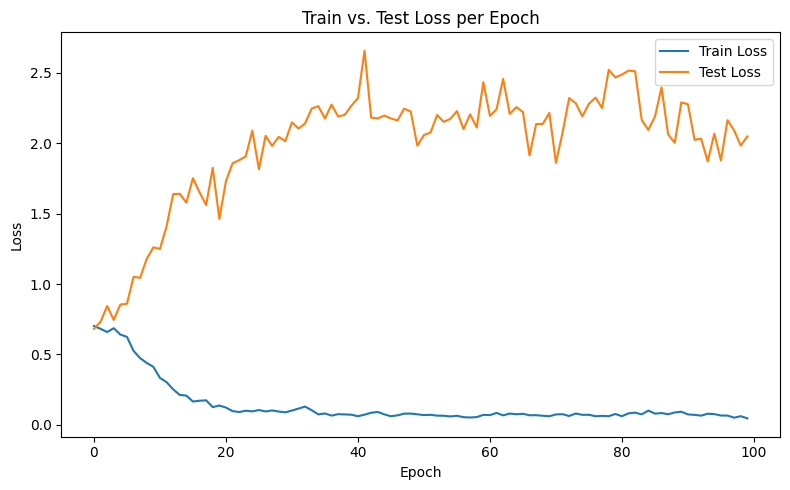

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
----- SECURITY TYPE: technical, WINDOW SIZE: 5, STOCK: SPX -----
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6887
[Epoch 10/100]  Train Loss: 0.6753
[Epoch 15/100]  Train Loss: 0.6424
[Epoch 20/100]  Train Loss: 0.5819
[Epoch 25/100]  Train Loss: 0.4861
[Epoch 30/100]  Train Loss: 0.3887
[Epoch 35/100]  Train Loss: 0.3231
[Epoch 40/100]  Train Loss: 0.2894
[Epoch 45/100]  Train Loss: 0.1628
[Epoch 50/100]  Train Loss: 0.1859
[Epoch 55/100]  Train Loss: 0.1398
[Epoch 60/100]  Train Loss: 0.0930
[Epoch 65/100]  Train Loss: 0.0811
[Epoch 70/100]  Train Loss: 0.0489
[Epoch 75/100]  Train Loss: 0.0588
[Epoch 80/100]  Train Loss: 0.0690
[Epoch 85/100]  Train Loss: 0.0769
[Epoch 90/100]  Train Loss: 0.0287
[Epoch 95/100]  Train Loss: 0.0268
[Epoch 100/100]  Train Loss: 0.0399
Accuracy on Nonzero Predictions: 0.5317


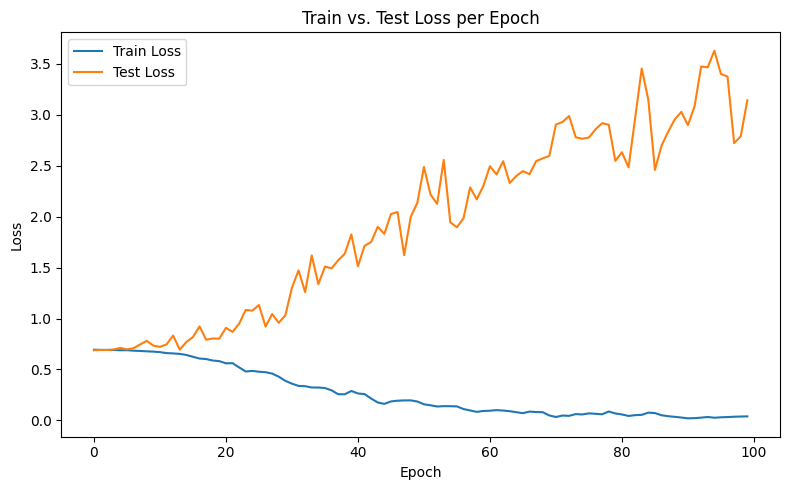

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6905
[Epoch 10/100]  Train Loss: 0.6748
[Epoch 15/100]  Train Loss: 0.6332
[Epoch 20/100]  Train Loss: 0.5782
[Epoch 25/100]  Train Loss: 0.5025
[Epoch 30/100]  Train Loss: 0.4318
[Epoch 35/100]  Train Loss: 0.3313
[Epoch 40/100]  Train Loss: 0.2716
[Epoch 45/100]  Train Loss: 0.2613
[Epoch 50/100]  Train Loss: 0.1464
[Epoch 55/100]  Train Loss: 0.1307
[Epoch 60/100]  Train Loss: 0.1207
[Epoch 65/100]  Train Loss: 0.1193
[Epoch 70/100]  Train Loss: 0.1143
[Epoch 75/100]  Train Loss: 0.0832
[Epoch 80/100]  Train Loss: 0.0614
[Epoch 85/100]  Train Loss: 0.1115
[Epoch 90/100]  Train Loss: 0.0373
[Epoch 95/100]  Train Loss: 0.0534
[Epoch 100/100]  Train Loss: 0.0702
Accuracy on Nonzero Predictions: 0.5317


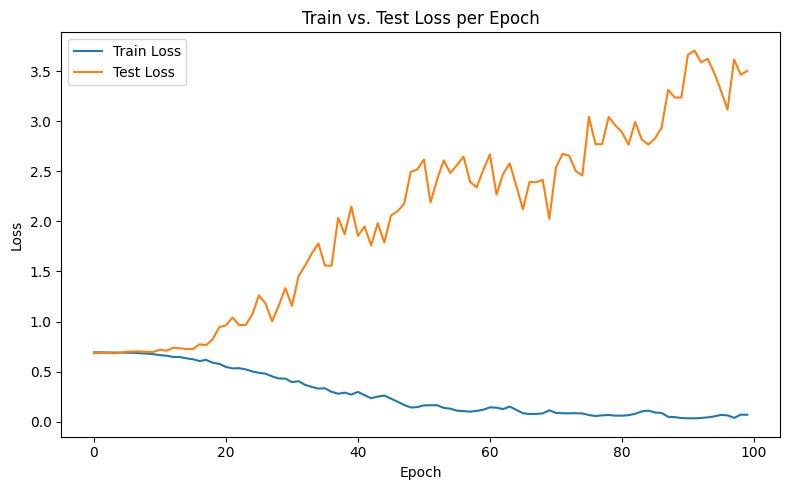

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6898
[Epoch 10/100]  Train Loss: 0.6762
[Epoch 15/100]  Train Loss: 0.6389
[Epoch 20/100]  Train Loss: 0.5856
[Epoch 25/100]  Train Loss: 0.5526
[Epoch 30/100]  Train Loss: 0.4462
[Epoch 35/100]  Train Loss: 0.3676
[Epoch 40/100]  Train Loss: 0.2406
[Epoch 45/100]  Train Loss: 0.2545
[Epoch 50/100]  Train Loss: 0.1418
[Epoch 55/100]  Train Loss: 0.0777
[Epoch 60/100]  Train Loss: 0.1352
[Epoch 65/100]  Train Loss: 0.0719
[Epoch 70/100]  Train Loss: 0.0601
[Epoch 75/100]  Train Loss: 0.0333
[Epoch 80/100]  Train Loss: 0.0264
[Epoch 85/100]  Train Loss: 0.0409
[Epoch 90/100]  Train Loss: 0.0765
[Epoch 95/100]  Train Loss: 0.0426
[Epoch 100/100]  Train Loss: 0.0270
Accuracy on Nonzero Predictions: 0.5238


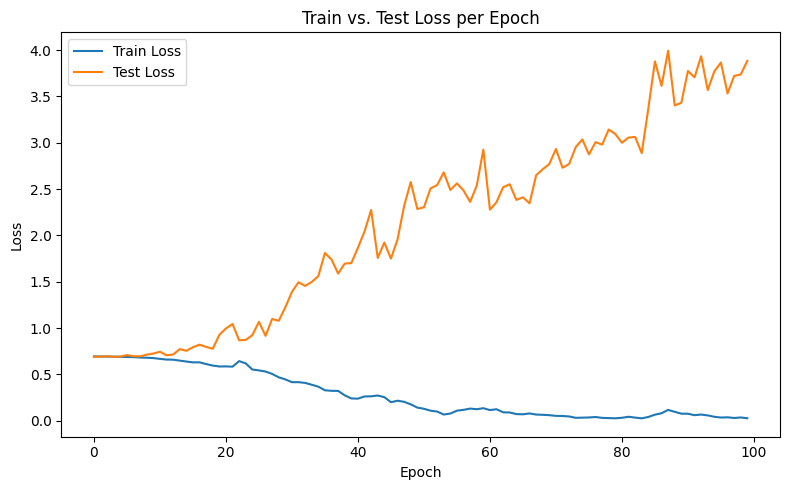

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6901
[Epoch 10/100]  Train Loss: 0.6823
[Epoch 15/100]  Train Loss: 0.6497
[Epoch 20/100]  Train Loss: 0.5958
[Epoch 25/100]  Train Loss: 0.5302
[Epoch 30/100]  Train Loss: 0.4399
[Epoch 35/100]  Train Loss: 0.3022
[Epoch 40/100]  Train Loss: 0.2738
[Epoch 45/100]  Train Loss: 0.2023
[Epoch 50/100]  Train Loss: 0.1576
[Epoch 55/100]  Train Loss: 0.1257
[Epoch 60/100]  Train Loss: 0.0571
[Epoch 65/100]  Train Loss: 0.0815
[Epoch 70/100]  Train Loss: 0.0419
[Epoch 75/100]  Train Loss: 0.0887
[Epoch 80/100]  Train Loss: 0.0482
[Epoch 85/100]  Train Loss: 0.0404
[Epoch 90/100]  Train Loss: 0.0649
[Epoch 95/100]  Train Loss: 0.0711
[Epoch 100/100]  Train Loss: 0.0634
Accuracy on Nonzero Predictions: 0.5000


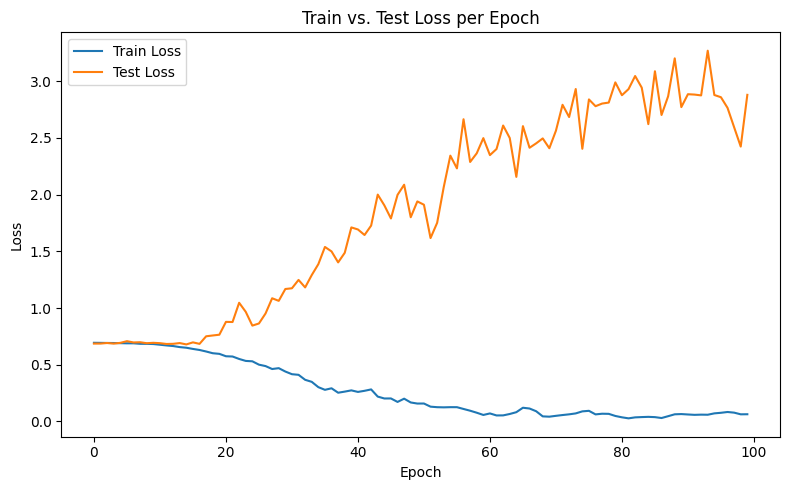

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6905
[Epoch 10/100]  Train Loss: 0.6751
[Epoch 15/100]  Train Loss: 0.6365
[Epoch 20/100]  Train Loss: 0.5885
[Epoch 25/100]  Train Loss: 0.5226
[Epoch 30/100]  Train Loss: 0.4663
[Epoch 35/100]  Train Loss: 0.4139
[Epoch 40/100]  Train Loss: 0.3311
[Epoch 45/100]  Train Loss: 0.2775
[Epoch 50/100]  Train Loss: 0.1901
[Epoch 55/100]  Train Loss: 0.2156
[Epoch 60/100]  Train Loss: 0.1588
[Epoch 65/100]  Train Loss: 0.1318
[Epoch 70/100]  Train Loss: 0.1394
[Epoch 75/100]  Train Loss: 0.1267
[Epoch 80/100]  Train Loss: 0.0847
[Epoch 85/100]  Train Loss: 0.1084
[Epoch 90/100]  Train Loss: 0.1083
[Epoch 95/100]  Train Loss: 0.0416
[Epoch 100/100]  Train Loss: 0.0695
Accuracy on Nonzero Predictions: 0.4206


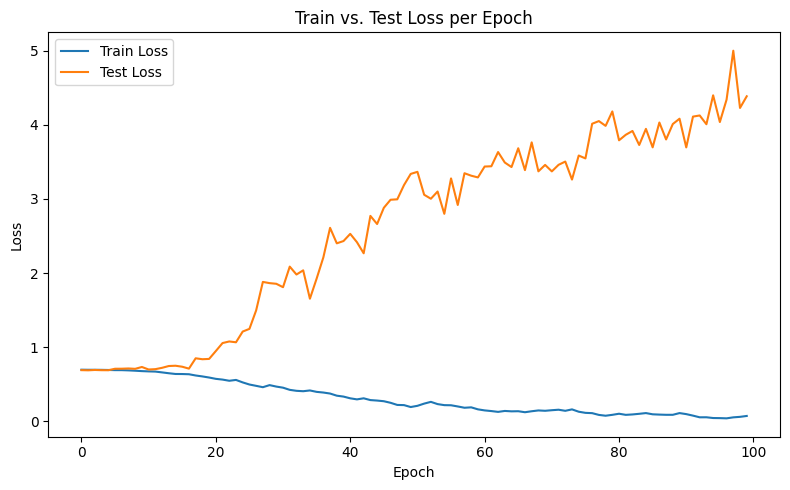

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6947
[Epoch 10/100]  Train Loss: 0.7189
[Epoch 15/100]  Train Loss: 0.7252
[Epoch 20/100]  Train Loss: 0.7179
[Epoch 25/100]  Train Loss: 0.7080
[Epoch 30/100]  Train Loss: 0.6967
[Epoch 35/100]  Train Loss: 0.6934
[Epoch 40/100]  Train Loss: 0.6953
[Epoch 45/100]  Train Loss: 0.7032
[Epoch 50/100]  Train Loss: 0.7097
[Epoch 55/100]  Train Loss: 0.7835
[Epoch 60/100]  Train Loss: 0.7023
[Epoch 65/100]  Train Loss: 0.6937
[Epoch 70/100]  Train Loss: 0.7145
[Epoch 75/100]  Train Loss: 0.7122
[Epoch 80/100]  Train Loss: 0.7384
[Epoch 85/100]  Train Loss: 0.6959
[Epoch 90/100]  Train Loss: 0.7293
[Epoch 95/100]  Train Loss: 0.7016
[Epoch 100/100]  Train Loss: 0.7528
Accuracy on Nonzero Predictions: 0.4286


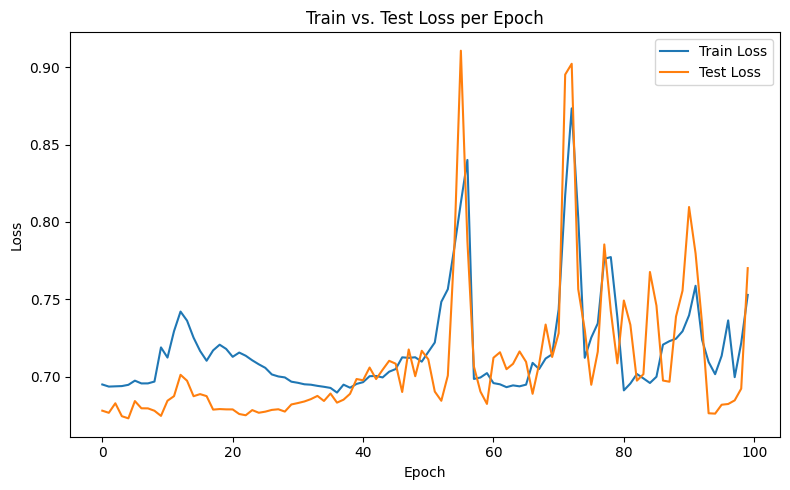

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6936
[Epoch 10/100]  Train Loss: 0.6951
[Epoch 15/100]  Train Loss: 0.7004
[Epoch 20/100]  Train Loss: 0.7021
[Epoch 25/100]  Train Loss: 0.6950
[Epoch 30/100]  Train Loss: 0.7300
[Epoch 35/100]  Train Loss: 0.7156
[Epoch 40/100]  Train Loss: 0.7018
[Epoch 45/100]  Train Loss: 0.7012
[Epoch 50/100]  Train Loss: 0.7032
[Epoch 55/100]  Train Loss: 0.7031
[Epoch 60/100]  Train Loss: 0.7081
[Epoch 65/100]  Train Loss: 0.7047
[Epoch 70/100]  Train Loss: 0.6973
[Epoch 75/100]  Train Loss: 0.6958
[Epoch 80/100]  Train Loss: 0.6947
[Epoch 85/100]  Train Loss: 0.6916
[Epoch 90/100]  Train Loss: 0.6924
[Epoch 95/100]  Train Loss: 0.6942
[Epoch 100/100]  Train Loss: 0.6965
Accuracy on Nonzero Predictions: 0.5952


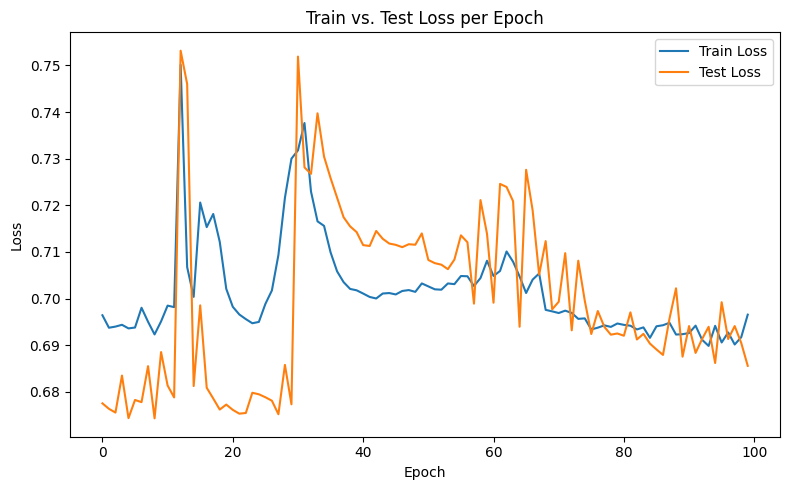

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6911
[Epoch 10/100]  Train Loss: 0.6962
[Epoch 15/100]  Train Loss: 0.7157
[Epoch 20/100]  Train Loss: 0.6987
[Epoch 25/100]  Train Loss: 0.7553
[Epoch 30/100]  Train Loss: 0.7073
[Epoch 35/100]  Train Loss: 0.7120
[Epoch 40/100]  Train Loss: 0.7094
[Epoch 45/100]  Train Loss: 0.7089
[Epoch 50/100]  Train Loss: 0.7149
[Epoch 55/100]  Train Loss: 0.7271
[Epoch 60/100]  Train Loss: 0.7513
[Epoch 65/100]  Train Loss: 0.7655
[Epoch 70/100]  Train Loss: 0.7992
[Epoch 75/100]  Train Loss: 0.7262
[Epoch 80/100]  Train Loss: 0.7079
[Epoch 85/100]  Train Loss: 0.6953
[Epoch 90/100]  Train Loss: 0.6969
[Epoch 95/100]  Train Loss: 0.7011
[Epoch 100/100]  Train Loss: 0.7037
Accuracy on Nonzero Predictions: 0.5952


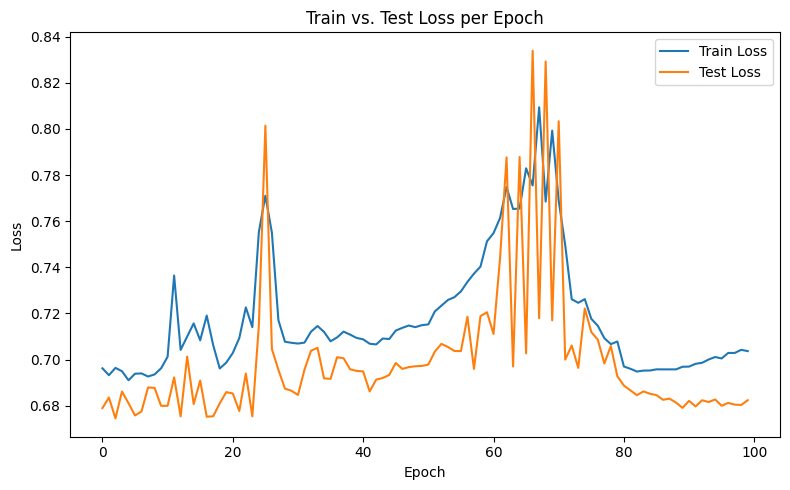

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6937
[Epoch 10/100]  Train Loss: 0.6933
[Epoch 15/100]  Train Loss: 0.6984
[Epoch 20/100]  Train Loss: 0.6962
[Epoch 25/100]  Train Loss: 0.6907
[Epoch 30/100]  Train Loss: 0.6929
[Epoch 35/100]  Train Loss: 0.6923
[Epoch 40/100]  Train Loss: 0.6888
[Epoch 45/100]  Train Loss: 0.6854
[Epoch 50/100]  Train Loss: 0.6731
[Epoch 55/100]  Train Loss: 0.6624
[Epoch 60/100]  Train Loss: 0.6515
[Epoch 65/100]  Train Loss: 0.6399
[Epoch 70/100]  Train Loss: 0.6342
[Epoch 75/100]  Train Loss: 0.6118
[Epoch 80/100]  Train Loss: 0.6241
[Epoch 85/100]  Train Loss: 0.5986
[Epoch 90/100]  Train Loss: 0.5768
[Epoch 95/100]  Train Loss: 0.6162
[Epoch 100/100]  Train Loss: 0.5939
Accuracy on Nonzero Predictions: 0.3730


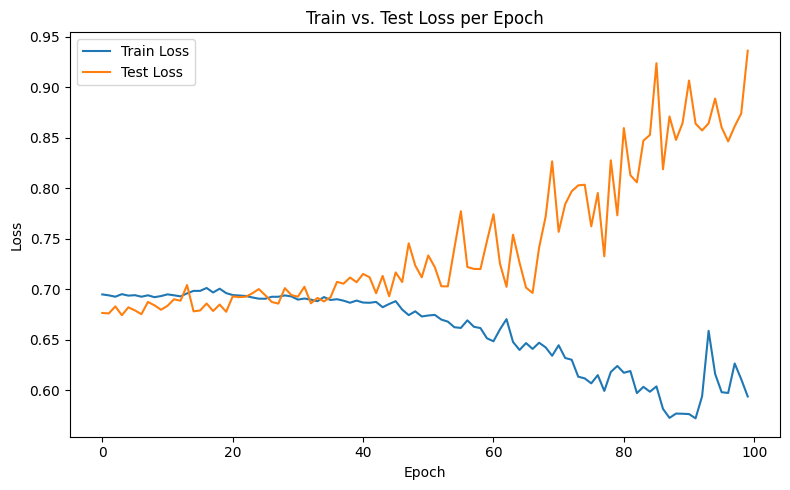

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6947
[Epoch 10/100]  Train Loss: 0.7206
[Epoch 15/100]  Train Loss: 0.7035
[Epoch 20/100]  Train Loss: 0.6961
[Epoch 25/100]  Train Loss: 0.7071
[Epoch 30/100]  Train Loss: 0.7375
[Epoch 35/100]  Train Loss: 0.7070
[Epoch 40/100]  Train Loss: 0.7007
[Epoch 45/100]  Train Loss: 0.7035
[Epoch 50/100]  Train Loss: 0.7058
[Epoch 55/100]  Train Loss: 0.7088
[Epoch 60/100]  Train Loss: 0.7088
[Epoch 65/100]  Train Loss: 0.7127
[Epoch 70/100]  Train Loss: 0.7110
[Epoch 75/100]  Train Loss: 0.7119
[Epoch 80/100]  Train Loss: 0.7157
[Epoch 85/100]  Train Loss: 0.6961
[Epoch 90/100]  Train Loss: 0.7203
[Epoch 95/100]  Train Loss: 0.6992
[Epoch 100/100]  Train Loss: 0.6980
Accuracy on Nonzero Predictions: 0.4524


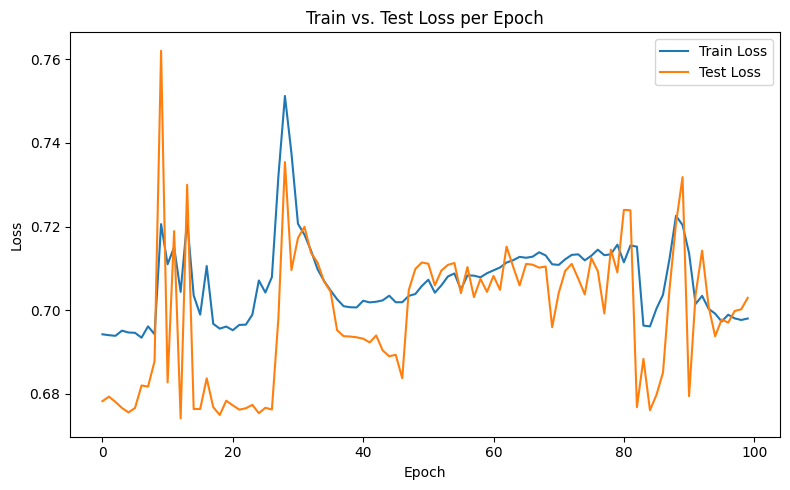

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
----- SECURITY TYPE: technical, WINDOW SIZE: 10, STOCK: SPX -----
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6824
[Epoch 10/100]  Train Loss: 0.6297
[Epoch 15/100]  Train Loss: 0.4994
[Epoch 20/100]  Train Loss: 0.3310
[Epoch 25/100]  Train Loss: 0.2148
[Epoch 30/100]  Train Loss: 0.0923
[Epoch 35/100]  Train Loss: 0.0887
[Epoch 40/100]  Train Loss: 0.0478
[Epoch 45/100]  Train Loss: 0.0253
[Epoch 50/100]  Train Loss: 0.0116
[Epoch 55/100]  Train Loss: 0.0910
[Epoch 60/100]  Train Loss: 0.0638
[Epoch 65/100]  Train Loss: 0.0312
[Epoch 70/100]  Train Loss: 0.0360
[Epoch 75/100]  Train Loss: 0.0071
[Epoch 80/100]  Train Loss: 0.0085
[Epoch 85/100]  Train Loss: 0.0180
[Epoch 90/100]  Train Loss: 0.0631
[Epoch 95/100]  Train Loss: 0.0541
[Epoch 100/100]  Train Loss: 0.0184
Accuracy on Nonzero Predictions: 0.4127


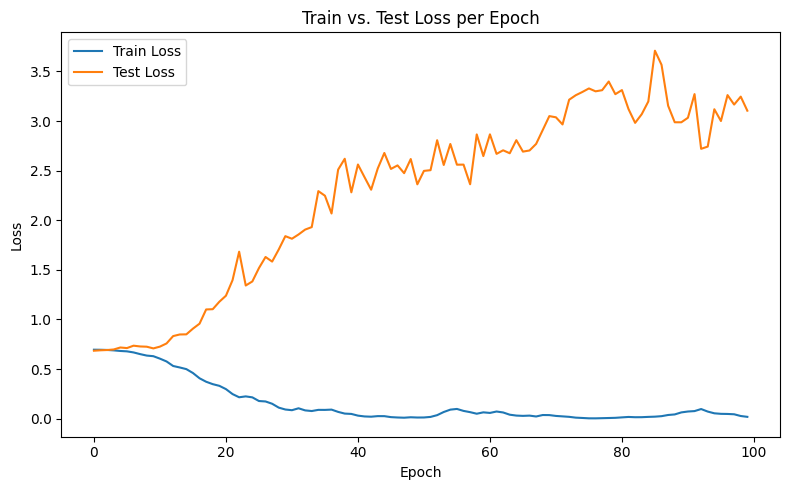

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6848
[Epoch 10/100]  Train Loss: 0.6295
[Epoch 15/100]  Train Loss: 0.4968
[Epoch 20/100]  Train Loss: 0.3277
[Epoch 25/100]  Train Loss: 0.1824
[Epoch 30/100]  Train Loss: 0.1072
[Epoch 35/100]  Train Loss: 0.0585
[Epoch 40/100]  Train Loss: 0.0743
[Epoch 45/100]  Train Loss: 0.0384
[Epoch 50/100]  Train Loss: 0.0028
[Epoch 55/100]  Train Loss: 0.0012
[Epoch 60/100]  Train Loss: 0.0008
[Epoch 65/100]  Train Loss: 0.0006
[Epoch 70/100]  Train Loss: 0.0004
[Epoch 75/100]  Train Loss: 0.0003
[Epoch 80/100]  Train Loss: 0.0003
[Epoch 85/100]  Train Loss: 0.0002
[Epoch 90/100]  Train Loss: 0.0002
[Epoch 95/100]  Train Loss: 0.0002
[Epoch 100/100]  Train Loss: 0.0001
Accuracy on Nonzero Predictions: 0.4683


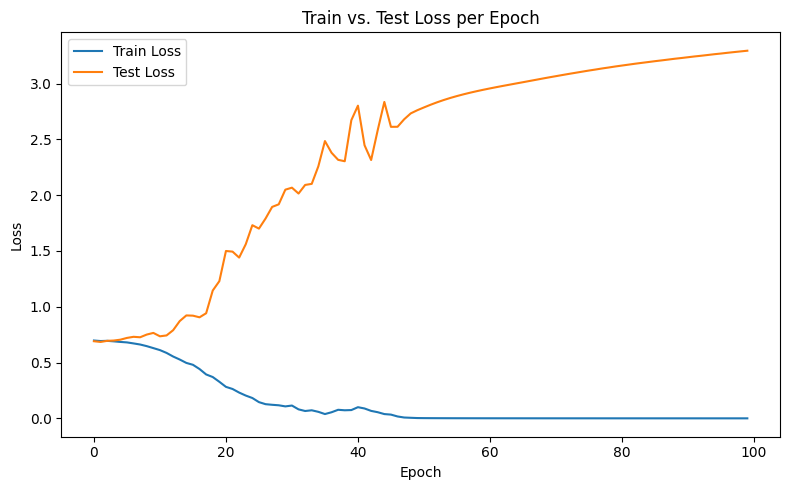

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6828
[Epoch 10/100]  Train Loss: 0.6178
[Epoch 15/100]  Train Loss: 0.4668
[Epoch 20/100]  Train Loss: 0.3083
[Epoch 25/100]  Train Loss: 0.1625
[Epoch 30/100]  Train Loss: 0.0818
[Epoch 35/100]  Train Loss: 0.0678
[Epoch 40/100]  Train Loss: 0.0223
[Epoch 45/100]  Train Loss: 0.0285
[Epoch 50/100]  Train Loss: 0.1340
[Epoch 55/100]  Train Loss: 0.0139
[Epoch 60/100]  Train Loss: 0.0020
[Epoch 65/100]  Train Loss: 0.0012
[Epoch 70/100]  Train Loss: 0.0008
[Epoch 75/100]  Train Loss: 0.0006
[Epoch 80/100]  Train Loss: 0.0005
[Epoch 85/100]  Train Loss: 0.0004
[Epoch 90/100]  Train Loss: 0.0003
[Epoch 95/100]  Train Loss: 0.0003
[Epoch 100/100]  Train Loss: 0.0002
Accuracy on Nonzero Predictions: 0.4762


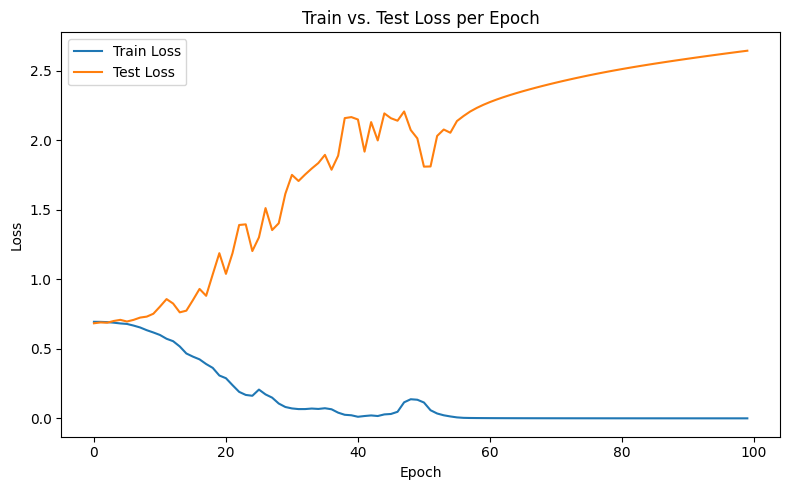

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6854
[Epoch 10/100]  Train Loss: 0.6391
[Epoch 15/100]  Train Loss: 0.5043
[Epoch 20/100]  Train Loss: 0.3449
[Epoch 25/100]  Train Loss: 0.2189
[Epoch 30/100]  Train Loss: 0.1492
[Epoch 35/100]  Train Loss: 0.1212
[Epoch 40/100]  Train Loss: 0.0761
[Epoch 45/100]  Train Loss: 0.0651
[Epoch 50/100]  Train Loss: 0.0263
[Epoch 55/100]  Train Loss: 0.0058
[Epoch 60/100]  Train Loss: 0.0016
[Epoch 65/100]  Train Loss: 0.0010
[Epoch 70/100]  Train Loss: 0.0007
[Epoch 75/100]  Train Loss: 0.0005
[Epoch 80/100]  Train Loss: 0.0004
[Epoch 85/100]  Train Loss: 0.0003
[Epoch 90/100]  Train Loss: 0.0003
[Epoch 95/100]  Train Loss: 0.0002
[Epoch 100/100]  Train Loss: 0.0002
Accuracy on Nonzero Predictions: 0.5079


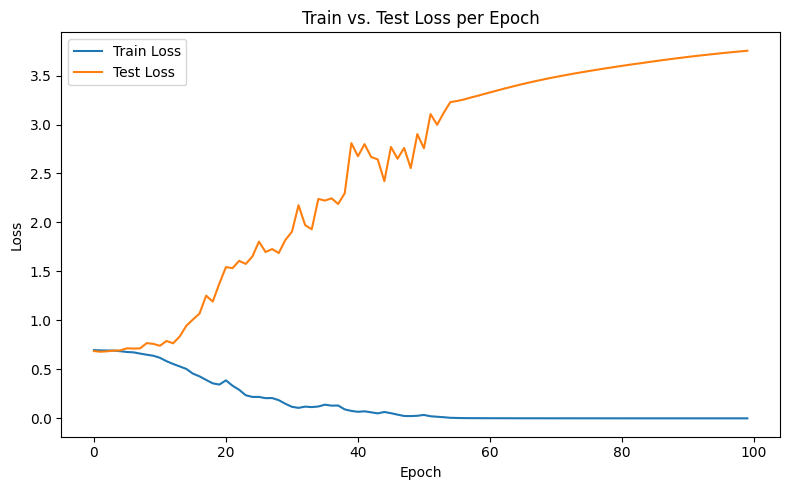

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6847
[Epoch 10/100]  Train Loss: 0.6594
[Epoch 15/100]  Train Loss: 0.5086
[Epoch 20/100]  Train Loss: 0.3336
[Epoch 25/100]  Train Loss: 0.2210
[Epoch 30/100]  Train Loss: 0.1393
[Epoch 35/100]  Train Loss: 0.0626
[Epoch 40/100]  Train Loss: 0.0675
[Epoch 45/100]  Train Loss: 0.0573
[Epoch 50/100]  Train Loss: 0.0108
[Epoch 55/100]  Train Loss: 0.0127
[Epoch 60/100]  Train Loss: 0.0101
[Epoch 65/100]  Train Loss: 0.1506
[Epoch 70/100]  Train Loss: 0.0326
[Epoch 75/100]  Train Loss: 0.0023
[Epoch 80/100]  Train Loss: 0.0010
[Epoch 85/100]  Train Loss: 0.0007
[Epoch 90/100]  Train Loss: 0.0005
[Epoch 95/100]  Train Loss: 0.0004
[Epoch 100/100]  Train Loss: 0.0003
Accuracy on Nonzero Predictions: 0.5238


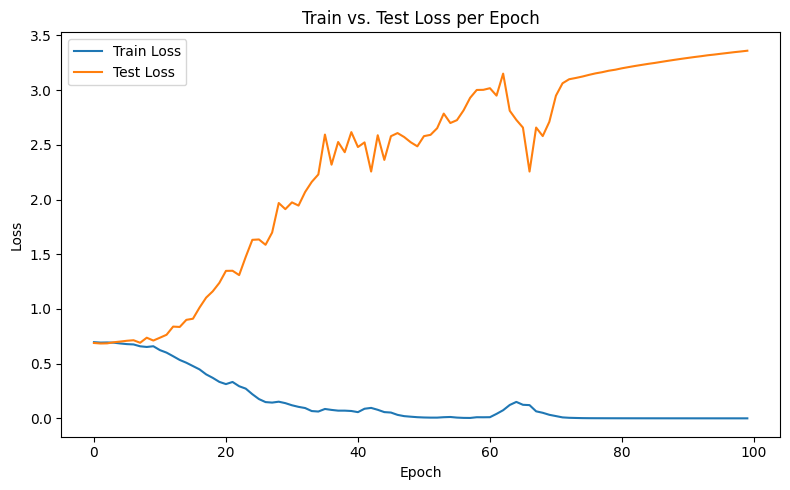

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6989
[Epoch 10/100]  Train Loss: 0.7117
[Epoch 15/100]  Train Loss: 0.7018
[Epoch 20/100]  Train Loss: 0.7056
[Epoch 25/100]  Train Loss: 0.7058
[Epoch 30/100]  Train Loss: 0.6933
[Epoch 35/100]  Train Loss: 0.6967
[Epoch 40/100]  Train Loss: 0.6926
[Epoch 45/100]  Train Loss: 0.7024
[Epoch 50/100]  Train Loss: 0.7159
[Epoch 55/100]  Train Loss: 0.6960
[Epoch 60/100]  Train Loss: 0.7318
[Epoch 65/100]  Train Loss: 0.7065
[Epoch 70/100]  Train Loss: 0.6961
[Epoch 75/100]  Train Loss: 0.6888
[Epoch 80/100]  Train Loss: 0.6901
[Epoch 85/100]  Train Loss: 0.6943
[Epoch 90/100]  Train Loss: 0.6834
[Epoch 95/100]  Train Loss: 0.6930
[Epoch 100/100]  Train Loss: 0.6905
Accuracy on Nonzero Predictions: 0.4762


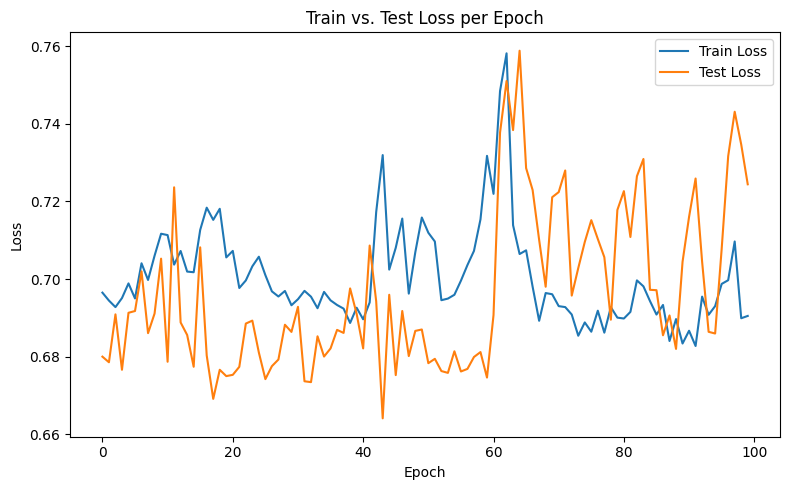

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6936
[Epoch 10/100]  Train Loss: 0.6987
[Epoch 15/100]  Train Loss: 0.7000
[Epoch 20/100]  Train Loss: 0.6964
[Epoch 25/100]  Train Loss: 0.7080
[Epoch 30/100]  Train Loss: 0.7137
[Epoch 35/100]  Train Loss: 0.7137
[Epoch 40/100]  Train Loss: 0.7182
[Epoch 45/100]  Train Loss: 0.7084
[Epoch 50/100]  Train Loss: 0.7006
[Epoch 55/100]  Train Loss: 0.6981
[Epoch 60/100]  Train Loss: 0.7109
[Epoch 65/100]  Train Loss: 0.7012
[Epoch 70/100]  Train Loss: 0.6956
[Epoch 75/100]  Train Loss: 0.7819
[Epoch 80/100]  Train Loss: 0.7024
[Epoch 85/100]  Train Loss: 0.6949
[Epoch 90/100]  Train Loss: 0.6857
[Epoch 95/100]  Train Loss: 0.6970
[Epoch 100/100]  Train Loss: 0.6976
Accuracy on Nonzero Predictions: 0.4683


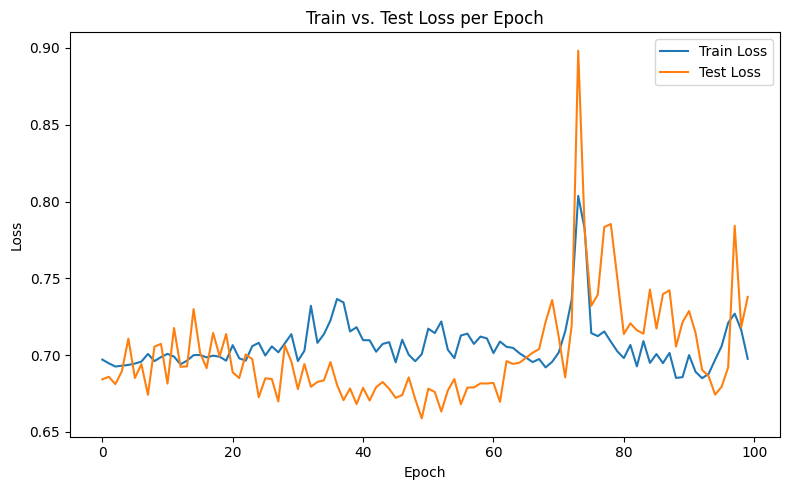

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.7009
[Epoch 10/100]  Train Loss: 0.7016
[Epoch 15/100]  Train Loss: 0.7092
[Epoch 20/100]  Train Loss: 0.7157
[Epoch 25/100]  Train Loss: 0.7202
[Epoch 30/100]  Train Loss: 0.7057
[Epoch 35/100]  Train Loss: 0.6887
[Epoch 40/100]  Train Loss: 0.6843
[Epoch 45/100]  Train Loss: 0.6775
[Epoch 50/100]  Train Loss: 0.6789
[Epoch 55/100]  Train Loss: 0.7423
[Epoch 60/100]  Train Loss: 0.6615
[Epoch 65/100]  Train Loss: 0.6751
[Epoch 70/100]  Train Loss: 0.6660
[Epoch 75/100]  Train Loss: 0.6594
[Epoch 80/100]  Train Loss: 0.6548
[Epoch 85/100]  Train Loss: 0.6750
[Epoch 90/100]  Train Loss: 0.6802
[Epoch 95/100]  Train Loss: 0.6797
[Epoch 100/100]  Train Loss: 0.6691
Accuracy on Nonzero Predictions: 0.3651


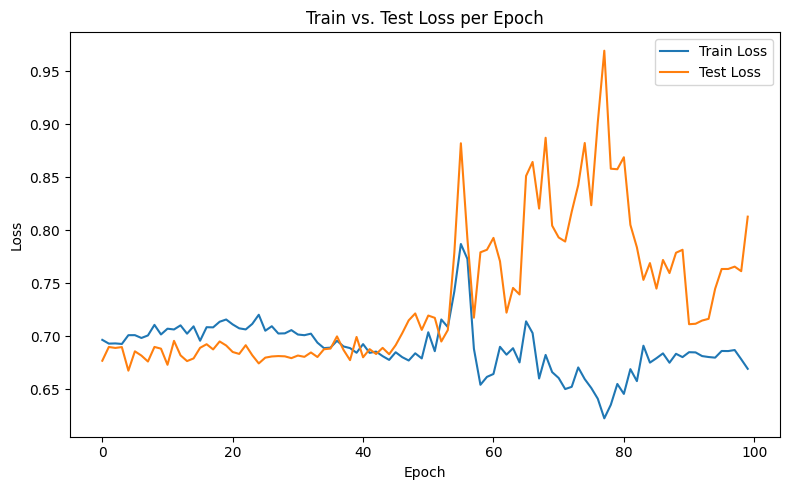

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6968
[Epoch 10/100]  Train Loss: 0.6987
[Epoch 15/100]  Train Loss: 0.6971
[Epoch 20/100]  Train Loss: 0.7091
[Epoch 25/100]  Train Loss: 0.7078
[Epoch 30/100]  Train Loss: 0.6892
[Epoch 35/100]  Train Loss: 0.6903
[Epoch 40/100]  Train Loss: 0.6950
[Epoch 45/100]  Train Loss: 0.6891
[Epoch 50/100]  Train Loss: 0.6931
[Epoch 55/100]  Train Loss: 0.6919
[Epoch 60/100]  Train Loss: 0.6898
[Epoch 65/100]  Train Loss: 0.6926
[Epoch 70/100]  Train Loss: 0.6854
[Epoch 75/100]  Train Loss: 0.6909
[Epoch 80/100]  Train Loss: 0.6911
[Epoch 85/100]  Train Loss: 0.7002
[Epoch 90/100]  Train Loss: 0.6941
[Epoch 95/100]  Train Loss: 0.6838
[Epoch 100/100]  Train Loss: 0.6909
Accuracy on Nonzero Predictions: 0.4365


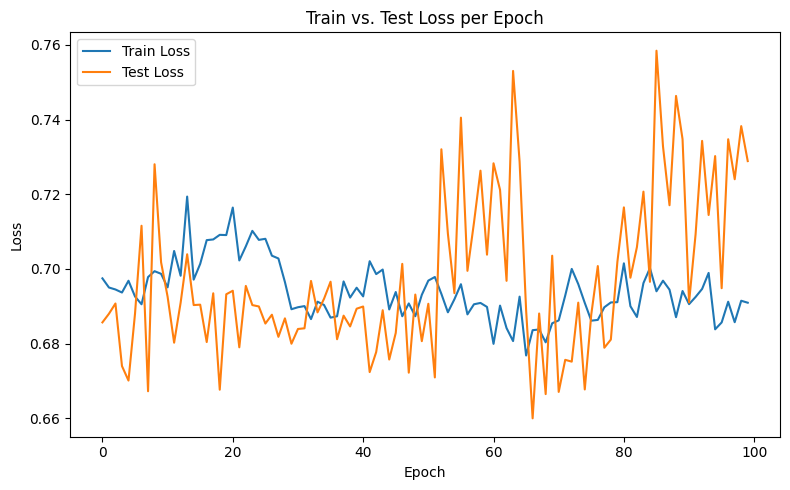

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6934
[Epoch 10/100]  Train Loss: 0.6881
[Epoch 15/100]  Train Loss: 0.7096
[Epoch 20/100]  Train Loss: 0.7259
[Epoch 25/100]  Train Loss: 0.7227
[Epoch 30/100]  Train Loss: 0.7215
[Epoch 35/100]  Train Loss: 0.6914
[Epoch 40/100]  Train Loss: 0.6977
[Epoch 45/100]  Train Loss: 0.6942
[Epoch 50/100]  Train Loss: 0.7100
[Epoch 55/100]  Train Loss: 0.7212
[Epoch 60/100]  Train Loss: 0.7164
[Epoch 65/100]  Train Loss: 0.7118
[Epoch 70/100]  Train Loss: 0.6966
[Epoch 75/100]  Train Loss: 0.6978
[Epoch 80/100]  Train Loss: 0.7116
[Epoch 85/100]  Train Loss: 0.7004
[Epoch 90/100]  Train Loss: 0.6884
[Epoch 95/100]  Train Loss: 0.6820
[Epoch 100/100]  Train Loss: 0.6876
Accuracy on Nonzero Predictions: 0.4524


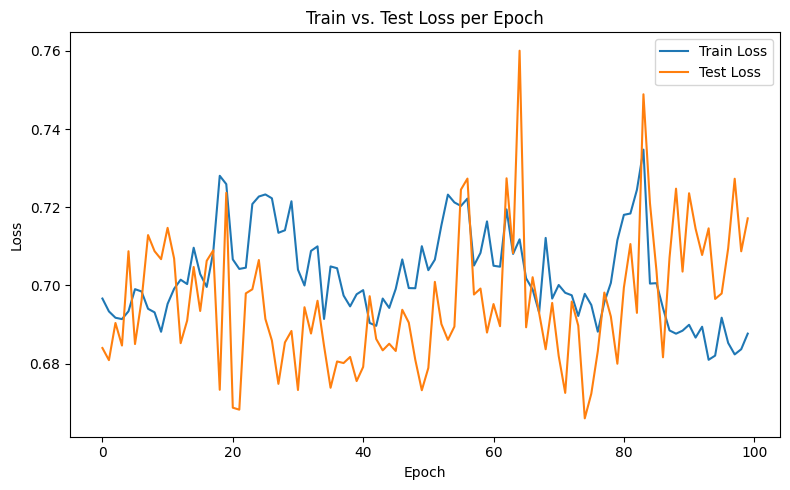

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
----- SECURITY TYPE: technical, WINDOW SIZE: 50, STOCK: SPX -----
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.4804
[Epoch 10/100]  Train Loss: 0.1361
[Epoch 15/100]  Train Loss: 0.0095
[Epoch 20/100]  Train Loss: 0.0020
[Epoch 25/100]  Train Loss: 0.0010
[Epoch 30/100]  Train Loss: 0.0006
[Epoch 35/100]  Train Loss: 0.0004
[Epoch 40/100]  Train Loss: 0.0003
[Epoch 45/100]  Train Loss: 0.0002
[Epoch 50/100]  Train Loss: 0.0002
[Epoch 55/100]  Train Loss: 0.0001
[Epoch 60/100]  Train Loss: 0.0001
[Epoch 65/100]  Train Loss: 0.0001
[Epoch 70/100]  Train Loss: 0.0001
[Epoch 75/100]  Train Loss: 0.0001
[Epoch 80/100]  Train Loss: 0.0001
[Epoch 85/100]  Train Loss: 0.0000
[Epoch 90/100]  Train Loss: 0.0000
[Epoch 95/100]  Train Loss: 0.0000
[Epoch 100/100]  Train Loss: 0.0000
Accuracy on Nonzero Predictions: 0.4516


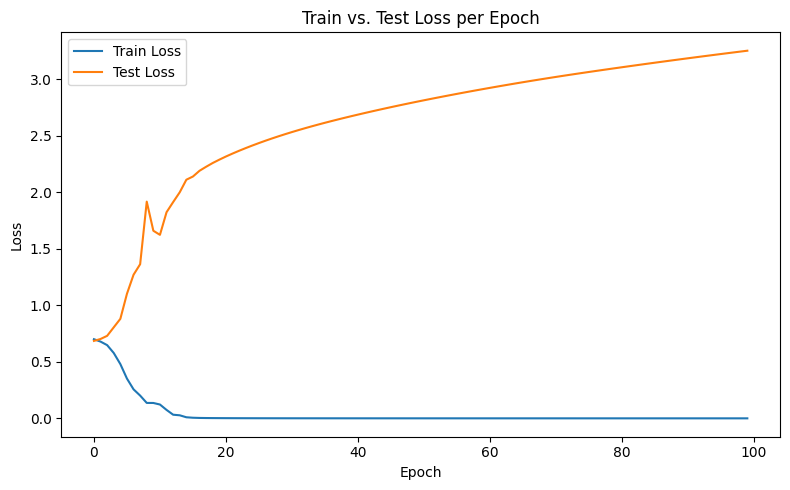

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.4932
[Epoch 10/100]  Train Loss: 0.2048
[Epoch 15/100]  Train Loss: 0.0095
[Epoch 20/100]  Train Loss: 0.0024
[Epoch 25/100]  Train Loss: 0.0013
[Epoch 30/100]  Train Loss: 0.0008
[Epoch 35/100]  Train Loss: 0.0005
[Epoch 40/100]  Train Loss: 0.0004
[Epoch 45/100]  Train Loss: 0.0003
[Epoch 50/100]  Train Loss: 0.0002
[Epoch 55/100]  Train Loss: 0.0002
[Epoch 60/100]  Train Loss: 0.0001
[Epoch 65/100]  Train Loss: 0.0001
[Epoch 70/100]  Train Loss: 0.0001
[Epoch 75/100]  Train Loss: 0.0001
[Epoch 80/100]  Train Loss: 0.0001
[Epoch 85/100]  Train Loss: 0.0001
[Epoch 90/100]  Train Loss: 0.0000
[Epoch 95/100]  Train Loss: 0.0000
[Epoch 100/100]  Train Loss: 0.0000
Accuracy on Nonzero Predictions: 0.5081


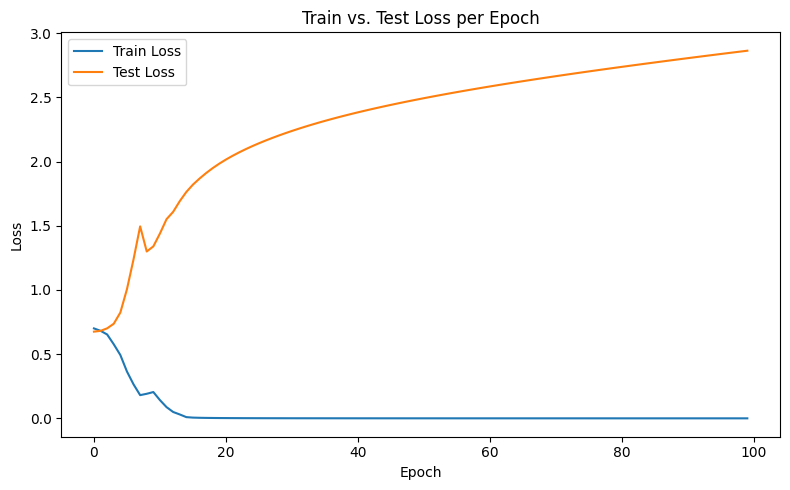

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.4867
[Epoch 10/100]  Train Loss: 0.1596
[Epoch 15/100]  Train Loss: 0.0075
[Epoch 20/100]  Train Loss: 0.0020
[Epoch 25/100]  Train Loss: 0.0011
[Epoch 30/100]  Train Loss: 0.0007
[Epoch 35/100]  Train Loss: 0.0004
[Epoch 40/100]  Train Loss: 0.0003
[Epoch 45/100]  Train Loss: 0.0002
[Epoch 50/100]  Train Loss: 0.0002
[Epoch 55/100]  Train Loss: 0.0001
[Epoch 60/100]  Train Loss: 0.0001
[Epoch 65/100]  Train Loss: 0.0001
[Epoch 70/100]  Train Loss: 0.0001
[Epoch 75/100]  Train Loss: 0.0001
[Epoch 80/100]  Train Loss: 0.0001
[Epoch 85/100]  Train Loss: 0.0000
[Epoch 90/100]  Train Loss: 0.0000
[Epoch 95/100]  Train Loss: 0.0000
[Epoch 100/100]  Train Loss: 0.0000
Accuracy on Nonzero Predictions: 0.4355


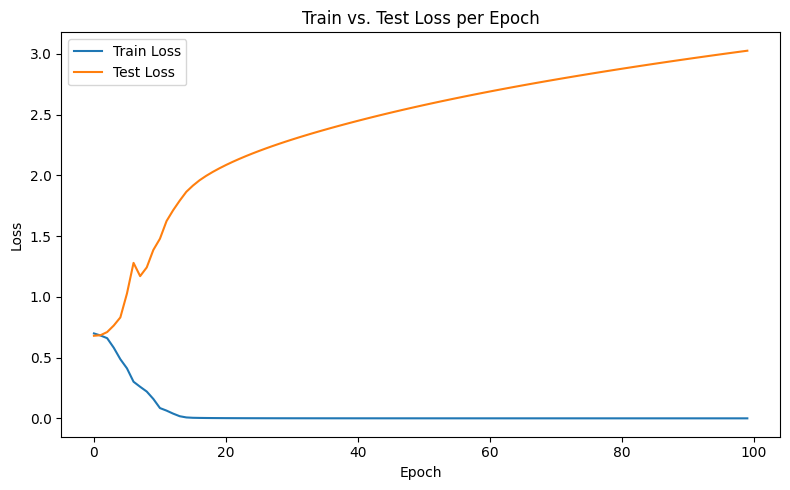

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.5254
[Epoch 10/100]  Train Loss: 0.2165
[Epoch 15/100]  Train Loss: 0.0090
[Epoch 20/100]  Train Loss: 0.0018
[Epoch 25/100]  Train Loss: 0.0009
[Epoch 30/100]  Train Loss: 0.0006
[Epoch 35/100]  Train Loss: 0.0004
[Epoch 40/100]  Train Loss: 0.0003
[Epoch 45/100]  Train Loss: 0.0002
[Epoch 50/100]  Train Loss: 0.0002
[Epoch 55/100]  Train Loss: 0.0001
[Epoch 60/100]  Train Loss: 0.0001
[Epoch 65/100]  Train Loss: 0.0001
[Epoch 70/100]  Train Loss: 0.0001
[Epoch 75/100]  Train Loss: 0.0001
[Epoch 80/100]  Train Loss: 0.0001
[Epoch 85/100]  Train Loss: 0.0000
[Epoch 90/100]  Train Loss: 0.0000
[Epoch 95/100]  Train Loss: 0.0000
[Epoch 100/100]  Train Loss: 0.0000
Accuracy on Nonzero Predictions: 0.5645


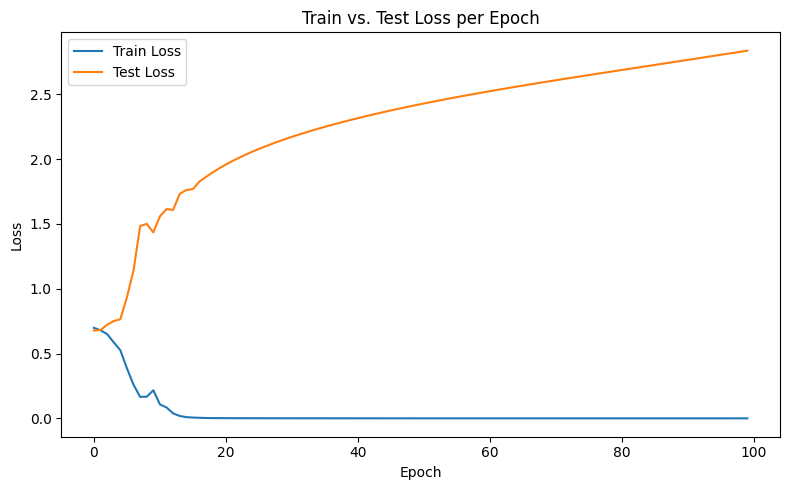

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.4797
[Epoch 10/100]  Train Loss: 0.2061
[Epoch 15/100]  Train Loss: 0.0137
[Epoch 20/100]  Train Loss: 0.0023
[Epoch 25/100]  Train Loss: 0.0012
[Epoch 30/100]  Train Loss: 0.0007
[Epoch 35/100]  Train Loss: 0.0005
[Epoch 40/100]  Train Loss: 0.0004
[Epoch 45/100]  Train Loss: 0.0003
[Epoch 50/100]  Train Loss: 0.0002
[Epoch 55/100]  Train Loss: 0.0002
[Epoch 60/100]  Train Loss: 0.0001
[Epoch 65/100]  Train Loss: 0.0001
[Epoch 70/100]  Train Loss: 0.0001
[Epoch 75/100]  Train Loss: 0.0001
[Epoch 80/100]  Train Loss: 0.0001
[Epoch 85/100]  Train Loss: 0.0001
[Epoch 90/100]  Train Loss: 0.0000
[Epoch 95/100]  Train Loss: 0.0000
[Epoch 100/100]  Train Loss: 0.0000
Accuracy on Nonzero Predictions: 0.5161


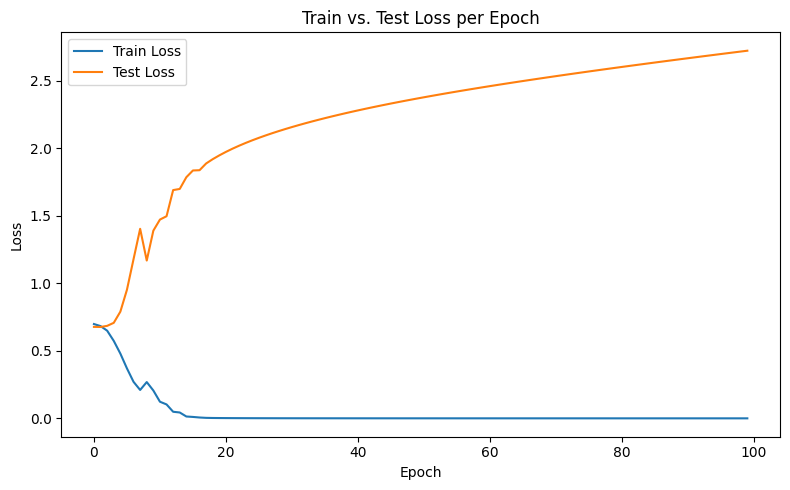

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.7059
[Epoch 10/100]  Train Loss: 0.6747
[Epoch 15/100]  Train Loss: 0.5139
[Epoch 20/100]  Train Loss: 0.4303
[Epoch 25/100]  Train Loss: 0.3062
[Epoch 30/100]  Train Loss: 0.3361
[Epoch 35/100]  Train Loss: 0.3407
[Epoch 40/100]  Train Loss: 0.3748
[Epoch 45/100]  Train Loss: 0.4561
[Epoch 50/100]  Train Loss: 0.5011
[Epoch 55/100]  Train Loss: 0.5119
[Epoch 60/100]  Train Loss: 0.5517
[Epoch 65/100]  Train Loss: 0.5555
[Epoch 70/100]  Train Loss: 0.6125
[Epoch 75/100]  Train Loss: 0.6128
[Epoch 80/100]  Train Loss: 0.6129
[Epoch 85/100]  Train Loss: 0.6441
[Epoch 90/100]  Train Loss: 0.6591
[Epoch 95/100]  Train Loss: 0.6562
[Epoch 100/100]  Train Loss: 0.7175
Accuracy on Nonzero Predictions: 0.4113


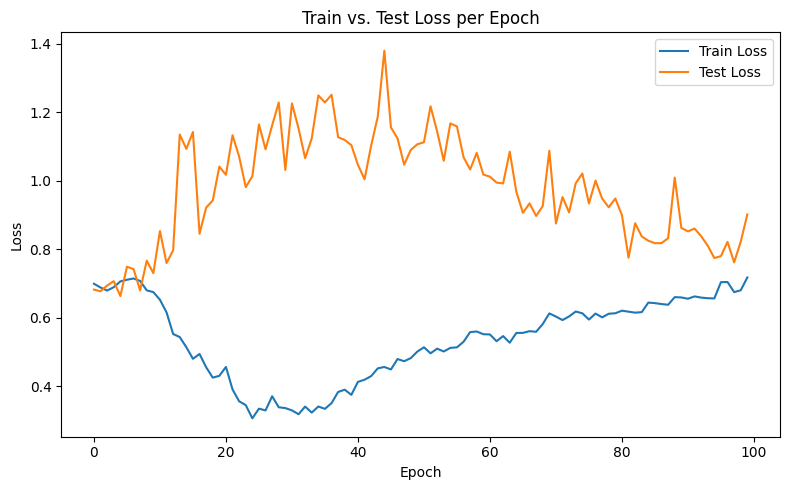

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.7119
[Epoch 10/100]  Train Loss: 0.6660
[Epoch 15/100]  Train Loss: 0.5622
[Epoch 20/100]  Train Loss: 0.4304
[Epoch 25/100]  Train Loss: 0.3501
[Epoch 30/100]  Train Loss: 0.3782
[Epoch 35/100]  Train Loss: 0.3317
[Epoch 40/100]  Train Loss: 0.3086
[Epoch 45/100]  Train Loss: 0.3014
[Epoch 50/100]  Train Loss: 0.2956
[Epoch 55/100]  Train Loss: 0.3382
[Epoch 60/100]  Train Loss: 0.3889
[Epoch 65/100]  Train Loss: 0.4262
[Epoch 70/100]  Train Loss: 0.4444
[Epoch 75/100]  Train Loss: 0.5500
[Epoch 80/100]  Train Loss: 0.5626
[Epoch 85/100]  Train Loss: 0.6115
[Epoch 90/100]  Train Loss: 0.6069
[Epoch 95/100]  Train Loss: 0.6487
[Epoch 100/100]  Train Loss: 0.6257
Accuracy on Nonzero Predictions: 0.4919


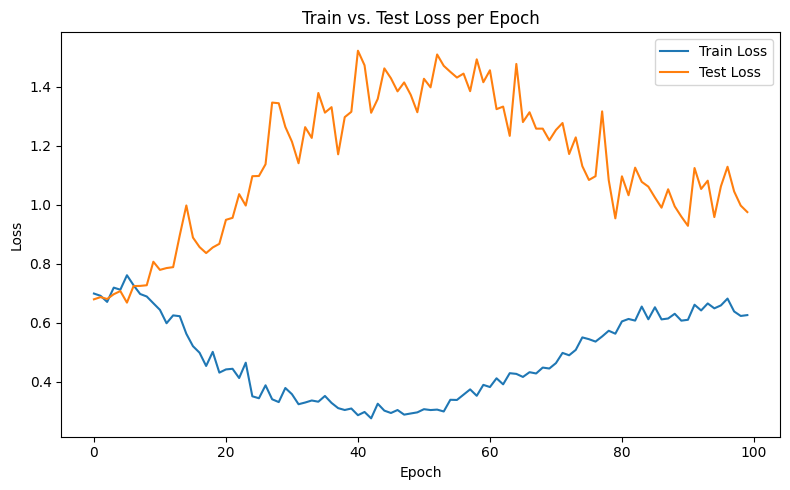

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6737
[Epoch 10/100]  Train Loss: 0.6508
[Epoch 15/100]  Train Loss: 0.4817
[Epoch 20/100]  Train Loss: 0.4472
[Epoch 25/100]  Train Loss: 0.3414
[Epoch 30/100]  Train Loss: 0.3521
[Epoch 35/100]  Train Loss: 0.3915
[Epoch 40/100]  Train Loss: 0.4411
[Epoch 45/100]  Train Loss: 0.4837
[Epoch 50/100]  Train Loss: 0.5249
[Epoch 55/100]  Train Loss: 0.5502
[Epoch 60/100]  Train Loss: 0.5651
[Epoch 65/100]  Train Loss: 0.5535
[Epoch 70/100]  Train Loss: 0.5703
[Epoch 75/100]  Train Loss: 0.6632
[Epoch 80/100]  Train Loss: 0.6545
[Epoch 85/100]  Train Loss: 0.6375
[Epoch 90/100]  Train Loss: 0.6375
[Epoch 95/100]  Train Loss: 0.6753
[Epoch 100/100]  Train Loss: 0.7055
Accuracy on Nonzero Predictions: 0.5726


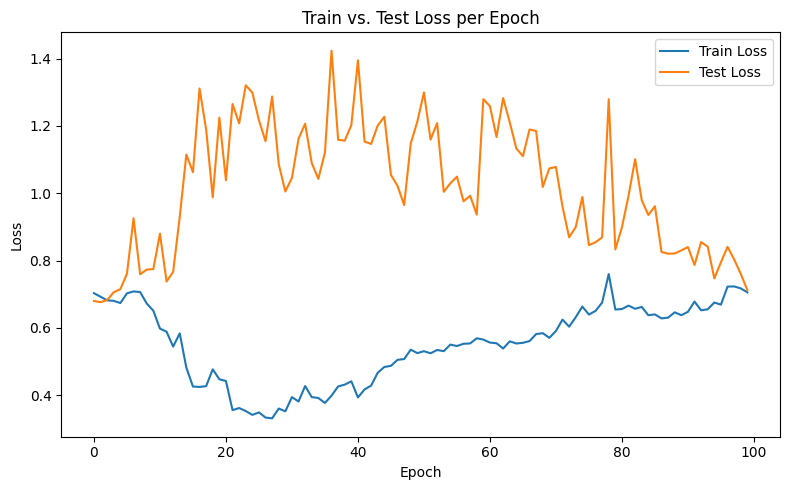

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6957
[Epoch 10/100]  Train Loss: 0.6712
[Epoch 15/100]  Train Loss: 0.5555
[Epoch 20/100]  Train Loss: 0.4114
[Epoch 25/100]  Train Loss: 0.3716
[Epoch 30/100]  Train Loss: 0.2974
[Epoch 35/100]  Train Loss: 0.3429
[Epoch 40/100]  Train Loss: 0.3828
[Epoch 45/100]  Train Loss: 0.3924
[Epoch 50/100]  Train Loss: 0.4259
[Epoch 55/100]  Train Loss: 0.4687
[Epoch 60/100]  Train Loss: 0.5194
[Epoch 65/100]  Train Loss: 0.5648
[Epoch 70/100]  Train Loss: 0.5466
[Epoch 75/100]  Train Loss: 0.5664
[Epoch 80/100]  Train Loss: 0.5892
[Epoch 85/100]  Train Loss: 0.5867
[Epoch 90/100]  Train Loss: 0.6233
[Epoch 95/100]  Train Loss: 0.6314
[Epoch 100/100]  Train Loss: 0.6789
Accuracy on Nonzero Predictions: 0.5000


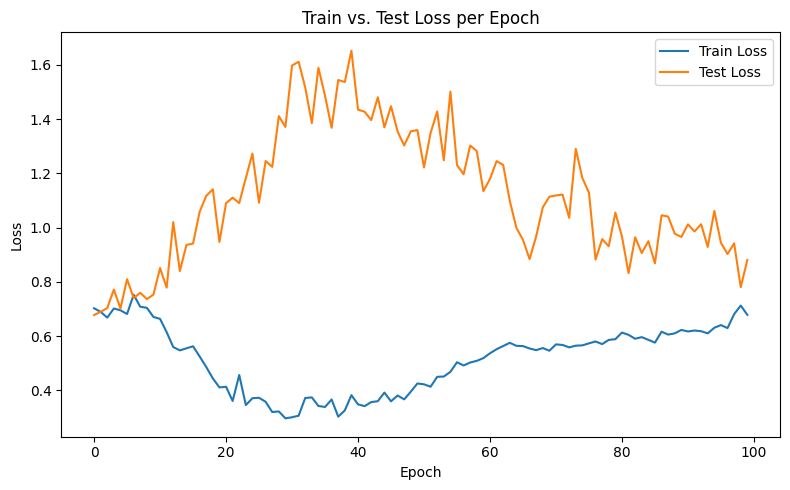

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6996
[Epoch 10/100]  Train Loss: 0.6860
[Epoch 15/100]  Train Loss: 0.5435
[Epoch 20/100]  Train Loss: 0.4321
[Epoch 25/100]  Train Loss: 0.3752
[Epoch 30/100]  Train Loss: 0.3643
[Epoch 35/100]  Train Loss: 0.3603
[Epoch 40/100]  Train Loss: 0.3630
[Epoch 45/100]  Train Loss: 0.3922
[Epoch 50/100]  Train Loss: 0.4508
[Epoch 55/100]  Train Loss: 0.4783
[Epoch 60/100]  Train Loss: 0.4912
[Epoch 65/100]  Train Loss: 0.5229
[Epoch 70/100]  Train Loss: 0.5651
[Epoch 75/100]  Train Loss: 0.5502
[Epoch 80/100]  Train Loss: 0.6079
[Epoch 85/100]  Train Loss: 0.6064
[Epoch 90/100]  Train Loss: 0.6319
[Epoch 95/100]  Train Loss: 0.6736
[Epoch 100/100]  Train Loss: 0.7206
Accuracy on Nonzero Predictions: 0.5000


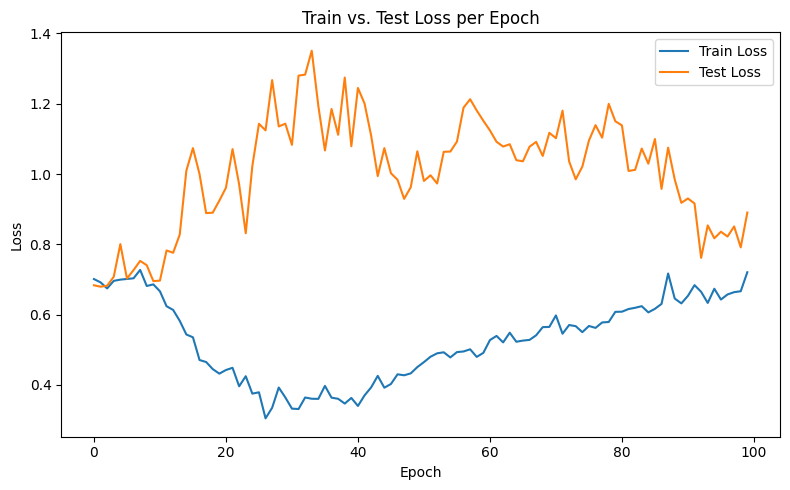

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
----- SECURITY TYPE: technical, WINDOW SIZE: 100, STOCK: SPX -----
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.2409
[Epoch 10/100]  Train Loss: 0.0181
[Epoch 15/100]  Train Loss: 0.0019
[Epoch 20/100]  Train Loss: 0.0010
[Epoch 25/100]  Train Loss: 0.0006
[Epoch 30/100]  Train Loss: 0.0004
[Epoch 35/100]  Train Loss: 0.0003
[Epoch 40/100]  Train Loss: 0.0002
[Epoch 45/100]  Train Loss: 0.0002
[Epoch 50/100]  Train Loss: 0.0001
[Epoch 55/100]  Train Loss: 0.0001
[Epoch 60/100]  Train Loss: 0.0001
[Epoch 65/100]  Train Loss: 0.0001
[Epoch 70/100]  Train Loss: 0.0001
[Epoch 75/100]  Train Loss: 0.0000
[Epoch 80/100]  Train Loss: 0.0000
[Epoch 85/100]  Train Loss: 0.0000
[Epoch 90/100]  Train Loss: 0.0000
[Epoch 95/100]  Train Loss: 0.0000
[Epoch 100/100]  Train Loss: 0.0000
Accuracy on Nonzero Predictions: 0.4793


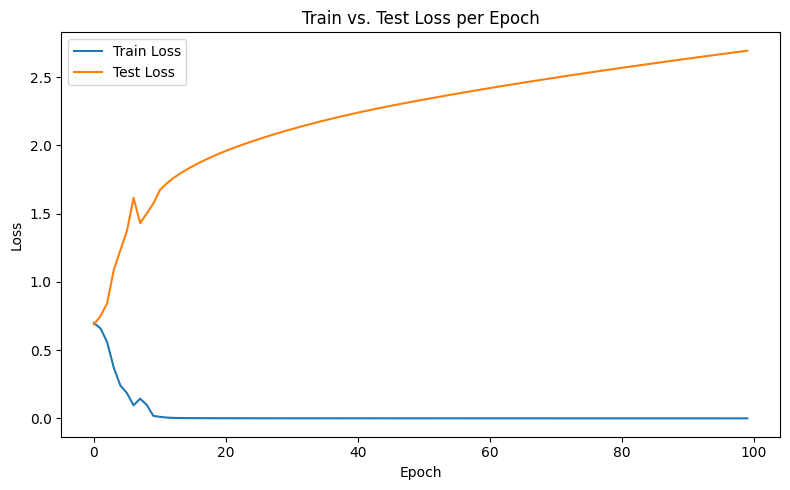

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.2035
[Epoch 10/100]  Train Loss: 0.0535
[Epoch 15/100]  Train Loss: 0.0018
[Epoch 20/100]  Train Loss: 0.0008
[Epoch 25/100]  Train Loss: 0.0005
[Epoch 30/100]  Train Loss: 0.0003
[Epoch 35/100]  Train Loss: 0.0002
[Epoch 40/100]  Train Loss: 0.0002
[Epoch 45/100]  Train Loss: 0.0001
[Epoch 50/100]  Train Loss: 0.0001
[Epoch 55/100]  Train Loss: 0.0001
[Epoch 60/100]  Train Loss: 0.0001
[Epoch 65/100]  Train Loss: 0.0001
[Epoch 70/100]  Train Loss: 0.0001
[Epoch 75/100]  Train Loss: 0.0000
[Epoch 80/100]  Train Loss: 0.0000
[Epoch 85/100]  Train Loss: 0.0000
[Epoch 90/100]  Train Loss: 0.0000
[Epoch 95/100]  Train Loss: 0.0000
[Epoch 100/100]  Train Loss: 0.0000
Accuracy on Nonzero Predictions: 0.4959


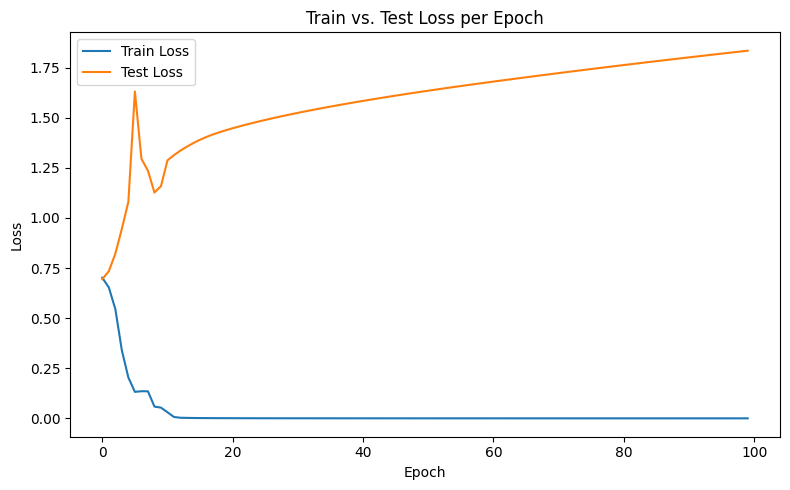

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.2287
[Epoch 10/100]  Train Loss: 0.0347
[Epoch 15/100]  Train Loss: 0.0020
[Epoch 20/100]  Train Loss: 0.0010
[Epoch 25/100]  Train Loss: 0.0006
[Epoch 30/100]  Train Loss: 0.0004
[Epoch 35/100]  Train Loss: 0.0003
[Epoch 40/100]  Train Loss: 0.0002
[Epoch 45/100]  Train Loss: 0.0002
[Epoch 50/100]  Train Loss: 0.0001
[Epoch 55/100]  Train Loss: 0.0001
[Epoch 60/100]  Train Loss: 0.0001
[Epoch 65/100]  Train Loss: 0.0001
[Epoch 70/100]  Train Loss: 0.0001
[Epoch 75/100]  Train Loss: 0.0000
[Epoch 80/100]  Train Loss: 0.0000
[Epoch 85/100]  Train Loss: 0.0000
[Epoch 90/100]  Train Loss: 0.0000
[Epoch 95/100]  Train Loss: 0.0000
[Epoch 100/100]  Train Loss: 0.0000
Accuracy on Nonzero Predictions: 0.5289


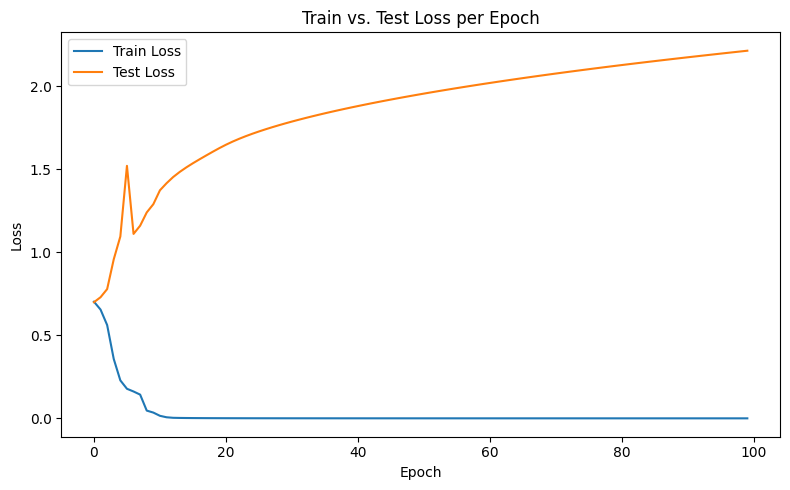

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.2731
[Epoch 10/100]  Train Loss: 0.0108
[Epoch 15/100]  Train Loss: 0.0020
[Epoch 20/100]  Train Loss: 0.0009
[Epoch 25/100]  Train Loss: 0.0005
[Epoch 30/100]  Train Loss: 0.0004
[Epoch 35/100]  Train Loss: 0.0003
[Epoch 40/100]  Train Loss: 0.0002
[Epoch 45/100]  Train Loss: 0.0002
[Epoch 50/100]  Train Loss: 0.0001
[Epoch 55/100]  Train Loss: 0.0001
[Epoch 60/100]  Train Loss: 0.0001
[Epoch 65/100]  Train Loss: 0.0001
[Epoch 70/100]  Train Loss: 0.0001
[Epoch 75/100]  Train Loss: 0.0000
[Epoch 80/100]  Train Loss: 0.0000
[Epoch 85/100]  Train Loss: 0.0000
[Epoch 90/100]  Train Loss: 0.0000
[Epoch 95/100]  Train Loss: 0.0000
[Epoch 100/100]  Train Loss: 0.0000
Accuracy on Nonzero Predictions: 0.5289


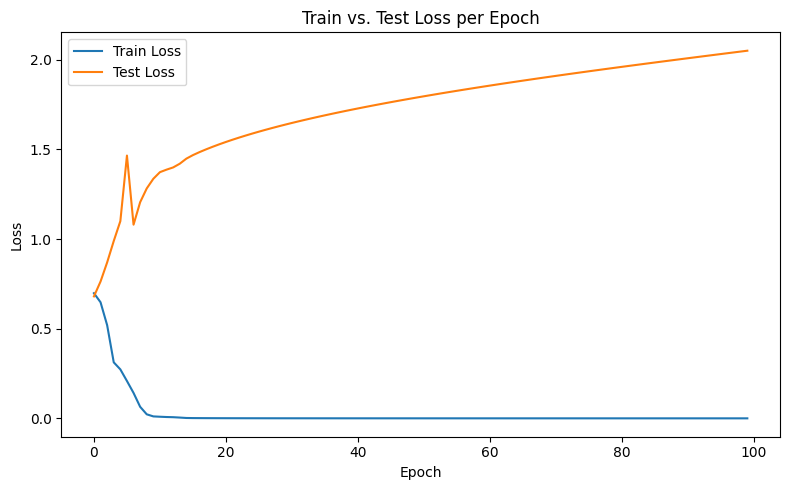

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.2299
[Epoch 10/100]  Train Loss: 0.0173
[Epoch 15/100]  Train Loss: 0.0017
[Epoch 20/100]  Train Loss: 0.0008
[Epoch 25/100]  Train Loss: 0.0005
[Epoch 30/100]  Train Loss: 0.0003
[Epoch 35/100]  Train Loss: 0.0002
[Epoch 40/100]  Train Loss: 0.0002
[Epoch 45/100]  Train Loss: 0.0001
[Epoch 50/100]  Train Loss: 0.0001
[Epoch 55/100]  Train Loss: 0.0001
[Epoch 60/100]  Train Loss: 0.0001
[Epoch 65/100]  Train Loss: 0.0001
[Epoch 70/100]  Train Loss: 0.0000
[Epoch 75/100]  Train Loss: 0.0000
[Epoch 80/100]  Train Loss: 0.0000
[Epoch 85/100]  Train Loss: 0.0000
[Epoch 90/100]  Train Loss: 0.0000
[Epoch 95/100]  Train Loss: 0.0000
[Epoch 100/100]  Train Loss: 0.0000
Accuracy on Nonzero Predictions: 0.5455


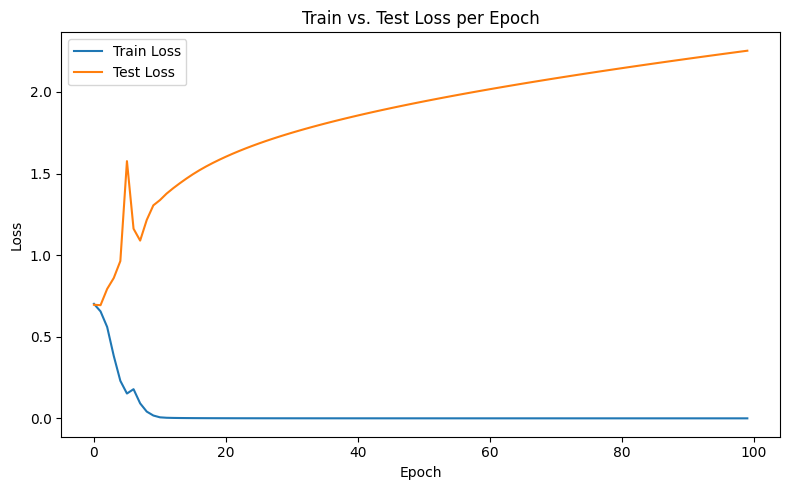

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6526
[Epoch 10/100]  Train Loss: 0.6604
[Epoch 15/100]  Train Loss: 0.2972
[Epoch 20/100]  Train Loss: 0.2712
[Epoch 25/100]  Train Loss: 0.0951
[Epoch 30/100]  Train Loss: 0.1248
[Epoch 35/100]  Train Loss: 0.0813
[Epoch 40/100]  Train Loss: 0.1046
[Epoch 45/100]  Train Loss: 0.1005
[Epoch 50/100]  Train Loss: 0.0845
[Epoch 55/100]  Train Loss: 0.0759
[Epoch 60/100]  Train Loss: 0.0971
[Epoch 65/100]  Train Loss: 0.1216
[Epoch 70/100]  Train Loss: 0.1088
[Epoch 75/100]  Train Loss: 0.1678
[Epoch 80/100]  Train Loss: 0.1759
[Epoch 85/100]  Train Loss: 0.2118
[Epoch 90/100]  Train Loss: 0.1979
[Epoch 95/100]  Train Loss: 0.2639
[Epoch 100/100]  Train Loss: 0.2704
Accuracy on Nonzero Predictions: 0.4793


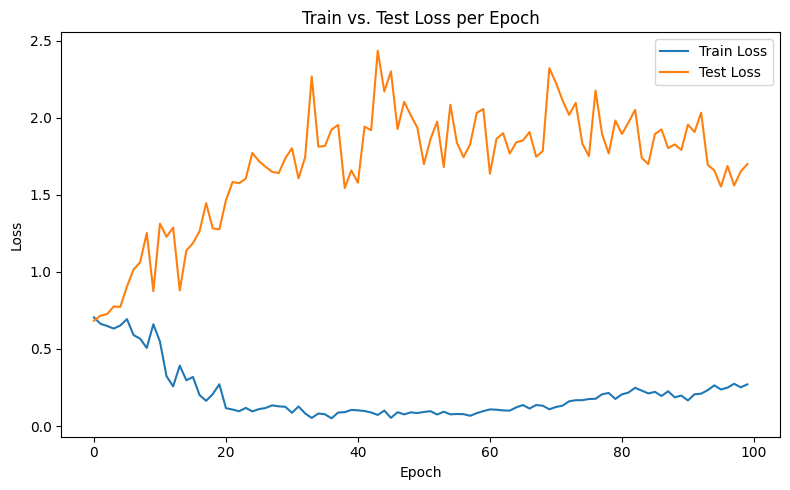

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6711
[Epoch 10/100]  Train Loss: 0.5347
[Epoch 15/100]  Train Loss: 0.2721
[Epoch 20/100]  Train Loss: 0.1690
[Epoch 25/100]  Train Loss: 0.1030
[Epoch 30/100]  Train Loss: 0.0923
[Epoch 35/100]  Train Loss: 0.0879
[Epoch 40/100]  Train Loss: 0.1094
[Epoch 45/100]  Train Loss: 0.1132
[Epoch 50/100]  Train Loss: 0.1400
[Epoch 55/100]  Train Loss: 0.1295
[Epoch 60/100]  Train Loss: 0.1351
[Epoch 65/100]  Train Loss: 0.1337
[Epoch 70/100]  Train Loss: 0.1591
[Epoch 75/100]  Train Loss: 0.1689
[Epoch 80/100]  Train Loss: 0.1949
[Epoch 85/100]  Train Loss: 0.2031
[Epoch 90/100]  Train Loss: 0.2150
[Epoch 95/100]  Train Loss: 0.2089
[Epoch 100/100]  Train Loss: 0.2792
Accuracy on Nonzero Predictions: 0.4298


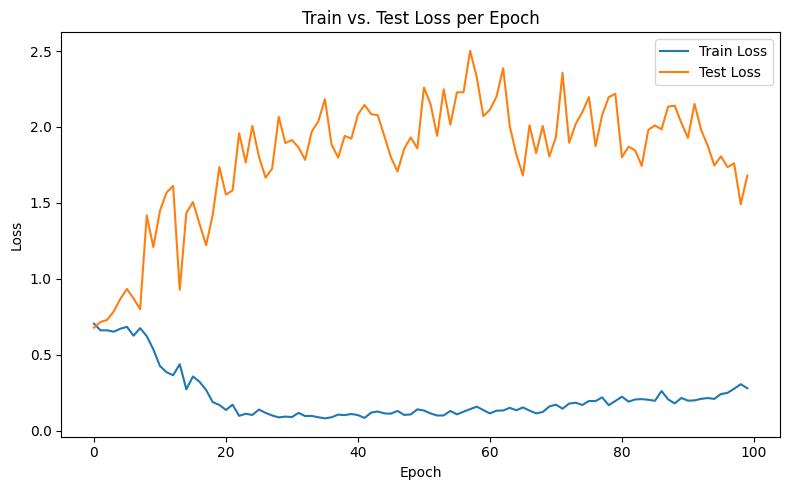

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.7164
[Epoch 10/100]  Train Loss: 0.5246
[Epoch 15/100]  Train Loss: 0.3703
[Epoch 20/100]  Train Loss: 0.1366
[Epoch 25/100]  Train Loss: 0.0854
[Epoch 30/100]  Train Loss: 0.1113
[Epoch 35/100]  Train Loss: 0.0783
[Epoch 40/100]  Train Loss: 0.0779
[Epoch 45/100]  Train Loss: 0.0896
[Epoch 50/100]  Train Loss: 0.1045
[Epoch 55/100]  Train Loss: 0.1140
[Epoch 60/100]  Train Loss: 0.1619
[Epoch 65/100]  Train Loss: 0.1705
[Epoch 70/100]  Train Loss: 0.1938
[Epoch 75/100]  Train Loss: 0.2128
[Epoch 80/100]  Train Loss: 0.2508
[Epoch 85/100]  Train Loss: 0.2896
[Epoch 90/100]  Train Loss: 0.3492
[Epoch 95/100]  Train Loss: 0.3343
[Epoch 100/100]  Train Loss: 0.3444
Accuracy on Nonzero Predictions: 0.4876


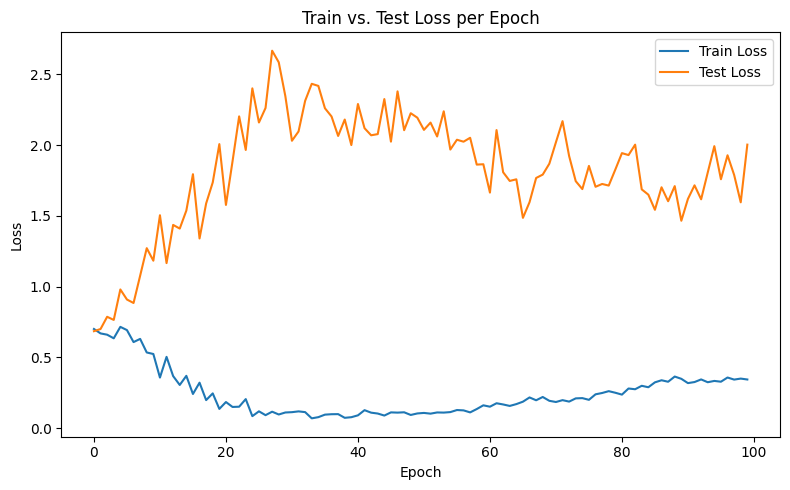

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6903
[Epoch 10/100]  Train Loss: 0.4830
[Epoch 15/100]  Train Loss: 0.3537
[Epoch 20/100]  Train Loss: 0.1912
[Epoch 25/100]  Train Loss: 0.0818
[Epoch 30/100]  Train Loss: 0.1275
[Epoch 35/100]  Train Loss: 0.0898
[Epoch 40/100]  Train Loss: 0.0580
[Epoch 45/100]  Train Loss: 0.1045
[Epoch 50/100]  Train Loss: 0.1227
[Epoch 55/100]  Train Loss: 0.1175
[Epoch 60/100]  Train Loss: 0.1518
[Epoch 65/100]  Train Loss: 0.2152
[Epoch 70/100]  Train Loss: 0.2349
[Epoch 75/100]  Train Loss: 0.2969
[Epoch 80/100]  Train Loss: 0.4170
[Epoch 85/100]  Train Loss: 0.4952
[Epoch 90/100]  Train Loss: 0.5155
[Epoch 95/100]  Train Loss: 0.5011
[Epoch 100/100]  Train Loss: 0.4986
Accuracy on Nonzero Predictions: 0.5124


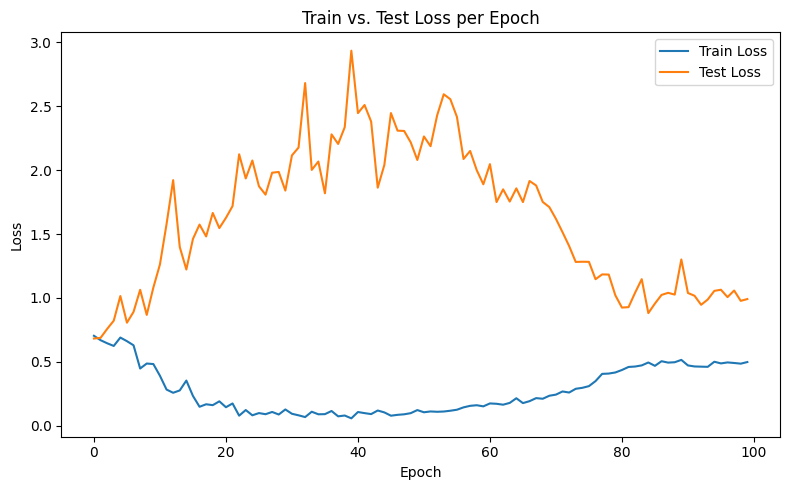

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: technical
[Epoch 5/100]  Train Loss: 0.6318
[Epoch 10/100]  Train Loss: 0.4841
[Epoch 15/100]  Train Loss: 0.2156
[Epoch 20/100]  Train Loss: 0.1647
[Epoch 25/100]  Train Loss: 0.0958
[Epoch 30/100]  Train Loss: 0.0690
[Epoch 35/100]  Train Loss: 0.0515
[Epoch 40/100]  Train Loss: 0.0909
[Epoch 45/100]  Train Loss: 0.0796
[Epoch 50/100]  Train Loss: 0.0750
[Epoch 55/100]  Train Loss: 0.0732
[Epoch 60/100]  Train Loss: 0.1080
[Epoch 65/100]  Train Loss: 0.0915
[Epoch 70/100]  Train Loss: 0.1379
[Epoch 75/100]  Train Loss: 0.1698
[Epoch 80/100]  Train Loss: 0.1338
[Epoch 85/100]  Train Loss: 0.1414
[Epoch 90/100]  Train Loss: 0.1743
[Epoch 95/100]  Train Loss: 0.2546
[Epoch 100/100]  Train Loss: 0.2570
Accuracy on Nonzero Predictions: 0.4959


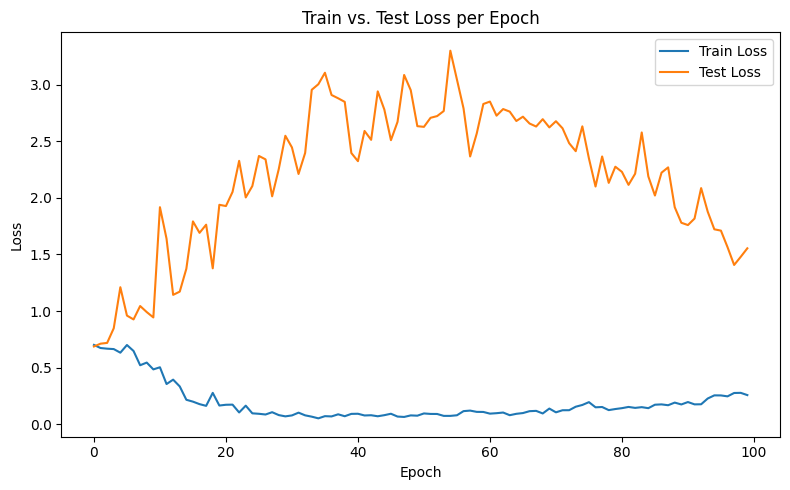

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png


In [12]:
model_types = ["lstm", "gru"]   
sample_size = 5
processing = "clean"
period = "10y"
security_types = ["single_name", "options", "technical"]
window_sizes = [5, 10, 50, 100]
stocks = ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'SPX']
stock = stocks[-1]
results_list = []

for security_type in security_types:
    for window_size in window_sizes:
        initial_data_dir = os.path.join(project_dir, f"00_data/{processing}") 

        # 1) Load original data (info only)
        filename = f"{security_type}/{stock}/{period}_data.csv"
        original_input_filepath = os.path.join(initial_data_dir, filename)
        original_data = pd.read_csv(original_input_filepath)

        print(f"----- SECURITY TYPE: {security_type}, WINDOW SIZE: {window_size}, STOCK: {stock} -----")

        # 2) Load the preprocessed data
        pkl_filename = f"{processing}/{security_type}/{stock}/{period}_{window_size}_data.pkl"
        input_filepath = os.path.join(horizontal_data_dir, pkl_filename)
        input_df = pd.read_pickle(input_filepath)

        # 3) Reshape
        X_resampled, y_resampled = reshape_remove_characters(input_df)

        input_size = X_resampled.shape[2]
        train_size = int(X_resampled.shape[0] * possible_train_size / 100)
        # train_size = X_combined.shape[0]-30
        test_size = X_resampled.shape[0] - train_size

        for model_type in model_types:
            for i in range(sample_size):
                if model_type == "gru":
                    model = GRU3DClassifier(input_size, hidden_size, output_size, num_layers, dropout)
                elif model_type == "lstm":
                    model = StockPriceLSTM(input_size, hidden_size, output_size)

                model = model.to(device)

                optimizer = optim.Adam(model.parameters(), lr=learning_rate)
                print(f"Training {stocks[-1]} | LR: {learning_rate} | Epochs: {num_epochs} "
                      f"| Batch: {batch_size} | Security type: {security_type}")


                result = evaluate_model_plot(
                    model, 
                    X_resampled, 
                    y_resampled, 
                    criterion, 
                    optimizer, 
                    device, 
                    train_size, 
                    batch_size, 
                    num_epochs, 
                    lower_threshold = 0.5,
                    plots_dir=plots_dir,
                    plot_filename=None
                )

                # Store results in a list
                results_list.append({
                    "stock": stock,
                    "security_type": security_type,
                    "window_size": window_size,
                    "model_type": model_type,
                    "iteration": i + 1,
                    "accuracy_nonzero": result["accuracy_nonzero"],
                    "loss_decrease_percentage": result["loss_decrease_percentage"],
                    "final_train_loss": result["final_train_loss"]
                })

results_df = pd.DataFrame(results_list)

In [ ]:
results_df = pd.DataFrame(results_list)
output_folder = os.path.join(results_dir, 'combined_vs_individual_v1')
results_df.to_csv(os.path.join(output_folder, f'uncombined_single_name_{stock}.csv'), index=False)

In [13]:
results_df

stock security_type  window_size model_type  iteration  accuracy_nonzero  \
0     SPX   single_name            5       lstm          1          0.534351   
1     SPX   single_name            5       lstm          2          0.488550   
2     SPX   single_name            5       lstm          3          0.488550   
3     SPX   single_name            5       lstm          4          0.450382   
4     SPX   single_name            5       lstm          5          0.534351   
..    ...           ...          ...        ...        ...               ...   
115   SPX     technical          100        gru          1          0.479339   
116   SPX     technical          100        gru          2          0.429752   
117   SPX     technical          100        gru          3          0.487603   
118   SPX     technical          100        gru          4          0.512397   
119   SPX     technical          100        gru          5          0.495868   

     loss_decrease_percentage  final_train_loss  
0                  -12.353691          0.609783  
1                  -11.189938          0.617710  
2                  -12.823784          0.606293  
3                  -14.717004          0.592935  
4                  -11.331350          0.616675  
..                        ...               ...  
115                -61.652161          0.270434  
116                -60.379806          0.279172  
117                -50.898770          0.344401  
118                -29.191713          0.498594  
119                -63.309156          0.257023  

[120 rows x 8 columns]